In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
warnings.filterwarnings('ignore')

"Pradhan Mantri Jan-Dhan Yojana (PMJDY)" under the National Mission for Financial Inclusion was launched initially for a period of 4 years (in two phases) on 28th August 2014. It envisages universal access to banking facilities with at least one basic banking account for every household, financial literacy, access to credit, insurance and pension.


PMJDY has provided a platform for the three social security schemes viz. Pradhan Mantri Jeevan Jyoti Bima Yojana (PMJJBY), Pradhan Mantri Suraksha Bima Yojana (PMSBY), Atal Pension Yojana (APY) and Pradhan Mantri Mudra Yojana (PMMY).

In [2]:
data = pd.read_csv('../data/imf.csv',index_col=0,encoding = "utf-8")

# Synthetic Control w/ Lasso

In [3]:
import sklearn.linear_model as lm
import sklearn.ensemble as en

In [4]:
# time_intervention = 2016
# target = 'India'
# series = 'Non-life insurance policies per 1,000 adults'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
def setup(target,donors,series,time_intervention,data):
    Y_target = pd.DataFrame(data.loc[target,series].to_numpy(),index=data['Year'].unique(),columns=[target])
    Y_donor = (pd.DataFrame([data.loc[donor,series].to_numpy() for donor in donors],index=donors,columns=data['Year'].unique()).T).dropna(axis=1)#.fillna(method='ffill').fillna(method='bfill')
    Ypre_target = Y_target.loc[Y_target.index<=time_intervention] #pre_intervention.loc[target,series].fillna(method='ffill').fillna(method='bfill').to_numpy()
    Ypre_donor = Y_donor.loc[Y_donor.index<=time_intervention] #(pd.DataFrame([pre_intervention.loc[donor,series].to_numpy() for donor in donors],index=donors).T).fillna(method='ffill').fillna(method='bfill')
    return Ypre_target,Ypre_donor,Y_target,Y_donor

# Bundles

In [5]:
bundles_names = ['Deposit accounts with commercial banks: o/w household sector',
                 'No of household sector deposit accounts with commercial banks per 1,000 adults',
                 'Number of life insurance policies per 1,000 adults',
                 'Non-life insurance policies per 1,000 adults',
                 'Number of loan accounts with commercial banks per 1,000 adults',
                 'Loan accounts with commercial banks: o/w SME',
                 'No of household sector loan accounts with commercial banks per 1,000 adults',
                 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults']


In [6]:
bundles = {}
for series in bundles_names:
    time_intervention = 2015
    target = 'India'
    donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
              'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
              'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
              'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
              'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
              'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
              'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
              'Zambia']
    Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)
    bundles[series] = (Ypre_target,Ypre_donor,Y_target,Y_donor)

In [ ]:
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)
#     m_rf = en.RandomForestRegressor().fit(Ypre_donor,Ypre_target)
    
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)
#     Y_target_rf = m_rf.predict(Y_donor.fillna(method='ffill'))
    
    fig = plt.figure(figsize=(20,8))
    sns.set(font_scale=1.65)
    plt.plot(np.arange(2004,2020),Y_target,lw='4')
    plt.plot(np.arange(2004,2020),Y_target_bayesian,ls='--',lw=4)
    plt.plot(np.arange(2004,2020),Y_target_lasso,ls='--',lw=4)
#     plt.plot(np.arange(2004,2020),Y_target_rf)
    plt.axvline(time_intervention-1,c='black')
    plt.axvline(time_intervention+0,c='black')
    plt.fill_betweenx(y=Y_target.sort_values(by='India').to_numpy()[:,0],
                      x1=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention-1),
                      x2=np.ones_like(Y_target.to_numpy()[:,0])*(time_intervention),alpha=0.2,color='black')
    plt.text(2014.5,np.max(Y_target.to_numpy())/2,'Launch of PMJDY',rotation=90,alpha=0.5)
    plt.ylim((np.min(Y_target.to_numpy()),np.max(Y_target.to_numpy())))
    plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Lasso-Control','Year of Intervention : 2015'])
    fig.savefig('%s_%s.png'%(target,series.replace('/','')))

# Placebo Test

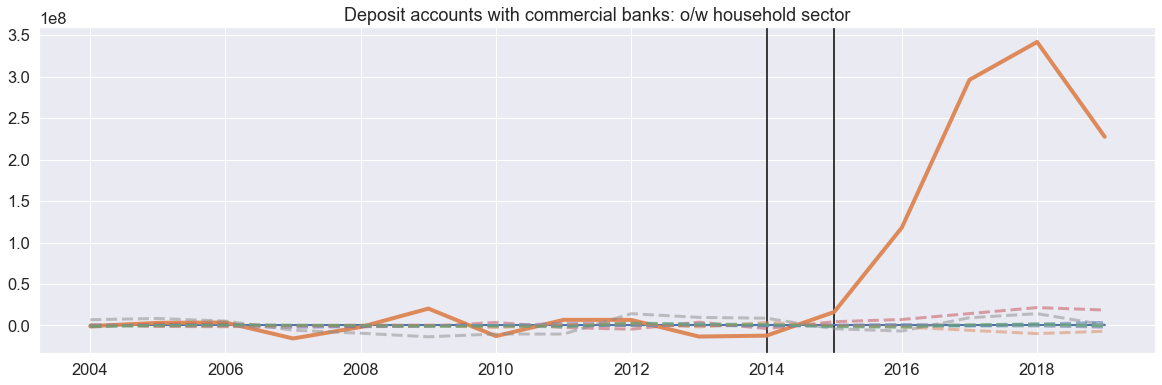

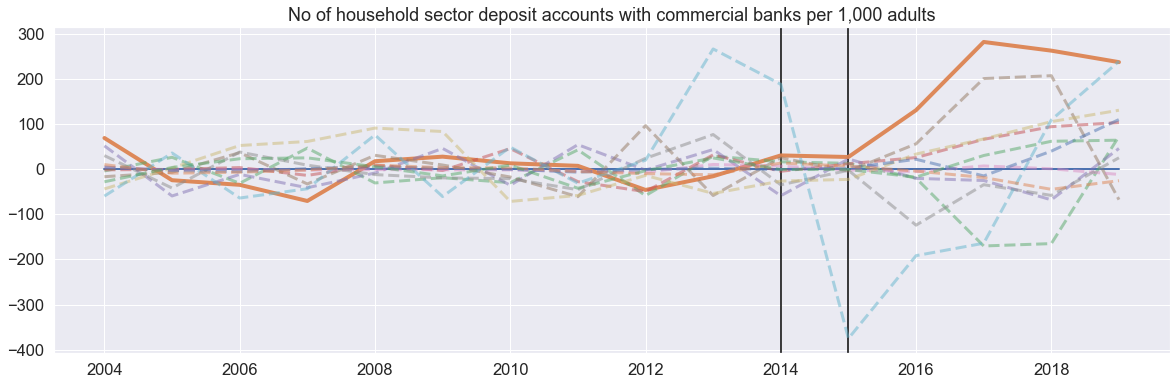

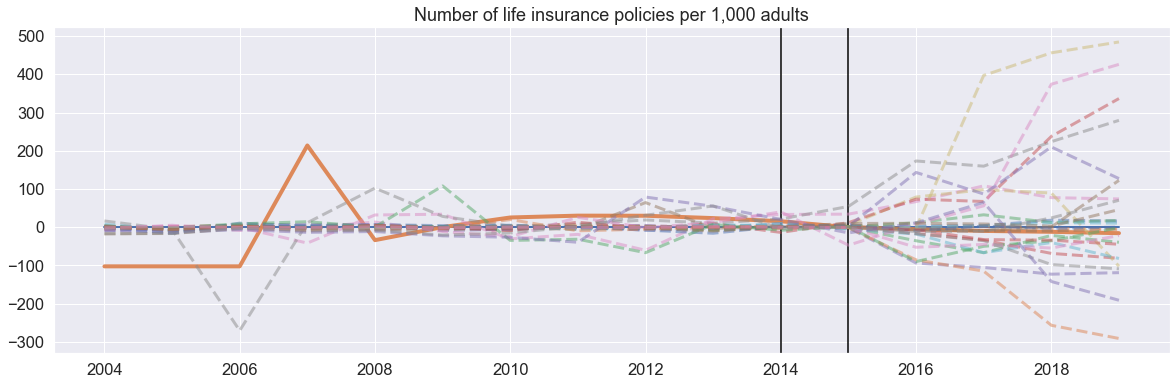

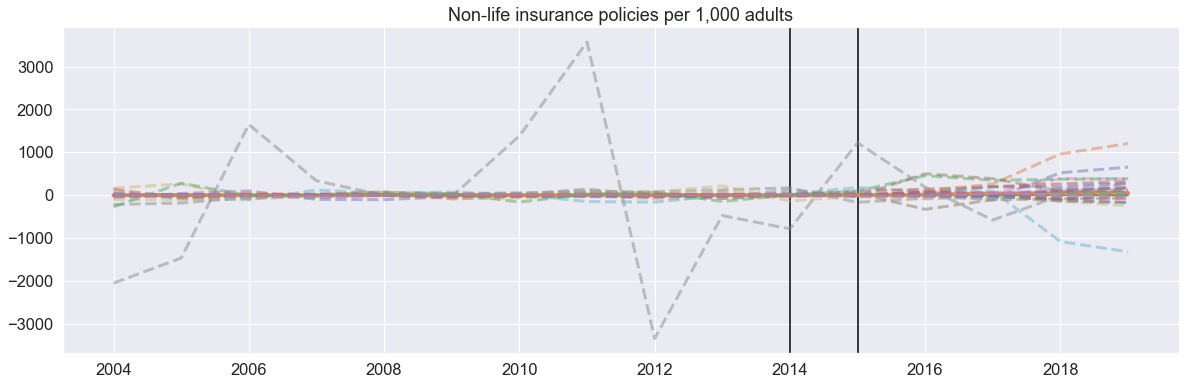

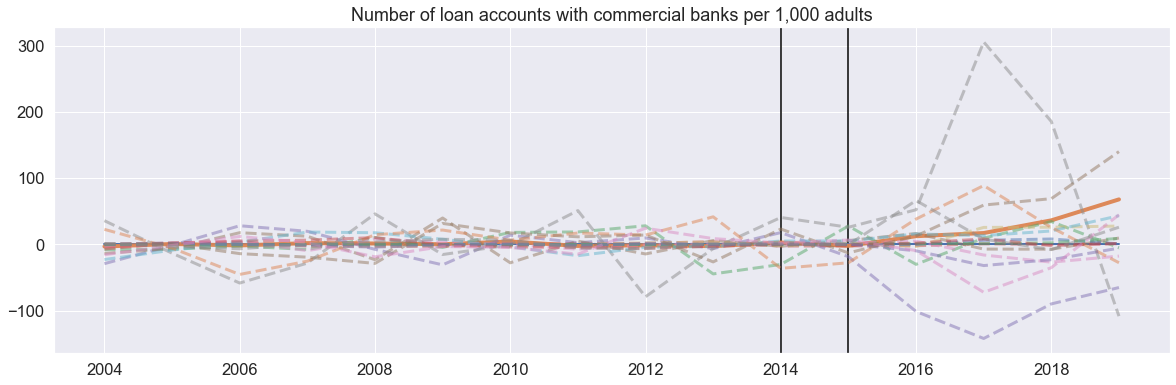

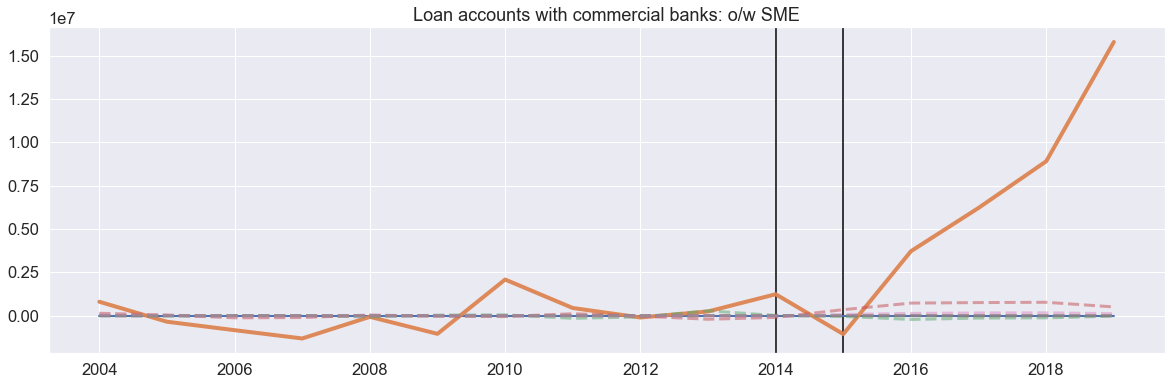

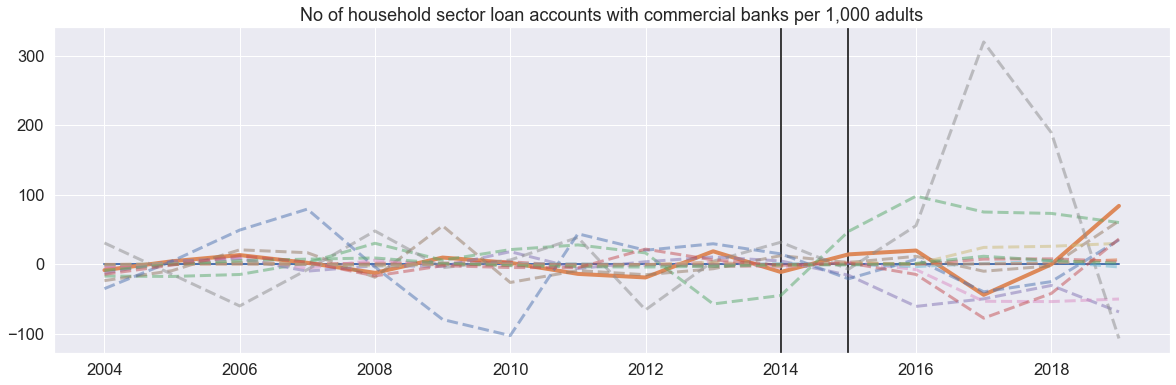

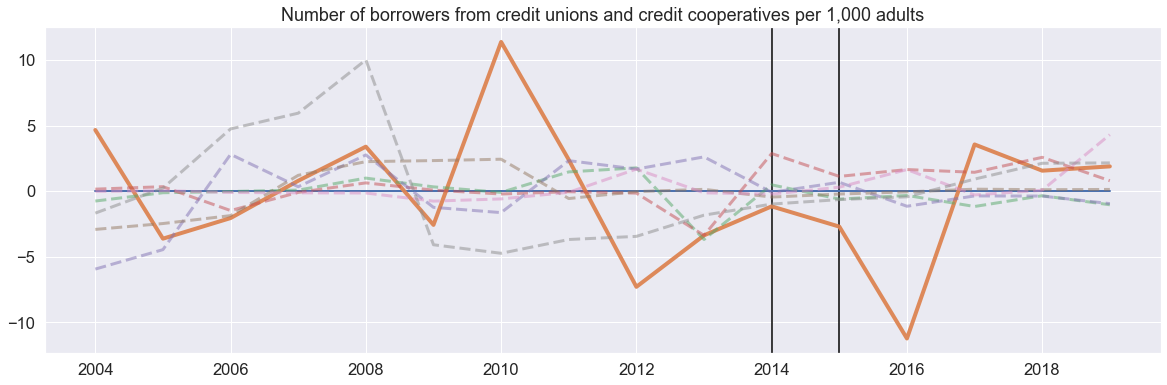

In [8]:
sns.set(font_scale=1.5)
pval = {}
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    Ypost_donor = Y_donor.loc[Y_donor.index>time_intervention]
    Ypost_target = Y_target.loc[Y_target.index>time_intervention]
    fig = plt.figure(figsize=(20,6))
    
    plt.axvline(time_intervention-1,c='black')
    plt.axvline(time_intervention+0,c='black')
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    
    rmse_pre_target = np.sqrt(np.mean(np.square(Ypre_target.values.reshape(-1,) - m_lasso.predict(Ypre_donor.fillna(method='ffill')).reshape(-1,))))
    rmse_post_target = np.sqrt(np.mean(np.square(Ypost_target.values.reshape(-1,) - m_lasso.predict(Ypost_donor.fillna(method='ffill')).reshape(-1,))))
    
    rmse_pre_placebo = []
    rmse_post_placebo = []
    
    plt.plot(np.arange(2004,2020),Y_target-Y_target,lw='2')
    plt.plot(np.arange(2004,2020),Y_target.to_numpy().reshape(-1,)-Y_target_lasso.reshape(-1,),lw='4',alpha=0.95)

    plt.title(series)
    for col in Y_donor.columns:
        Y_placebo = Y_donor[col]
        Ypre_placebo = Ypre_donor[col]
        Ypost_placebo = Ypost_donor[col]
        
        m_lasso = lm.LassoCV().fit(Ypre_donor.drop(columns=[col]),Ypre_placebo)
        Y_placebo_lasso = m_lasso.predict(Y_donor.drop(columns=[col]))
        
        rmse_pre_placebo += [np.sqrt(np.mean(np.square(Ypre_placebo.values.reshape(-1,) - m_lasso.predict(Ypre_donor.drop(columns=[col])).reshape(-1,))))]
        rmse_post_placebo += [np.sqrt(np.mean(np.square(Ypost_placebo.values.reshape(-1,) - m_lasso.predict(Ypost_donor.drop(columns=[col])).reshape(-1,))))] 
        
        plt.plot(np.arange(2004,2020),Y_placebo - Y_placebo_lasso,ls='--',lw=3,alpha=0.5)

#         plt.text(2014.5,np.max(Y_placebo.to_numpy())/2,'Launch of PMJDY',rotation=90,alpha=0.5)
#         plt.ylim((np.min(Y_placebo.to_numpy()),np.max(Y_placebo.to_numpy())))
#         plt.legend(['%s (%s)'%(col,series)])

    r_target = rmse_post_target/rmse_pre_target
    r_placebo = np.array(rmse_post_placebo)/np.array(rmse_pre_placebo)
    p = np.sum(r_placebo>r_target)/len(r_placebo)
    pval[series] = p
    fig.savefig('placebo_study_%s_%s.png'%(target,series.replace('/','')))

In [9]:
pval

{'Deposit accounts with commercial banks: o/w household sector': 0.0,
 'No of household sector deposit accounts with commercial banks per 1,000 adults': 0.09090909090909091,
 'Number of life insurance policies per 1,000 adults': 1.0,
 'Non-life insurance policies per 1,000 adults': 0.2692307692307692,
 'Number of loan accounts with commercial banks per 1,000 adults': 0.0625,
 'Loan accounts with commercial banks: o/w SME': 0.0,
 'No of household sector loan accounts with commercial banks per 1,000 adults': 0.5833333333333334,
 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults': 0.16666666666666666}

# Credence

In [10]:
import torch

In [11]:
import os
import sys
sys.path.append(os.path.abspath('../python'))

In [12]:
import train_arvae
import verify_causal_model

## Setting up the training data

In [13]:
B = 5000 #number of units to train the neural net
N = 10 #number of timeseries in a unit
T = 16 #length of each timeseries

series_names = np.random.choice(bundles_names,size = B,replace = True)
for i in range(0,B):
    series = series_names[i]
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    Nmax = Y_donor.shape[1]
    idxs = np.random.choice(a = Nmax,size = N,replace = True)
    data_i = Y_donor.iloc[:,list(idxs)].values.reshape((T,1,N))
    data_i = (data_i - np.mean(data_i))/np.std(data_i)
#     print('%.2f,%.2f'%(np.mean(data_i),np.std(data_i)))
    if i == 0:
        data = data_i
    else:
        data = np.concatenate((data,data_i),axis=1)

data_2d = train_arvae.convert_to_2d(data)

In [14]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (5000, 160)

Mean of raw data: 0.000
Std. dev of raw data: 1.000


In [15]:
hyper_params = {}
hyper_params['epochs'] = 5000
hyper_params['latent_dim'] = 8 #Z
hyper_params['hidden_dims'] = [32,16]
hyper_params['kld_weight'] = 5e-02

In [16]:
vae_model, runner = train_arvae.train(data_2d, hyper_params, 
                          output_checkpoint_path='ar_vae_jandhan_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 5.7 K 
1 | fc_mu         | Linear     | 136   
2 | fc_var        | Linear     | 136   
3 | decoder_input | Linear     | 144   
4 | decoder       | Sequential | 544   
5 | final_layer   | Sequential | 5.3 K 
---------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.0449, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0374, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.1496, grad_fn=<MeanBackward0>), 'KLD_weight': 0.05}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0449), 'kld_loss': tensor(0.1496), 'reconstruction_loss': tensor(1.0374)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0294), 'kld_loss': tensor(0.1411), 'reconstruction_loss': tensor(1.0224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0181), 'kld_loss': tensor(0.1292), 'reconstruction_loss': tensor(1.0116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0095), 'kld_loss': tensor(0.1129), 'reconstruction_loss': tensor(1.0038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0023), 'kld_loss': tensor(0.0952), 'reconstruction_loss': tensor(0.9976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9967), 'kld_loss': tensor(0.0774), 'reconstruction_loss': tensor(0.9928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9923), 'kld_loss': tensor(0.0607), 'reconstruction_loss': tensor(0.9893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9886), 'kld_loss': tensor(0.0486), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.0398), 'reconstruction_loss': tensor(0.9840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9835), 'kld_loss': tensor(0.0303), 'reconstruction_loss': tensor(0.9820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.0215), 'reconstruction_loss': tensor(0.9804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.0163), 'reconstruction_loss': tensor(0.9795)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.0144), 'reconstruction_loss': tensor(0.9781)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.0143), 'reconstruction_loss': tensor(0.9772)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.0153), 'reconstruction_loss': tensor(0.9762)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.0169), 'reconstruction_loss': tensor(0.9753)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9756), 'kld_loss': tensor(0.0189), 'reconstruction_loss': tensor(0.9746)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9751), 'kld_loss': tensor(0.0202), 'reconstruction_loss': tensor(0.9741)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(0.0199), 'reconstruction_loss': tensor(0.9734)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.0185), 'reconstruction_loss': tensor(0.9736)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9737), 'kld_loss': tensor(0.0171), 'reconstruction_loss': tensor(0.9728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(0.0162), 'reconstruction_loss': tensor(0.9726)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(0.0162), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9726), 'kld_loss': tensor(0.0171), 'reconstruction_loss': tensor(0.9717)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(0.0190), 'reconstruction_loss': tensor(0.9712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.0218), 'reconstruction_loss': tensor(0.9709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9724), 'kld_loss': tensor(0.0251), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.0283), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.0308), 'reconstruction_loss': tensor(0.9699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9717), 'kld_loss': tensor(0.0326), 'reconstruction_loss': tensor(0.9701)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.0351), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.0395), 'reconstruction_loss': tensor(0.9689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.0475), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.0606), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.0794), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.1007), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.1220), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.1455), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.1761), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.2214), 'reconstruction_loss': tensor(0.9525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.2700), 'reconstruction_loss': tensor(0.9481)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.3050), 'reconstruction_loss': tensor(0.9444)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.3174), 'reconstruction_loss': tensor(0.9413)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.3646), 'reconstruction_loss': tensor(0.9373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.4329), 'reconstruction_loss': tensor(0.9334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.4288), 'reconstruction_loss': tensor(0.9313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.3951), 'reconstruction_loss': tensor(0.9330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(0.4788), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.5712), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9464), 'kld_loss': tensor(0.5167), 'reconstruction_loss': tensor(0.9206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9475), 'kld_loss': tensor(0.4890), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9456), 'kld_loss': tensor(0.5223), 'reconstruction_loss': tensor(0.9195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9459), 'kld_loss': tensor(0.5950), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9455), 'kld_loss': tensor(0.5719), 'reconstruction_loss': tensor(0.9169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9447), 'kld_loss': tensor(0.5373), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9435), 'kld_loss': tensor(0.5587), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9434), 'kld_loss': tensor(0.6225), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9424), 'kld_loss': tensor(0.6197), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9422), 'kld_loss': tensor(0.6063), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9422), 'kld_loss': tensor(0.5986), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9400), 'kld_loss': tensor(0.6199), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9400), 'kld_loss': tensor(0.6394), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9385), 'kld_loss': tensor(0.6333), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9385), 'kld_loss': tensor(0.6196), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9367), 'kld_loss': tensor(0.6272), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9384), 'kld_loss': tensor(0.6583), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9363), 'kld_loss': tensor(0.6759), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9351), 'kld_loss': tensor(0.6739), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9359), 'kld_loss': tensor(0.6618), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9337), 'kld_loss': tensor(0.6788), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9324), 'kld_loss': tensor(0.6993), 'reconstruction_loss': tensor(0.8974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9318), 'kld_loss': tensor(0.7420), 'reconstruction_loss': tensor(0.8947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9310), 'kld_loss': tensor(0.7483), 'reconstruction_loss': tensor(0.8935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9293), 'kld_loss': tensor(0.7276), 'reconstruction_loss': tensor(0.8929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9274), 'kld_loss': tensor(0.7455), 'reconstruction_loss': tensor(0.8902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9262), 'kld_loss': tensor(0.7786), 'reconstruction_loss': tensor(0.8872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9252), 'kld_loss': tensor(0.7928), 'reconstruction_loss': tensor(0.8856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9231), 'kld_loss': tensor(0.8099), 'reconstruction_loss': tensor(0.8826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9210), 'kld_loss': tensor(0.8474), 'reconstruction_loss': tensor(0.8787)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9202), 'kld_loss': tensor(0.8577), 'reconstruction_loss': tensor(0.8773)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9180), 'kld_loss': tensor(0.8746), 'reconstruction_loss': tensor(0.8742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9161), 'kld_loss': tensor(0.9120), 'reconstruction_loss': tensor(0.8706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9151), 'kld_loss': tensor(0.8777), 'reconstruction_loss': tensor(0.8712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9123), 'kld_loss': tensor(0.8948), 'reconstruction_loss': tensor(0.8676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9127), 'kld_loss': tensor(0.9487), 'reconstruction_loss': tensor(0.8653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9098), 'kld_loss': tensor(0.9401), 'reconstruction_loss': tensor(0.8628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9080), 'kld_loss': tensor(0.9399), 'reconstruction_loss': tensor(0.8610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9081), 'kld_loss': tensor(0.9440), 'reconstruction_loss': tensor(0.8609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9080), 'kld_loss': tensor(0.9564), 'reconstruction_loss': tensor(0.8602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9055), 'kld_loss': tensor(1.0064), 'reconstruction_loss': tensor(0.8552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9054), 'kld_loss': tensor(1.0075), 'reconstruction_loss': tensor(0.8550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9037), 'kld_loss': tensor(0.9768), 'reconstruction_loss': tensor(0.8549)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9026), 'kld_loss': tensor(0.9920), 'reconstruction_loss': tensor(0.8530)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9016), 'kld_loss': tensor(1.0268), 'reconstruction_loss': tensor(0.8503)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9008), 'kld_loss': tensor(1.0320), 'reconstruction_loss': tensor(0.8492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8992), 'kld_loss': tensor(1.0179), 'reconstruction_loss': tensor(0.8483)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8982), 'kld_loss': tensor(1.0481), 'reconstruction_loss': tensor(0.8458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8979), 'kld_loss': tensor(1.0493), 'reconstruction_loss': tensor(0.8455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8965), 'kld_loss': tensor(1.0367), 'reconstruction_loss': tensor(0.8447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8967), 'kld_loss': tensor(1.0749), 'reconstruction_loss': tensor(0.8429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8954), 'kld_loss': tensor(1.0892), 'reconstruction_loss': tensor(0.8410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8948), 'kld_loss': tensor(1.0608), 'reconstruction_loss': tensor(0.8418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8925), 'kld_loss': tensor(1.0735), 'reconstruction_loss': tensor(0.8388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8933), 'kld_loss': tensor(1.0759), 'reconstruction_loss': tensor(0.8395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8917), 'kld_loss': tensor(1.0953), 'reconstruction_loss': tensor(0.8369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8936), 'kld_loss': tensor(1.0977), 'reconstruction_loss': tensor(0.8388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8914), 'kld_loss': tensor(1.0914), 'reconstruction_loss': tensor(0.8368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8903), 'kld_loss': tensor(1.0970), 'reconstruction_loss': tensor(0.8355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8899), 'kld_loss': tensor(1.1038), 'reconstruction_loss': tensor(0.8347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8897), 'kld_loss': tensor(1.1333), 'reconstruction_loss': tensor(0.8330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8894), 'kld_loss': tensor(1.1184), 'reconstruction_loss': tensor(0.8335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8903), 'kld_loss': tensor(1.1071), 'reconstruction_loss': tensor(0.8350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8882), 'kld_loss': tensor(1.1664), 'reconstruction_loss': tensor(0.8299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8863), 'kld_loss': tensor(1.1323), 'reconstruction_loss': tensor(0.8297)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8869), 'kld_loss': tensor(1.1141), 'reconstruction_loss': tensor(0.8312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8872), 'kld_loss': tensor(1.1655), 'reconstruction_loss': tensor(0.8289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8857), 'kld_loss': tensor(1.1949), 'reconstruction_loss': tensor(0.8260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8861), 'kld_loss': tensor(1.1500), 'reconstruction_loss': tensor(0.8286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8851), 'kld_loss': tensor(1.1352), 'reconstruction_loss': tensor(0.8284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8847), 'kld_loss': tensor(1.1771), 'reconstruction_loss': tensor(0.8258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8834), 'kld_loss': tensor(1.1878), 'reconstruction_loss': tensor(0.8240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8836), 'kld_loss': tensor(1.1482), 'reconstruction_loss': tensor(0.8262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8830), 'kld_loss': tensor(1.1793), 'reconstruction_loss': tensor(0.8240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8803), 'kld_loss': tensor(1.2213), 'reconstruction_loss': tensor(0.8192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8823), 'kld_loss': tensor(1.2357), 'reconstruction_loss': tensor(0.8206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8811), 'kld_loss': tensor(1.2130), 'reconstruction_loss': tensor(0.8204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8804), 'kld_loss': tensor(1.2153), 'reconstruction_loss': tensor(0.8196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8795), 'kld_loss': tensor(1.2553), 'reconstruction_loss': tensor(0.8167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8792), 'kld_loss': tensor(1.2453), 'reconstruction_loss': tensor(0.8170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8795), 'kld_loss': tensor(1.2150), 'reconstruction_loss': tensor(0.8188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8781), 'kld_loss': tensor(1.2560), 'reconstruction_loss': tensor(0.8153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8779), 'kld_loss': tensor(1.3186), 'reconstruction_loss': tensor(0.8119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8762), 'kld_loss': tensor(1.3130), 'reconstruction_loss': tensor(0.8106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8754), 'kld_loss': tensor(1.2879), 'reconstruction_loss': tensor(0.8110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8746), 'kld_loss': tensor(1.3264), 'reconstruction_loss': tensor(0.8082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8735), 'kld_loss': tensor(1.3904), 'reconstruction_loss': tensor(0.8040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8729), 'kld_loss': tensor(1.3554), 'reconstruction_loss': tensor(0.8051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8718), 'kld_loss': tensor(1.3860), 'reconstruction_loss': tensor(0.8025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8705), 'kld_loss': tensor(1.4354), 'reconstruction_loss': tensor(0.7987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8716), 'kld_loss': tensor(1.4285), 'reconstruction_loss': tensor(0.8001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8690), 'kld_loss': tensor(1.4605), 'reconstruction_loss': tensor(0.7960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8695), 'kld_loss': tensor(1.5058), 'reconstruction_loss': tensor(0.7942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8673), 'kld_loss': tensor(1.5463), 'reconstruction_loss': tensor(0.7900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8676), 'kld_loss': tensor(1.5408), 'reconstruction_loss': tensor(0.7906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8674), 'kld_loss': tensor(1.5253), 'reconstruction_loss': tensor(0.7912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8658), 'kld_loss': tensor(1.6308), 'reconstruction_loss': tensor(0.7843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8647), 'kld_loss': tensor(1.6130), 'reconstruction_loss': tensor(0.7840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8630), 'kld_loss': tensor(1.6086), 'reconstruction_loss': tensor(0.7826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8605), 'kld_loss': tensor(1.6701), 'reconstruction_loss': tensor(0.7770)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8603), 'kld_loss': tensor(1.6865), 'reconstruction_loss': tensor(0.7760)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8565), 'kld_loss': tensor(1.6883), 'reconstruction_loss': tensor(0.7721)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8558), 'kld_loss': tensor(1.7350), 'reconstruction_loss': tensor(0.7690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8538), 'kld_loss': tensor(1.7850), 'reconstruction_loss': tensor(0.7646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8528), 'kld_loss': tensor(1.8372), 'reconstruction_loss': tensor(0.7609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8515), 'kld_loss': tensor(1.8282), 'reconstruction_loss': tensor(0.7600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8498), 'kld_loss': tensor(1.7934), 'reconstruction_loss': tensor(0.7601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8488), 'kld_loss': tensor(1.8683), 'reconstruction_loss': tensor(0.7554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8487), 'kld_loss': tensor(1.9702), 'reconstruction_loss': tensor(0.7502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8470), 'kld_loss': tensor(1.8986), 'reconstruction_loss': tensor(0.7521)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8439), 'kld_loss': tensor(1.9034), 'reconstruction_loss': tensor(0.7487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8412), 'kld_loss': tensor(1.9381), 'reconstruction_loss': tensor(0.7443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8425), 'kld_loss': tensor(1.9583), 'reconstruction_loss': tensor(0.7446)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8399), 'kld_loss': tensor(1.9654), 'reconstruction_loss': tensor(0.7417)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8392), 'kld_loss': tensor(1.9110), 'reconstruction_loss': tensor(0.7437)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8374), 'kld_loss': tensor(1.9481), 'reconstruction_loss': tensor(0.7400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8373), 'kld_loss': tensor(2.0148), 'reconstruction_loss': tensor(0.7366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8356), 'kld_loss': tensor(2.0062), 'reconstruction_loss': tensor(0.7353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8332), 'kld_loss': tensor(2.0432), 'reconstruction_loss': tensor(0.7310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8327), 'kld_loss': tensor(2.0416), 'reconstruction_loss': tensor(0.7306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8313), 'kld_loss': tensor(2.0517), 'reconstruction_loss': tensor(0.7288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8316), 'kld_loss': tensor(2.1097), 'reconstruction_loss': tensor(0.7262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8288), 'kld_loss': tensor(2.0508), 'reconstruction_loss': tensor(0.7262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8289), 'kld_loss': tensor(2.0568), 'reconstruction_loss': tensor(0.7261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8285), 'kld_loss': tensor(2.1339), 'reconstruction_loss': tensor(0.7218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8303), 'kld_loss': tensor(2.1144), 'reconstruction_loss': tensor(0.7246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8282), 'kld_loss': tensor(2.1402), 'reconstruction_loss': tensor(0.7212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8246), 'kld_loss': tensor(2.0826), 'reconstruction_loss': tensor(0.7205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8252), 'kld_loss': tensor(2.1312), 'reconstruction_loss': tensor(0.7186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8255), 'kld_loss': tensor(2.1837), 'reconstruction_loss': tensor(0.7163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8249), 'kld_loss': tensor(2.1342), 'reconstruction_loss': tensor(0.7182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8229), 'kld_loss': tensor(2.1450), 'reconstruction_loss': tensor(0.7156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8220), 'kld_loss': tensor(2.1325), 'reconstruction_loss': tensor(0.7154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8215), 'kld_loss': tensor(2.1900), 'reconstruction_loss': tensor(0.7120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8221), 'kld_loss': tensor(2.1384), 'reconstruction_loss': tensor(0.7152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8211), 'kld_loss': tensor(2.1119), 'reconstruction_loss': tensor(0.7155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8185), 'kld_loss': tensor(2.1606), 'reconstruction_loss': tensor(0.7105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8170), 'kld_loss': tensor(2.2181), 'reconstruction_loss': tensor(0.7060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8179), 'kld_loss': tensor(2.2063), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8154), 'kld_loss': tensor(2.2229), 'reconstruction_loss': tensor(0.7043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8168), 'kld_loss': tensor(2.2114), 'reconstruction_loss': tensor(0.7062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8126), 'kld_loss': tensor(2.3116), 'reconstruction_loss': tensor(0.6970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8120), 'kld_loss': tensor(2.2907), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8094), 'kld_loss': tensor(2.2841), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8112), 'kld_loss': tensor(2.2769), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8082), 'kld_loss': tensor(2.2719), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8079), 'kld_loss': tensor(2.3323), 'reconstruction_loss': tensor(0.6913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8042), 'kld_loss': tensor(2.2731), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8025), 'kld_loss': tensor(2.3003), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8014), 'kld_loss': tensor(2.3557), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7993), 'kld_loss': tensor(2.3393), 'reconstruction_loss': tensor(0.6823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7989), 'kld_loss': tensor(2.3818), 'reconstruction_loss': tensor(0.6798)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7980), 'kld_loss': tensor(2.4147), 'reconstruction_loss': tensor(0.6772)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7963), 'kld_loss': tensor(2.4129), 'reconstruction_loss': tensor(0.6756)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7965), 'kld_loss': tensor(2.4445), 'reconstruction_loss': tensor(0.6743)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7947), 'kld_loss': tensor(2.4454), 'reconstruction_loss': tensor(0.6725)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7968), 'kld_loss': tensor(2.4842), 'reconstruction_loss': tensor(0.6725)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7935), 'kld_loss': tensor(2.4405), 'reconstruction_loss': tensor(0.6714)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7941), 'kld_loss': tensor(2.4946), 'reconstruction_loss': tensor(0.6694)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7905), 'kld_loss': tensor(2.4749), 'reconstruction_loss': tensor(0.6668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7897), 'kld_loss': tensor(2.4773), 'reconstruction_loss': tensor(0.6658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7885), 'kld_loss': tensor(2.4866), 'reconstruction_loss': tensor(0.6641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7895), 'kld_loss': tensor(2.5073), 'reconstruction_loss': tensor(0.6642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7894), 'kld_loss': tensor(2.5598), 'reconstruction_loss': tensor(0.6614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7856), 'kld_loss': tensor(2.5292), 'reconstruction_loss': tensor(0.6592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7862), 'kld_loss': tensor(2.5404), 'reconstruction_loss': tensor(0.6592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7858), 'kld_loss': tensor(2.5681), 'reconstruction_loss': tensor(0.6574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7869), 'kld_loss': tensor(2.5487), 'reconstruction_loss': tensor(0.6595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7852), 'kld_loss': tensor(2.4935), 'reconstruction_loss': tensor(0.6605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7843), 'kld_loss': tensor(2.5051), 'reconstruction_loss': tensor(0.6591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7848), 'kld_loss': tensor(2.5103), 'reconstruction_loss': tensor(0.6593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7867), 'kld_loss': tensor(2.5732), 'reconstruction_loss': tensor(0.6580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7846), 'kld_loss': tensor(2.5095), 'reconstruction_loss': tensor(0.6591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7819), 'kld_loss': tensor(2.5514), 'reconstruction_loss': tensor(0.6543)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7815), 'kld_loss': tensor(2.6014), 'reconstruction_loss': tensor(0.6515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7814), 'kld_loss': tensor(2.5764), 'reconstruction_loss': tensor(0.6526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7816), 'kld_loss': tensor(2.5611), 'reconstruction_loss': tensor(0.6536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7805), 'kld_loss': tensor(2.5624), 'reconstruction_loss': tensor(0.6523)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7788), 'kld_loss': tensor(2.5982), 'reconstruction_loss': tensor(0.6489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7777), 'kld_loss': tensor(2.5820), 'reconstruction_loss': tensor(0.6486)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7788), 'kld_loss': tensor(2.5533), 'reconstruction_loss': tensor(0.6512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7783), 'kld_loss': tensor(2.5399), 'reconstruction_loss': tensor(0.6513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7788), 'kld_loss': tensor(2.5940), 'reconstruction_loss': tensor(0.6491)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7758), 'kld_loss': tensor(2.5780), 'reconstruction_loss': tensor(0.6469)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7775), 'kld_loss': tensor(2.5655), 'reconstruction_loss': tensor(0.6492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7775), 'kld_loss': tensor(2.6039), 'reconstruction_loss': tensor(0.6473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7772), 'kld_loss': tensor(2.5816), 'reconstruction_loss': tensor(0.6481)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7749), 'kld_loss': tensor(2.6133), 'reconstruction_loss': tensor(0.6442)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7757), 'kld_loss': tensor(2.5901), 'reconstruction_loss': tensor(0.6462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7733), 'kld_loss': tensor(2.6206), 'reconstruction_loss': tensor(0.6422)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7724), 'kld_loss': tensor(2.6477), 'reconstruction_loss': tensor(0.6400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7733), 'kld_loss': tensor(2.6301), 'reconstruction_loss': tensor(0.6418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7717), 'kld_loss': tensor(2.6265), 'reconstruction_loss': tensor(0.6404)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7710), 'kld_loss': tensor(2.6289), 'reconstruction_loss': tensor(0.6396)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7761), 'kld_loss': tensor(2.6170), 'reconstruction_loss': tensor(0.6452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7755), 'kld_loss': tensor(2.6641), 'reconstruction_loss': tensor(0.6423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7739), 'kld_loss': tensor(2.5968), 'reconstruction_loss': tensor(0.6441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7716), 'kld_loss': tensor(2.6181), 'reconstruction_loss': tensor(0.6407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7716), 'kld_loss': tensor(2.6747), 'reconstruction_loss': tensor(0.6379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7715), 'kld_loss': tensor(2.6348), 'reconstruction_loss': tensor(0.6398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7683), 'kld_loss': tensor(2.6604), 'reconstruction_loss': tensor(0.6353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7703), 'kld_loss': tensor(2.6683), 'reconstruction_loss': tensor(0.6369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7696), 'kld_loss': tensor(2.6377), 'reconstruction_loss': tensor(0.6377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7679), 'kld_loss': tensor(2.6450), 'reconstruction_loss': tensor(0.6356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7675), 'kld_loss': tensor(2.6608), 'reconstruction_loss': tensor(0.6345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7698), 'kld_loss': tensor(2.6490), 'reconstruction_loss': tensor(0.6374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7679), 'kld_loss': tensor(2.7090), 'reconstruction_loss': tensor(0.6324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7667), 'kld_loss': tensor(2.6948), 'reconstruction_loss': tensor(0.6320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7674), 'kld_loss': tensor(2.6653), 'reconstruction_loss': tensor(0.6342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7679), 'kld_loss': tensor(2.7178), 'reconstruction_loss': tensor(0.6320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7632), 'kld_loss': tensor(2.7141), 'reconstruction_loss': tensor(0.6275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7648), 'kld_loss': tensor(2.7237), 'reconstruction_loss': tensor(0.6286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7669), 'kld_loss': tensor(2.7453), 'reconstruction_loss': tensor(0.6296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7675), 'kld_loss': tensor(2.6817), 'reconstruction_loss': tensor(0.6334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7653), 'kld_loss': tensor(2.6824), 'reconstruction_loss': tensor(0.6312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7645), 'kld_loss': tensor(2.6896), 'reconstruction_loss': tensor(0.6300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7646), 'kld_loss': tensor(2.6531), 'reconstruction_loss': tensor(0.6320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7615), 'kld_loss': tensor(2.6862), 'reconstruction_loss': tensor(0.6272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7625), 'kld_loss': tensor(2.7046), 'reconstruction_loss': tensor(0.6272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7654), 'kld_loss': tensor(2.6685), 'reconstruction_loss': tensor(0.6320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7597), 'kld_loss': tensor(2.7379), 'reconstruction_loss': tensor(0.6228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7638), 'kld_loss': tensor(2.8066), 'reconstruction_loss': tensor(0.6235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7651), 'kld_loss': tensor(2.7336), 'reconstruction_loss': tensor(0.6285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7605), 'kld_loss': tensor(2.7458), 'reconstruction_loss': tensor(0.6232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7639), 'kld_loss': tensor(2.7929), 'reconstruction_loss': tensor(0.6242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7636), 'kld_loss': tensor(2.7412), 'reconstruction_loss': tensor(0.6266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7610), 'kld_loss': tensor(2.7144), 'reconstruction_loss': tensor(0.6253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7639), 'kld_loss': tensor(2.7341), 'reconstruction_loss': tensor(0.6272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7614), 'kld_loss': tensor(2.7027), 'reconstruction_loss': tensor(0.6263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7612), 'kld_loss': tensor(2.7473), 'reconstruction_loss': tensor(0.6238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7632), 'kld_loss': tensor(2.7804), 'reconstruction_loss': tensor(0.6242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7580), 'kld_loss': tensor(2.7290), 'reconstruction_loss': tensor(0.6216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7596), 'kld_loss': tensor(2.7313), 'reconstruction_loss': tensor(0.6231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7590), 'kld_loss': tensor(2.7834), 'reconstruction_loss': tensor(0.6198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7563), 'kld_loss': tensor(2.7954), 'reconstruction_loss': tensor(0.6165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7572), 'kld_loss': tensor(2.7890), 'reconstruction_loss': tensor(0.6178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7574), 'kld_loss': tensor(2.8133), 'reconstruction_loss': tensor(0.6167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7563), 'kld_loss': tensor(2.8149), 'reconstruction_loss': tensor(0.6155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7583), 'kld_loss': tensor(2.7648), 'reconstruction_loss': tensor(0.6201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7554), 'kld_loss': tensor(2.7562), 'reconstruction_loss': tensor(0.6176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7582), 'kld_loss': tensor(2.7799), 'reconstruction_loss': tensor(0.6192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7579), 'kld_loss': tensor(2.7385), 'reconstruction_loss': tensor(0.6209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7566), 'kld_loss': tensor(2.7498), 'reconstruction_loss': tensor(0.6191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7581), 'kld_loss': tensor(2.8116), 'reconstruction_loss': tensor(0.6175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7538), 'kld_loss': tensor(2.8020), 'reconstruction_loss': tensor(0.6137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7600), 'kld_loss': tensor(2.8031), 'reconstruction_loss': tensor(0.6198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7556), 'kld_loss': tensor(2.8294), 'reconstruction_loss': tensor(0.6141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7558), 'kld_loss': tensor(2.8376), 'reconstruction_loss': tensor(0.6139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7545), 'kld_loss': tensor(2.8002), 'reconstruction_loss': tensor(0.6145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7541), 'kld_loss': tensor(2.7907), 'reconstruction_loss': tensor(0.6146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7571), 'kld_loss': tensor(2.8066), 'reconstruction_loss': tensor(0.6167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7527), 'kld_loss': tensor(2.7733), 'reconstruction_loss': tensor(0.6140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7543), 'kld_loss': tensor(2.7781), 'reconstruction_loss': tensor(0.6154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7524), 'kld_loss': tensor(2.8195), 'reconstruction_loss': tensor(0.6114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7527), 'kld_loss': tensor(2.8037), 'reconstruction_loss': tensor(0.6125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7511), 'kld_loss': tensor(2.7653), 'reconstruction_loss': tensor(0.6128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7503), 'kld_loss': tensor(2.7939), 'reconstruction_loss': tensor(0.6106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7501), 'kld_loss': tensor(2.8308), 'reconstruction_loss': tensor(0.6086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7510), 'kld_loss': tensor(2.8041), 'reconstruction_loss': tensor(0.6108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7513), 'kld_loss': tensor(2.7834), 'reconstruction_loss': tensor(0.6122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7509), 'kld_loss': tensor(2.8147), 'reconstruction_loss': tensor(0.6102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7505), 'kld_loss': tensor(2.8206), 'reconstruction_loss': tensor(0.6094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7499), 'kld_loss': tensor(2.8102), 'reconstruction_loss': tensor(0.6094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7507), 'kld_loss': tensor(2.8204), 'reconstruction_loss': tensor(0.6097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7519), 'kld_loss': tensor(2.8255), 'reconstruction_loss': tensor(0.6106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7504), 'kld_loss': tensor(2.8119), 'reconstruction_loss': tensor(0.6098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7513), 'kld_loss': tensor(2.8184), 'reconstruction_loss': tensor(0.6104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7482), 'kld_loss': tensor(2.8604), 'reconstruction_loss': tensor(0.6052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7496), 'kld_loss': tensor(2.8672), 'reconstruction_loss': tensor(0.6062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7491), 'kld_loss': tensor(2.8190), 'reconstruction_loss': tensor(0.6081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7496), 'kld_loss': tensor(2.8060), 'reconstruction_loss': tensor(0.6093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7493), 'kld_loss': tensor(2.8552), 'reconstruction_loss': tensor(0.6065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7481), 'kld_loss': tensor(2.8454), 'reconstruction_loss': tensor(0.6059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7484), 'kld_loss': tensor(2.8316), 'reconstruction_loss': tensor(0.6068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7488), 'kld_loss': tensor(2.8571), 'reconstruction_loss': tensor(0.6059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7490), 'kld_loss': tensor(2.8709), 'reconstruction_loss': tensor(0.6055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7459), 'kld_loss': tensor(2.8566), 'reconstruction_loss': tensor(0.6031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7496), 'kld_loss': tensor(2.8628), 'reconstruction_loss': tensor(0.6065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7475), 'kld_loss': tensor(2.8658), 'reconstruction_loss': tensor(0.6042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7460), 'kld_loss': tensor(2.8504), 'reconstruction_loss': tensor(0.6035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7465), 'kld_loss': tensor(2.8448), 'reconstruction_loss': tensor(0.6042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7484), 'kld_loss': tensor(2.8676), 'reconstruction_loss': tensor(0.6050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7465), 'kld_loss': tensor(2.8769), 'reconstruction_loss': tensor(0.6026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7461), 'kld_loss': tensor(2.8513), 'reconstruction_loss': tensor(0.6036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7463), 'kld_loss': tensor(2.8533), 'reconstruction_loss': tensor(0.6036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7475), 'kld_loss': tensor(2.8738), 'reconstruction_loss': tensor(0.6038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7459), 'kld_loss': tensor(2.8534), 'reconstruction_loss': tensor(0.6033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7464), 'kld_loss': tensor(2.8520), 'reconstruction_loss': tensor(0.6038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7472), 'kld_loss': tensor(2.8644), 'reconstruction_loss': tensor(0.6040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7439), 'kld_loss': tensor(2.8601), 'reconstruction_loss': tensor(0.6009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7444), 'kld_loss': tensor(2.8727), 'reconstruction_loss': tensor(0.6008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7434), 'kld_loss': tensor(2.8967), 'reconstruction_loss': tensor(0.5986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7478), 'kld_loss': tensor(2.8942), 'reconstruction_loss': tensor(0.6031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7462), 'kld_loss': tensor(2.8694), 'reconstruction_loss': tensor(0.6027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7459), 'kld_loss': tensor(2.8610), 'reconstruction_loss': tensor(0.6029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7456), 'kld_loss': tensor(2.8922), 'reconstruction_loss': tensor(0.6010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7439), 'kld_loss': tensor(2.8829), 'reconstruction_loss': tensor(0.5997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7450), 'kld_loss': tensor(2.8636), 'reconstruction_loss': tensor(0.6018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7434), 'kld_loss': tensor(2.8829), 'reconstruction_loss': tensor(0.5993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7428), 'kld_loss': tensor(2.8946), 'reconstruction_loss': tensor(0.5981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7427), 'kld_loss': tensor(2.8699), 'reconstruction_loss': tensor(0.5992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7415), 'kld_loss': tensor(2.8814), 'reconstruction_loss': tensor(0.5974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7416), 'kld_loss': tensor(2.8940), 'reconstruction_loss': tensor(0.5969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7434), 'kld_loss': tensor(2.8814), 'reconstruction_loss': tensor(0.5993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7445), 'kld_loss': tensor(2.8786), 'reconstruction_loss': tensor(0.6006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7415), 'kld_loss': tensor(2.8788), 'reconstruction_loss': tensor(0.5975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7430), 'kld_loss': tensor(2.8815), 'reconstruction_loss': tensor(0.5990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7436), 'kld_loss': tensor(2.8861), 'reconstruction_loss': tensor(0.5993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7432), 'kld_loss': tensor(2.8920), 'reconstruction_loss': tensor(0.5986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7436), 'kld_loss': tensor(2.8997), 'reconstruction_loss': tensor(0.5986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7418), 'kld_loss': tensor(2.9099), 'reconstruction_loss': tensor(0.5964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7429), 'kld_loss': tensor(2.8917), 'reconstruction_loss': tensor(0.5983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7418), 'kld_loss': tensor(2.9040), 'reconstruction_loss': tensor(0.5966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7424), 'kld_loss': tensor(2.9469), 'reconstruction_loss': tensor(0.5950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7421), 'kld_loss': tensor(2.9280), 'reconstruction_loss': tensor(0.5957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7426), 'kld_loss': tensor(2.9121), 'reconstruction_loss': tensor(0.5970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7436), 'kld_loss': tensor(2.9441), 'reconstruction_loss': tensor(0.5963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7430), 'kld_loss': tensor(2.9300), 'reconstruction_loss': tensor(0.5965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7417), 'kld_loss': tensor(2.8881), 'reconstruction_loss': tensor(0.5973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7402), 'kld_loss': tensor(2.9023), 'reconstruction_loss': tensor(0.5950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7420), 'kld_loss': tensor(2.8995), 'reconstruction_loss': tensor(0.5971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7403), 'kld_loss': tensor(2.8695), 'reconstruction_loss': tensor(0.5968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7387), 'kld_loss': tensor(2.8629), 'reconstruction_loss': tensor(0.5955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7407), 'kld_loss': tensor(2.8870), 'reconstruction_loss': tensor(0.5963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7418), 'kld_loss': tensor(2.9106), 'reconstruction_loss': tensor(0.5963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7390), 'kld_loss': tensor(2.9047), 'reconstruction_loss': tensor(0.5938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7407), 'kld_loss': tensor(2.8828), 'reconstruction_loss': tensor(0.5966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7401), 'kld_loss': tensor(2.9333), 'reconstruction_loss': tensor(0.5934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7412), 'kld_loss': tensor(2.9666), 'reconstruction_loss': tensor(0.5929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7408), 'kld_loss': tensor(2.9396), 'reconstruction_loss': tensor(0.5939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7401), 'kld_loss': tensor(2.9330), 'reconstruction_loss': tensor(0.5934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7418), 'kld_loss': tensor(2.9569), 'reconstruction_loss': tensor(0.5940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7404), 'kld_loss': tensor(2.9245), 'reconstruction_loss': tensor(0.5942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7423), 'kld_loss': tensor(2.8785), 'reconstruction_loss': tensor(0.5984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7405), 'kld_loss': tensor(2.9006), 'reconstruction_loss': tensor(0.5955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7416), 'kld_loss': tensor(2.9220), 'reconstruction_loss': tensor(0.5955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7408), 'kld_loss': tensor(2.8753), 'reconstruction_loss': tensor(0.5971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7435), 'kld_loss': tensor(2.8770), 'reconstruction_loss': tensor(0.5996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7406), 'kld_loss': tensor(2.9611), 'reconstruction_loss': tensor(0.5926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7389), 'kld_loss': tensor(2.9543), 'reconstruction_loss': tensor(0.5912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7409), 'kld_loss': tensor(2.9126), 'reconstruction_loss': tensor(0.5953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7410), 'kld_loss': tensor(2.9404), 'reconstruction_loss': tensor(0.5940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7408), 'kld_loss': tensor(2.9520), 'reconstruction_loss': tensor(0.5932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7384), 'kld_loss': tensor(2.9387), 'reconstruction_loss': tensor(0.5915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7439), 'kld_loss': tensor(2.9400), 'reconstruction_loss': tensor(0.5969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7383), 'kld_loss': tensor(2.9305), 'reconstruction_loss': tensor(0.5917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7393), 'kld_loss': tensor(2.9533), 'reconstruction_loss': tensor(0.5917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7406), 'kld_loss': tensor(2.9395), 'reconstruction_loss': tensor(0.5937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7409), 'kld_loss': tensor(2.9085), 'reconstruction_loss': tensor(0.5954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7401), 'kld_loss': tensor(2.9236), 'reconstruction_loss': tensor(0.5939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7390), 'kld_loss': tensor(2.9223), 'reconstruction_loss': tensor(0.5929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7393), 'kld_loss': tensor(2.8947), 'reconstruction_loss': tensor(0.5946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7393), 'kld_loss': tensor(2.9121), 'reconstruction_loss': tensor(0.5937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7387), 'kld_loss': tensor(2.9453), 'reconstruction_loss': tensor(0.5915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7391), 'kld_loss': tensor(2.9407), 'reconstruction_loss': tensor(0.5920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7403), 'kld_loss': tensor(2.9297), 'reconstruction_loss': tensor(0.5938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7390), 'kld_loss': tensor(2.9334), 'reconstruction_loss': tensor(0.5923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7410), 'kld_loss': tensor(2.9453), 'reconstruction_loss': tensor(0.5938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7401), 'kld_loss': tensor(2.9132), 'reconstruction_loss': tensor(0.5944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7387), 'kld_loss': tensor(2.8966), 'reconstruction_loss': tensor(0.5939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7383), 'kld_loss': tensor(2.9148), 'reconstruction_loss': tensor(0.5925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7383), 'kld_loss': tensor(2.9532), 'reconstruction_loss': tensor(0.5906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7387), 'kld_loss': tensor(2.9584), 'reconstruction_loss': tensor(0.5908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7382), 'kld_loss': tensor(2.9457), 'reconstruction_loss': tensor(0.5909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7385), 'kld_loss': tensor(2.9467), 'reconstruction_loss': tensor(0.5912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7395), 'kld_loss': tensor(2.9649), 'reconstruction_loss': tensor(0.5912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7363), 'kld_loss': tensor(2.9437), 'reconstruction_loss': tensor(0.5891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7381), 'kld_loss': tensor(2.9373), 'reconstruction_loss': tensor(0.5912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7394), 'kld_loss': tensor(2.9503), 'reconstruction_loss': tensor(0.5919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7380), 'kld_loss': tensor(2.9263), 'reconstruction_loss': tensor(0.5917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(2.9148), 'reconstruction_loss': tensor(0.5922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7392), 'kld_loss': tensor(2.9277), 'reconstruction_loss': tensor(0.5928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7375), 'kld_loss': tensor(2.9403), 'reconstruction_loss': tensor(0.5905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9245), 'reconstruction_loss': tensor(0.5908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9274), 'reconstruction_loss': tensor(0.5906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7384), 'kld_loss': tensor(2.9284), 'reconstruction_loss': tensor(0.5920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(2.9425), 'reconstruction_loss': tensor(0.5908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7386), 'kld_loss': tensor(2.9384), 'reconstruction_loss': tensor(0.5917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7382), 'kld_loss': tensor(2.9220), 'reconstruction_loss': tensor(0.5921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7392), 'kld_loss': tensor(2.9394), 'reconstruction_loss': tensor(0.5923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7387), 'kld_loss': tensor(2.9523), 'reconstruction_loss': tensor(0.5910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7388), 'kld_loss': tensor(2.9301), 'reconstruction_loss': tensor(0.5923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7372), 'kld_loss': tensor(2.9287), 'reconstruction_loss': tensor(0.5908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7373), 'kld_loss': tensor(2.9383), 'reconstruction_loss': tensor(0.5904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7353), 'kld_loss': tensor(2.9475), 'reconstruction_loss': tensor(0.5880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7363), 'kld_loss': tensor(2.9773), 'reconstruction_loss': tensor(0.5874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7363), 'kld_loss': tensor(2.9948), 'reconstruction_loss': tensor(0.5866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7360), 'kld_loss': tensor(2.9694), 'reconstruction_loss': tensor(0.5875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7367), 'kld_loss': tensor(2.9571), 'reconstruction_loss': tensor(0.5889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7374), 'kld_loss': tensor(2.9642), 'reconstruction_loss': tensor(0.5892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7378), 'kld_loss': tensor(2.9557), 'reconstruction_loss': tensor(0.5900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7355), 'kld_loss': tensor(2.9264), 'reconstruction_loss': tensor(0.5891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7381), 'kld_loss': tensor(2.9220), 'reconstruction_loss': tensor(0.5920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7359), 'kld_loss': tensor(2.9528), 'reconstruction_loss': tensor(0.5883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7352), 'kld_loss': tensor(2.9669), 'reconstruction_loss': tensor(0.5869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(2.9589), 'reconstruction_loss': tensor(0.5899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9788), 'reconstruction_loss': tensor(0.5881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9869), 'reconstruction_loss': tensor(0.5877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7343), 'kld_loss': tensor(2.9854), 'reconstruction_loss': tensor(0.5851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7374), 'kld_loss': tensor(2.9771), 'reconstruction_loss': tensor(0.5885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(2.9511), 'reconstruction_loss': tensor(0.5862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7355), 'kld_loss': tensor(2.9274), 'reconstruction_loss': tensor(0.5891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9282), 'reconstruction_loss': tensor(0.5906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(2.9332), 'reconstruction_loss': tensor(0.5904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7368), 'kld_loss': tensor(2.9198), 'reconstruction_loss': tensor(0.5908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7366), 'kld_loss': tensor(2.9429), 'reconstruction_loss': tensor(0.5895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7372), 'kld_loss': tensor(2.9658), 'reconstruction_loss': tensor(0.5889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7360), 'kld_loss': tensor(2.9663), 'reconstruction_loss': tensor(0.5877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7361), 'kld_loss': tensor(2.9822), 'reconstruction_loss': tensor(0.5870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7350), 'kld_loss': tensor(2.9938), 'reconstruction_loss': tensor(0.5853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7348), 'kld_loss': tensor(2.9831), 'reconstruction_loss': tensor(0.5856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7343), 'kld_loss': tensor(2.9756), 'reconstruction_loss': tensor(0.5855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7341), 'kld_loss': tensor(2.9738), 'reconstruction_loss': tensor(0.5854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7367), 'kld_loss': tensor(2.9689), 'reconstruction_loss': tensor(0.5883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7345), 'kld_loss': tensor(2.9617), 'reconstruction_loss': tensor(0.5864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7366), 'kld_loss': tensor(2.9385), 'reconstruction_loss': tensor(0.5897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7355), 'kld_loss': tensor(2.9511), 'reconstruction_loss': tensor(0.5879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7356), 'kld_loss': tensor(2.9793), 'reconstruction_loss': tensor(0.5866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7359), 'kld_loss': tensor(2.9574), 'reconstruction_loss': tensor(0.5880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7363), 'kld_loss': tensor(2.9599), 'reconstruction_loss': tensor(0.5883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7365), 'kld_loss': tensor(2.9665), 'reconstruction_loss': tensor(0.5882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7345), 'kld_loss': tensor(2.9699), 'reconstruction_loss': tensor(0.5860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7356), 'kld_loss': tensor(2.9955), 'reconstruction_loss': tensor(0.5858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7350), 'kld_loss': tensor(2.9787), 'reconstruction_loss': tensor(0.5860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7339), 'kld_loss': tensor(2.9751), 'reconstruction_loss': tensor(0.5852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7361), 'kld_loss': tensor(3.0156), 'reconstruction_loss': tensor(0.5853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7343), 'kld_loss': tensor(3.0110), 'reconstruction_loss': tensor(0.5838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7361), 'kld_loss': tensor(2.9716), 'reconstruction_loss': tensor(0.5875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7345), 'kld_loss': tensor(2.9690), 'reconstruction_loss': tensor(0.5860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7339), 'kld_loss': tensor(2.9764), 'reconstruction_loss': tensor(0.5851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7335), 'kld_loss': tensor(2.9718), 'reconstruction_loss': tensor(0.5849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7349), 'kld_loss': tensor(2.9675), 'reconstruction_loss': tensor(0.5866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7322), 'kld_loss': tensor(2.9513), 'reconstruction_loss': tensor(0.5847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7347), 'kld_loss': tensor(2.9498), 'reconstruction_loss': tensor(0.5872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7355), 'kld_loss': tensor(2.9568), 'reconstruction_loss': tensor(0.5876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7344), 'kld_loss': tensor(2.9567), 'reconstruction_loss': tensor(0.5865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7339), 'kld_loss': tensor(2.9601), 'reconstruction_loss': tensor(0.5859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7339), 'kld_loss': tensor(2.9698), 'reconstruction_loss': tensor(0.5854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7353), 'kld_loss': tensor(2.9853), 'reconstruction_loss': tensor(0.5860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7362), 'kld_loss': tensor(2.9927), 'reconstruction_loss': tensor(0.5865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7333), 'kld_loss': tensor(2.9998), 'reconstruction_loss': tensor(0.5833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(3.0167), 'reconstruction_loss': tensor(0.5830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7339), 'kld_loss': tensor(3.0075), 'reconstruction_loss': tensor(0.5835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7331), 'kld_loss': tensor(2.9929), 'reconstruction_loss': tensor(0.5835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(2.9773), 'reconstruction_loss': tensor(0.5850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7342), 'kld_loss': tensor(2.9938), 'reconstruction_loss': tensor(0.5845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7334), 'kld_loss': tensor(2.9960), 'reconstruction_loss': tensor(0.5836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7337), 'kld_loss': tensor(2.9545), 'reconstruction_loss': tensor(0.5859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7330), 'kld_loss': tensor(2.9581), 'reconstruction_loss': tensor(0.5851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7347), 'kld_loss': tensor(2.9860), 'reconstruction_loss': tensor(0.5854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7335), 'kld_loss': tensor(2.9796), 'reconstruction_loss': tensor(0.5845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7322), 'kld_loss': tensor(2.9676), 'reconstruction_loss': tensor(0.5838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7329), 'kld_loss': tensor(2.9895), 'reconstruction_loss': tensor(0.5834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7340), 'kld_loss': tensor(3.0078), 'reconstruction_loss': tensor(0.5836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7329), 'kld_loss': tensor(2.9931), 'reconstruction_loss': tensor(0.5833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7340), 'kld_loss': tensor(2.9856), 'reconstruction_loss': tensor(0.5847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7319), 'kld_loss': tensor(3.0136), 'reconstruction_loss': tensor(0.5812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(3.0061), 'reconstruction_loss': tensor(0.5817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7331), 'kld_loss': tensor(2.9687), 'reconstruction_loss': tensor(0.5847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7348), 'kld_loss': tensor(2.9933), 'reconstruction_loss': tensor(0.5852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7332), 'kld_loss': tensor(3.0040), 'reconstruction_loss': tensor(0.5830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(2.9916), 'reconstruction_loss': tensor(0.5825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7322), 'kld_loss': tensor(2.9909), 'reconstruction_loss': tensor(0.5827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7310), 'kld_loss': tensor(2.9851), 'reconstruction_loss': tensor(0.5818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7318), 'kld_loss': tensor(3.0092), 'reconstruction_loss': tensor(0.5813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7316), 'kld_loss': tensor(2.9997), 'reconstruction_loss': tensor(0.5816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7321), 'kld_loss': tensor(2.9947), 'reconstruction_loss': tensor(0.5824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7323), 'kld_loss': tensor(3.0128), 'reconstruction_loss': tensor(0.5817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(3.0380), 'reconstruction_loss': tensor(0.5819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7329), 'kld_loss': tensor(3.0053), 'reconstruction_loss': tensor(0.5827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7296), 'kld_loss': tensor(2.9883), 'reconstruction_loss': tensor(0.5802)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7325), 'kld_loss': tensor(2.9945), 'reconstruction_loss': tensor(0.5828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7321), 'kld_loss': tensor(3.0112), 'reconstruction_loss': tensor(0.5816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7308), 'kld_loss': tensor(2.9941), 'reconstruction_loss': tensor(0.5811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(3.0026), 'reconstruction_loss': tensor(0.5804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7295), 'kld_loss': tensor(3.0124), 'reconstruction_loss': tensor(0.5789)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(2.9817), 'reconstruction_loss': tensor(0.5829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7316), 'kld_loss': tensor(3.0033), 'reconstruction_loss': tensor(0.5814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7321), 'kld_loss': tensor(3.0205), 'reconstruction_loss': tensor(0.5811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7293), 'kld_loss': tensor(3.0040), 'reconstruction_loss': tensor(0.5791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(3.0165), 'reconstruction_loss': tensor(0.5811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7327), 'kld_loss': tensor(3.0167), 'reconstruction_loss': tensor(0.5819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7315), 'kld_loss': tensor(3.0097), 'reconstruction_loss': tensor(0.5810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7327), 'kld_loss': tensor(3.0169), 'reconstruction_loss': tensor(0.5818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7315), 'kld_loss': tensor(3.0407), 'reconstruction_loss': tensor(0.5795)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7312), 'kld_loss': tensor(3.0296), 'reconstruction_loss': tensor(0.5797)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7311), 'kld_loss': tensor(2.9946), 'reconstruction_loss': tensor(0.5813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7310), 'kld_loss': tensor(3.0015), 'reconstruction_loss': tensor(0.5809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7323), 'kld_loss': tensor(3.0314), 'reconstruction_loss': tensor(0.5808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7302), 'kld_loss': tensor(3.0081), 'reconstruction_loss': tensor(0.5798)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(3.0043), 'reconstruction_loss': tensor(0.5804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7303), 'kld_loss': tensor(2.9981), 'reconstruction_loss': tensor(0.5804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7304), 'kld_loss': tensor(2.9845), 'reconstruction_loss': tensor(0.5811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7319), 'kld_loss': tensor(2.9813), 'reconstruction_loss': tensor(0.5828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7337), 'kld_loss': tensor(3.0033), 'reconstruction_loss': tensor(0.5835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7311), 'kld_loss': tensor(2.9954), 'reconstruction_loss': tensor(0.5813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7307), 'kld_loss': tensor(3.0039), 'reconstruction_loss': tensor(0.5806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7304), 'kld_loss': tensor(3.0094), 'reconstruction_loss': tensor(0.5799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(2.9812), 'reconstruction_loss': tensor(0.5816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7299), 'kld_loss': tensor(2.9849), 'reconstruction_loss': tensor(0.5807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7318), 'kld_loss': tensor(3.0225), 'reconstruction_loss': tensor(0.5807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7299), 'kld_loss': tensor(2.9988), 'reconstruction_loss': tensor(0.5799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7291), 'kld_loss': tensor(3.0134), 'reconstruction_loss': tensor(0.5785)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7342), 'kld_loss': tensor(3.0419), 'reconstruction_loss': tensor(0.5821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7296), 'kld_loss': tensor(3.0234), 'reconstruction_loss': tensor(0.5784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7292), 'kld_loss': tensor(3.0321), 'reconstruction_loss': tensor(0.5776)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(3.0424), 'reconstruction_loss': tensor(0.5784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7311), 'kld_loss': tensor(3.0250), 'reconstruction_loss': tensor(0.5799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7278), 'kld_loss': tensor(3.0341), 'reconstruction_loss': tensor(0.5761)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7319), 'kld_loss': tensor(3.0282), 'reconstruction_loss': tensor(0.5804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7317), 'kld_loss': tensor(2.9820), 'reconstruction_loss': tensor(0.5826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7304), 'kld_loss': tensor(3.0231), 'reconstruction_loss': tensor(0.5793)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(3.0436), 'reconstruction_loss': tensor(0.5784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(2.9920), 'reconstruction_loss': tensor(0.5842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7298), 'kld_loss': tensor(2.9981), 'reconstruction_loss': tensor(0.5799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7310), 'kld_loss': tensor(3.0393), 'reconstruction_loss': tensor(0.5791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(3.0253), 'reconstruction_loss': tensor(0.5793)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7295), 'kld_loss': tensor(3.0137), 'reconstruction_loss': tensor(0.5788)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7295), 'kld_loss': tensor(3.0424), 'reconstruction_loss': tensor(0.5773)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7296), 'kld_loss': tensor(3.0214), 'reconstruction_loss': tensor(0.5785)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(3.0144), 'reconstruction_loss': tensor(0.5777)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7325), 'kld_loss': tensor(3.0026), 'reconstruction_loss': tensor(0.5824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7289), 'kld_loss': tensor(2.9950), 'reconstruction_loss': tensor(0.5791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(3.0092), 'reconstruction_loss': tensor(0.5781)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7301), 'kld_loss': tensor(3.0355), 'reconstruction_loss': tensor(0.5783)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7292), 'kld_loss': tensor(3.0344), 'reconstruction_loss': tensor(0.5774)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7276), 'kld_loss': tensor(3.0545), 'reconstruction_loss': tensor(0.5749)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7293), 'kld_loss': tensor(3.0786), 'reconstruction_loss': tensor(0.5754)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7288), 'kld_loss': tensor(3.0575), 'reconstruction_loss': tensor(0.5759)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7276), 'kld_loss': tensor(3.0279), 'reconstruction_loss': tensor(0.5762)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7284), 'kld_loss': tensor(3.0383), 'reconstruction_loss': tensor(0.5765)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7264), 'kld_loss': tensor(3.0277), 'reconstruction_loss': tensor(0.5750)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(3.0318), 'reconstruction_loss': tensor(0.5789)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7293), 'kld_loss': tensor(3.0146), 'reconstruction_loss': tensor(0.5786)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7269), 'kld_loss': tensor(3.0103), 'reconstruction_loss': tensor(0.5764)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7276), 'kld_loss': tensor(3.0325), 'reconstruction_loss': tensor(0.5760)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(3.0129), 'reconstruction_loss': tensor(0.5778)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7271), 'kld_loss': tensor(3.0048), 'reconstruction_loss': tensor(0.5769)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7289), 'kld_loss': tensor(3.0400), 'reconstruction_loss': tensor(0.5769)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7287), 'kld_loss': tensor(3.0386), 'reconstruction_loss': tensor(0.5768)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7297), 'kld_loss': tensor(3.0400), 'reconstruction_loss': tensor(0.5777)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7286), 'kld_loss': tensor(3.0608), 'reconstruction_loss': tensor(0.5756)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(3.0574), 'reconstruction_loss': tensor(0.5757)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7254), 'kld_loss': tensor(3.0432), 'reconstruction_loss': tensor(0.5733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(3.0449), 'reconstruction_loss': tensor(0.5740)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7273), 'kld_loss': tensor(3.0278), 'reconstruction_loss': tensor(0.5759)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7278), 'kld_loss': tensor(2.9829), 'reconstruction_loss': tensor(0.5787)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7261), 'kld_loss': tensor(3.0032), 'reconstruction_loss': tensor(0.5759)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7255), 'kld_loss': tensor(3.0376), 'reconstruction_loss': tensor(0.5736)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7300), 'kld_loss': tensor(3.0402), 'reconstruction_loss': tensor(0.5780)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7294), 'kld_loss': tensor(3.0639), 'reconstruction_loss': tensor(0.5762)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7252), 'kld_loss': tensor(3.0673), 'reconstruction_loss': tensor(0.5718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7284), 'kld_loss': tensor(3.0670), 'reconstruction_loss': tensor(0.5751)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7269), 'kld_loss': tensor(3.0671), 'reconstruction_loss': tensor(0.5736)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7291), 'kld_loss': tensor(3.0444), 'reconstruction_loss': tensor(0.5769)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(3.0494), 'reconstruction_loss': tensor(0.5745)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7292), 'kld_loss': tensor(3.0786), 'reconstruction_loss': tensor(0.5752)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7251), 'kld_loss': tensor(3.0328), 'reconstruction_loss': tensor(0.5735)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(3.0113), 'reconstruction_loss': tensor(0.5758)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7273), 'kld_loss': tensor(3.0499), 'reconstruction_loss': tensor(0.5748)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7259), 'kld_loss': tensor(3.0558), 'reconstruction_loss': tensor(0.5731)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(3.0352), 'reconstruction_loss': tensor(0.5745)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(3.0295), 'reconstruction_loss': tensor(0.5756)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7268), 'kld_loss': tensor(3.0601), 'reconstruction_loss': tensor(0.5738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7254), 'kld_loss': tensor(3.0603), 'reconstruction_loss': tensor(0.5724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(3.0422), 'reconstruction_loss': tensor(0.5732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7261), 'kld_loss': tensor(3.0285), 'reconstruction_loss': tensor(0.5746)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(3.0400), 'reconstruction_loss': tensor(0.5727)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(3.0867), 'reconstruction_loss': tensor(0.5715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(3.0607), 'reconstruction_loss': tensor(0.5733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7259), 'kld_loss': tensor(3.0583), 'reconstruction_loss': tensor(0.5730)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7280), 'kld_loss': tensor(3.0877), 'reconstruction_loss': tensor(0.5736)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(3.0560), 'reconstruction_loss': tensor(0.5719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7256), 'kld_loss': tensor(3.0479), 'reconstruction_loss': tensor(0.5732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7280), 'kld_loss': tensor(3.0765), 'reconstruction_loss': tensor(0.5742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(3.0453), 'reconstruction_loss': tensor(0.5741)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7252), 'kld_loss': tensor(3.0222), 'reconstruction_loss': tensor(0.5740)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7272), 'kld_loss': tensor(3.0358), 'reconstruction_loss': tensor(0.5754)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7237), 'kld_loss': tensor(3.0434), 'reconstruction_loss': tensor(0.5715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7251), 'kld_loss': tensor(3.0452), 'reconstruction_loss': tensor(0.5729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(3.0444), 'reconstruction_loss': tensor(0.5748)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(3.0424), 'reconstruction_loss': tensor(0.5713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(3.0649), 'reconstruction_loss': tensor(0.5715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7252), 'kld_loss': tensor(3.0803), 'reconstruction_loss': tensor(0.5712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7254), 'kld_loss': tensor(3.0519), 'reconstruction_loss': tensor(0.5728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7256), 'kld_loss': tensor(3.0569), 'reconstruction_loss': tensor(0.5728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7245), 'kld_loss': tensor(3.0699), 'reconstruction_loss': tensor(0.5710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7237), 'kld_loss': tensor(3.0527), 'reconstruction_loss': tensor(0.5710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7260), 'kld_loss': tensor(3.0524), 'reconstruction_loss': tensor(0.5734)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(3.0542), 'reconstruction_loss': tensor(0.5720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7240), 'kld_loss': tensor(3.0427), 'reconstruction_loss': tensor(0.5719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7260), 'kld_loss': tensor(3.0490), 'reconstruction_loss': tensor(0.5735)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7224), 'kld_loss': tensor(3.0789), 'reconstruction_loss': tensor(0.5685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7237), 'kld_loss': tensor(3.1017), 'reconstruction_loss': tensor(0.5686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7235), 'kld_loss': tensor(3.0945), 'reconstruction_loss': tensor(0.5687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7238), 'kld_loss': tensor(3.1025), 'reconstruction_loss': tensor(0.5687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(3.1234), 'reconstruction_loss': tensor(0.5689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7267), 'kld_loss': tensor(3.0926), 'reconstruction_loss': tensor(0.5720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7244), 'kld_loss': tensor(3.0698), 'reconstruction_loss': tensor(0.5709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(3.0842), 'reconstruction_loss': tensor(0.5716)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(3.0717), 'reconstruction_loss': tensor(0.5718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7211), 'kld_loss': tensor(3.0533), 'reconstruction_loss': tensor(0.5684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7233), 'kld_loss': tensor(3.0512), 'reconstruction_loss': tensor(0.5707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7239), 'kld_loss': tensor(3.0545), 'reconstruction_loss': tensor(0.5712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7242), 'kld_loss': tensor(3.0868), 'reconstruction_loss': tensor(0.5698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7264), 'kld_loss': tensor(3.1017), 'reconstruction_loss': tensor(0.5713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7221), 'kld_loss': tensor(3.0634), 'reconstruction_loss': tensor(0.5689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7229), 'kld_loss': tensor(3.0707), 'reconstruction_loss': tensor(0.5693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7236), 'kld_loss': tensor(3.0992), 'reconstruction_loss': tensor(0.5686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7245), 'kld_loss': tensor(3.0768), 'reconstruction_loss': tensor(0.5707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7222), 'kld_loss': tensor(3.0686), 'reconstruction_loss': tensor(0.5688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(3.0935), 'reconstruction_loss': tensor(0.5676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7241), 'kld_loss': tensor(3.0835), 'reconstruction_loss': tensor(0.5699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7225), 'kld_loss': tensor(3.0916), 'reconstruction_loss': tensor(0.5679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(3.0803), 'reconstruction_loss': tensor(0.5713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7229), 'kld_loss': tensor(3.0791), 'reconstruction_loss': tensor(0.5690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7240), 'kld_loss': tensor(3.0795), 'reconstruction_loss': tensor(0.5700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(3.0744), 'reconstruction_loss': tensor(0.5710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(3.0610), 'reconstruction_loss': tensor(0.5697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7227), 'kld_loss': tensor(3.1005), 'reconstruction_loss': tensor(0.5677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(3.0990), 'reconstruction_loss': tensor(0.5679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7232), 'kld_loss': tensor(3.0781), 'reconstruction_loss': tensor(0.5693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7224), 'kld_loss': tensor(3.0965), 'reconstruction_loss': tensor(0.5676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7231), 'kld_loss': tensor(3.1035), 'reconstruction_loss': tensor(0.5679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(3.0712), 'reconstruction_loss': tensor(0.5698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(3.0745), 'reconstruction_loss': tensor(0.5685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7211), 'kld_loss': tensor(3.0732), 'reconstruction_loss': tensor(0.5674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7217), 'kld_loss': tensor(3.0881), 'reconstruction_loss': tensor(0.5673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7219), 'kld_loss': tensor(3.0739), 'reconstruction_loss': tensor(0.5682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(3.0826), 'reconstruction_loss': tensor(0.5692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7243), 'kld_loss': tensor(3.1094), 'reconstruction_loss': tensor(0.5688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7221), 'kld_loss': tensor(3.1067), 'reconstruction_loss': tensor(0.5668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7216), 'kld_loss': tensor(3.1034), 'reconstruction_loss': tensor(0.5664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7225), 'kld_loss': tensor(3.1056), 'reconstruction_loss': tensor(0.5672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7218), 'kld_loss': tensor(3.1235), 'reconstruction_loss': tensor(0.5656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7207), 'kld_loss': tensor(3.0934), 'reconstruction_loss': tensor(0.5660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7204), 'kld_loss': tensor(3.0844), 'reconstruction_loss': tensor(0.5662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7219), 'kld_loss': tensor(3.0891), 'reconstruction_loss': tensor(0.5675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7219), 'kld_loss': tensor(3.0681), 'reconstruction_loss': tensor(0.5685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7203), 'kld_loss': tensor(3.0981), 'reconstruction_loss': tensor(0.5654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7198), 'kld_loss': tensor(3.1027), 'reconstruction_loss': tensor(0.5646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7229), 'kld_loss': tensor(3.0826), 'reconstruction_loss': tensor(0.5688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7202), 'kld_loss': tensor(3.1287), 'reconstruction_loss': tensor(0.5638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7200), 'kld_loss': tensor(3.1212), 'reconstruction_loss': tensor(0.5640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7212), 'kld_loss': tensor(3.1040), 'reconstruction_loss': tensor(0.5660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7197), 'kld_loss': tensor(3.1386), 'reconstruction_loss': tensor(0.5628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7206), 'kld_loss': tensor(3.1425), 'reconstruction_loss': tensor(0.5634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7218), 'kld_loss': tensor(3.0996), 'reconstruction_loss': tensor(0.5668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7210), 'kld_loss': tensor(3.1046), 'reconstruction_loss': tensor(0.5658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7213), 'kld_loss': tensor(3.1088), 'reconstruction_loss': tensor(0.5659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7218), 'kld_loss': tensor(3.1241), 'reconstruction_loss': tensor(0.5656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7198), 'kld_loss': tensor(3.0978), 'reconstruction_loss': tensor(0.5649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7189), 'kld_loss': tensor(3.0789), 'reconstruction_loss': tensor(0.5649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1110), 'reconstruction_loss': tensor(0.5617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7194), 'kld_loss': tensor(3.1069), 'reconstruction_loss': tensor(0.5640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7191), 'kld_loss': tensor(3.0897), 'reconstruction_loss': tensor(0.5646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7184), 'kld_loss': tensor(3.1084), 'reconstruction_loss': tensor(0.5630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7171), 'kld_loss': tensor(3.1207), 'reconstruction_loss': tensor(0.5611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7187), 'kld_loss': tensor(3.1166), 'reconstruction_loss': tensor(0.5629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7184), 'kld_loss': tensor(3.1162), 'reconstruction_loss': tensor(0.5626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7177), 'kld_loss': tensor(3.1157), 'reconstruction_loss': tensor(0.5619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7186), 'kld_loss': tensor(3.1200), 'reconstruction_loss': tensor(0.5626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7191), 'kld_loss': tensor(3.1128), 'reconstruction_loss': tensor(0.5635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7182), 'kld_loss': tensor(3.1137), 'reconstruction_loss': tensor(0.5625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7207), 'kld_loss': tensor(3.1308), 'reconstruction_loss': tensor(0.5642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1254), 'reconstruction_loss': tensor(0.5610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7200), 'kld_loss': tensor(3.1145), 'reconstruction_loss': tensor(0.5642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7201), 'kld_loss': tensor(3.1291), 'reconstruction_loss': tensor(0.5637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7178), 'kld_loss': tensor(3.1106), 'reconstruction_loss': tensor(0.5623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7172), 'kld_loss': tensor(3.1127), 'reconstruction_loss': tensor(0.5616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7168), 'kld_loss': tensor(3.1222), 'reconstruction_loss': tensor(0.5607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7212), 'kld_loss': tensor(3.1034), 'reconstruction_loss': tensor(0.5660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7163), 'kld_loss': tensor(3.1460), 'reconstruction_loss': tensor(0.5590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1399), 'reconstruction_loss': tensor(0.5603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7183), 'kld_loss': tensor(3.1100), 'reconstruction_loss': tensor(0.5628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7185), 'kld_loss': tensor(3.1316), 'reconstruction_loss': tensor(0.5619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7175), 'kld_loss': tensor(3.1293), 'reconstruction_loss': tensor(0.5610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7194), 'kld_loss': tensor(3.1015), 'reconstruction_loss': tensor(0.5644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7184), 'kld_loss': tensor(3.1155), 'reconstruction_loss': tensor(0.5627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7191), 'kld_loss': tensor(3.1224), 'reconstruction_loss': tensor(0.5630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7188), 'kld_loss': tensor(3.1276), 'reconstruction_loss': tensor(0.5624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7172), 'kld_loss': tensor(3.1244), 'reconstruction_loss': tensor(0.5610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7177), 'kld_loss': tensor(3.1369), 'reconstruction_loss': tensor(0.5609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7188), 'kld_loss': tensor(3.1609), 'reconstruction_loss': tensor(0.5608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7181), 'kld_loss': tensor(3.1402), 'reconstruction_loss': tensor(0.5611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7214), 'kld_loss': tensor(3.1134), 'reconstruction_loss': tensor(0.5658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7180), 'kld_loss': tensor(3.1439), 'reconstruction_loss': tensor(0.5608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1402), 'reconstruction_loss': tensor(0.5599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7208), 'kld_loss': tensor(3.1149), 'reconstruction_loss': tensor(0.5651)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7204), 'kld_loss': tensor(3.1382), 'reconstruction_loss': tensor(0.5635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7186), 'kld_loss': tensor(3.1231), 'reconstruction_loss': tensor(0.5624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7181), 'kld_loss': tensor(3.1261), 'reconstruction_loss': tensor(0.5618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7216), 'kld_loss': tensor(3.1313), 'reconstruction_loss': tensor(0.5651)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7191), 'kld_loss': tensor(3.1136), 'reconstruction_loss': tensor(0.5634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7175), 'kld_loss': tensor(3.1487), 'reconstruction_loss': tensor(0.5601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7177), 'kld_loss': tensor(3.1334), 'reconstruction_loss': tensor(0.5611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7177), 'kld_loss': tensor(3.1212), 'reconstruction_loss': tensor(0.5616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7185), 'kld_loss': tensor(3.1610), 'reconstruction_loss': tensor(0.5604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7180), 'kld_loss': tensor(3.1315), 'reconstruction_loss': tensor(0.5614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1287), 'reconstruction_loss': tensor(0.5604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7192), 'kld_loss': tensor(3.1636), 'reconstruction_loss': tensor(0.5610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7158), 'kld_loss': tensor(3.1499), 'reconstruction_loss': tensor(0.5583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7184), 'kld_loss': tensor(3.1408), 'reconstruction_loss': tensor(0.5614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7177), 'kld_loss': tensor(3.1533), 'reconstruction_loss': tensor(0.5601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7143), 'kld_loss': tensor(3.1510), 'reconstruction_loss': tensor(0.5568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7162), 'kld_loss': tensor(3.1287), 'reconstruction_loss': tensor(0.5597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7166), 'kld_loss': tensor(3.1304), 'reconstruction_loss': tensor(0.5601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7175), 'kld_loss': tensor(3.1500), 'reconstruction_loss': tensor(0.5599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7172), 'kld_loss': tensor(3.1394), 'reconstruction_loss': tensor(0.5602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7164), 'kld_loss': tensor(3.1468), 'reconstruction_loss': tensor(0.5591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7152), 'kld_loss': tensor(3.1467), 'reconstruction_loss': tensor(0.5579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7185), 'kld_loss': tensor(3.1486), 'reconstruction_loss': tensor(0.5611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1597), 'reconstruction_loss': tensor(0.5589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7160), 'kld_loss': tensor(3.1529), 'reconstruction_loss': tensor(0.5584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1586), 'reconstruction_loss': tensor(0.5590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1693), 'reconstruction_loss': tensor(0.5589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7189), 'kld_loss': tensor(3.1440), 'reconstruction_loss': tensor(0.5617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7168), 'kld_loss': tensor(3.1501), 'reconstruction_loss': tensor(0.5593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7170), 'kld_loss': tensor(3.1532), 'reconstruction_loss': tensor(0.5593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7182), 'kld_loss': tensor(3.1282), 'reconstruction_loss': tensor(0.5617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7162), 'kld_loss': tensor(3.1540), 'reconstruction_loss': tensor(0.5585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.1586), 'reconstruction_loss': tensor(0.5547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7162), 'kld_loss': tensor(3.1577), 'reconstruction_loss': tensor(0.5583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7165), 'kld_loss': tensor(3.1683), 'reconstruction_loss': tensor(0.5581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7175), 'kld_loss': tensor(3.1647), 'reconstruction_loss': tensor(0.5593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1547), 'reconstruction_loss': tensor(0.5591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7179), 'kld_loss': tensor(3.1581), 'reconstruction_loss': tensor(0.5600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7193), 'kld_loss': tensor(3.1483), 'reconstruction_loss': tensor(0.5619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7167), 'kld_loss': tensor(3.1650), 'reconstruction_loss': tensor(0.5585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7149), 'kld_loss': tensor(3.1331), 'reconstruction_loss': tensor(0.5582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7159), 'kld_loss': tensor(3.1220), 'reconstruction_loss': tensor(0.5598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7170), 'kld_loss': tensor(3.1661), 'reconstruction_loss': tensor(0.5587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7146), 'kld_loss': tensor(3.1615), 'reconstruction_loss': tensor(0.5566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7153), 'kld_loss': tensor(3.1703), 'reconstruction_loss': tensor(0.5568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7155), 'kld_loss': tensor(3.1925), 'reconstruction_loss': tensor(0.5559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(3.1900), 'reconstruction_loss': tensor(0.5542)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7148), 'kld_loss': tensor(3.1778), 'reconstruction_loss': tensor(0.5559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7163), 'kld_loss': tensor(3.1757), 'reconstruction_loss': tensor(0.5576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7130), 'kld_loss': tensor(3.1491), 'reconstruction_loss': tensor(0.5556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7172), 'kld_loss': tensor(3.1322), 'reconstruction_loss': tensor(0.5606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7156), 'kld_loss': tensor(3.1503), 'reconstruction_loss': tensor(0.5581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7161), 'kld_loss': tensor(3.1503), 'reconstruction_loss': tensor(0.5585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7150), 'kld_loss': tensor(3.1296), 'reconstruction_loss': tensor(0.5585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7174), 'kld_loss': tensor(3.1496), 'reconstruction_loss': tensor(0.5599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7165), 'kld_loss': tensor(3.1418), 'reconstruction_loss': tensor(0.5594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7150), 'kld_loss': tensor(3.1763), 'reconstruction_loss': tensor(0.5562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7166), 'kld_loss': tensor(3.1833), 'reconstruction_loss': tensor(0.5574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7213), 'kld_loss': tensor(3.1508), 'reconstruction_loss': tensor(0.5638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7145), 'kld_loss': tensor(3.1857), 'reconstruction_loss': tensor(0.5552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1647), 'reconstruction_loss': tensor(0.5590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(3.1358), 'reconstruction_loss': tensor(0.5655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7151), 'kld_loss': tensor(3.1651), 'reconstruction_loss': tensor(0.5569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7144), 'kld_loss': tensor(3.1209), 'reconstruction_loss': tensor(0.5583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(3.0960), 'reconstruction_loss': tensor(0.5675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7167), 'kld_loss': tensor(3.1495), 'reconstruction_loss': tensor(0.5592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1491), 'reconstruction_loss': tensor(0.5594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7165), 'kld_loss': tensor(3.1222), 'reconstruction_loss': tensor(0.5604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(3.1558), 'reconstruction_loss': tensor(0.5558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7179), 'kld_loss': tensor(3.1720), 'reconstruction_loss': tensor(0.5593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7180), 'kld_loss': tensor(3.1428), 'reconstruction_loss': tensor(0.5609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.1782), 'reconstruction_loss': tensor(0.5537)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7162), 'kld_loss': tensor(3.2018), 'reconstruction_loss': tensor(0.5562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7173), 'kld_loss': tensor(3.1783), 'reconstruction_loss': tensor(0.5584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7149), 'kld_loss': tensor(3.2060), 'reconstruction_loss': tensor(0.5546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7157), 'kld_loss': tensor(3.2099), 'reconstruction_loss': tensor(0.5552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7189), 'kld_loss': tensor(3.1766), 'reconstruction_loss': tensor(0.5601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7133), 'kld_loss': tensor(3.1891), 'reconstruction_loss': tensor(0.5539)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7141), 'kld_loss': tensor(3.1747), 'reconstruction_loss': tensor(0.5554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7155), 'kld_loss': tensor(3.1486), 'reconstruction_loss': tensor(0.5581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(3.1952), 'reconstruction_loss': tensor(0.5538)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(3.1833), 'reconstruction_loss': tensor(0.5545)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7163), 'kld_loss': tensor(3.1632), 'reconstruction_loss': tensor(0.5581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7145), 'kld_loss': tensor(3.1809), 'reconstruction_loss': tensor(0.5554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(3.1686), 'reconstruction_loss': tensor(0.5585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(3.1471), 'reconstruction_loss': tensor(0.5563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7138), 'kld_loss': tensor(3.1491), 'reconstruction_loss': tensor(0.5563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7133), 'kld_loss': tensor(3.1545), 'reconstruction_loss': tensor(0.5556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7158), 'kld_loss': tensor(3.1569), 'reconstruction_loss': tensor(0.5579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7127), 'kld_loss': tensor(3.1791), 'reconstruction_loss': tensor(0.5537)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7122), 'kld_loss': tensor(3.1816), 'reconstruction_loss': tensor(0.5531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(3.1797), 'reconstruction_loss': tensor(0.5547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7129), 'kld_loss': tensor(3.1949), 'reconstruction_loss': tensor(0.5532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7128), 'kld_loss': tensor(3.1987), 'reconstruction_loss': tensor(0.5529)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7139), 'kld_loss': tensor(3.1674), 'reconstruction_loss': tensor(0.5555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7142), 'kld_loss': tensor(3.1844), 'reconstruction_loss': tensor(0.5549)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.1963), 'reconstruction_loss': tensor(0.5528)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7118), 'kld_loss': tensor(3.1720), 'reconstruction_loss': tensor(0.5532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(3.1801), 'reconstruction_loss': tensor(0.5546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7129), 'kld_loss': tensor(3.2076), 'reconstruction_loss': tensor(0.5526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7128), 'kld_loss': tensor(3.2054), 'reconstruction_loss': tensor(0.5525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7116), 'kld_loss': tensor(3.1866), 'reconstruction_loss': tensor(0.5523)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7134), 'kld_loss': tensor(3.1997), 'reconstruction_loss': tensor(0.5534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7141), 'kld_loss': tensor(3.1974), 'reconstruction_loss': tensor(0.5542)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7111), 'kld_loss': tensor(3.1690), 'reconstruction_loss': tensor(0.5526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.1653), 'reconstruction_loss': tensor(0.5544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7117), 'kld_loss': tensor(3.1785), 'reconstruction_loss': tensor(0.5528)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7099), 'kld_loss': tensor(3.1889), 'reconstruction_loss': tensor(0.5505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(3.1558), 'reconstruction_loss': tensor(0.5536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7104), 'kld_loss': tensor(3.1648), 'reconstruction_loss': tensor(0.5521)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(3.1896), 'reconstruction_loss': tensor(0.5525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7107), 'kld_loss': tensor(3.1911), 'reconstruction_loss': tensor(0.5511)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7129), 'kld_loss': tensor(3.2164), 'reconstruction_loss': tensor(0.5521)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7112), 'kld_loss': tensor(3.2336), 'reconstruction_loss': tensor(0.5495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7098), 'kld_loss': tensor(3.2416), 'reconstruction_loss': tensor(0.5477)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7113), 'kld_loss': tensor(3.2357), 'reconstruction_loss': tensor(0.5495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.2247), 'reconstruction_loss': tensor(0.5513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7111), 'kld_loss': tensor(3.2078), 'reconstruction_loss': tensor(0.5507)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7105), 'kld_loss': tensor(3.2014), 'reconstruction_loss': tensor(0.5504)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7118), 'kld_loss': tensor(3.1924), 'reconstruction_loss': tensor(0.5522)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(3.1926), 'reconstruction_loss': tensor(0.5518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7111), 'kld_loss': tensor(3.2121), 'reconstruction_loss': tensor(0.5505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(3.2202), 'reconstruction_loss': tensor(0.5527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7087), 'kld_loss': tensor(3.2322), 'reconstruction_loss': tensor(0.5471)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7115), 'kld_loss': tensor(3.2262), 'reconstruction_loss': tensor(0.5502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7143), 'kld_loss': tensor(3.2238), 'reconstruction_loss': tensor(0.5531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7125), 'kld_loss': tensor(3.2519), 'reconstruction_loss': tensor(0.5499)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7090), 'kld_loss': tensor(3.2028), 'reconstruction_loss': tensor(0.5489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7127), 'kld_loss': tensor(3.1860), 'reconstruction_loss': tensor(0.5534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7119), 'kld_loss': tensor(3.2128), 'reconstruction_loss': tensor(0.5513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7103), 'kld_loss': tensor(3.1782), 'reconstruction_loss': tensor(0.5514)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7107), 'kld_loss': tensor(3.1698), 'reconstruction_loss': tensor(0.5522)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7113), 'kld_loss': tensor(3.2144), 'reconstruction_loss': tensor(0.5505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(3.2106), 'reconstruction_loss': tensor(0.5489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7123), 'kld_loss': tensor(3.2019), 'reconstruction_loss': tensor(0.5522)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7119), 'kld_loss': tensor(3.2200), 'reconstruction_loss': tensor(0.5509)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.2127), 'reconstruction_loss': tensor(0.5520)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(3.2277), 'reconstruction_loss': tensor(0.5480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7111), 'kld_loss': tensor(3.2364), 'reconstruction_loss': tensor(0.5493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7105), 'kld_loss': tensor(3.2076), 'reconstruction_loss': tensor(0.5501)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.2155), 'reconstruction_loss': tensor(0.5518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7099), 'kld_loss': tensor(3.2245), 'reconstruction_loss': tensor(0.5487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7102), 'kld_loss': tensor(3.1948), 'reconstruction_loss': tensor(0.5504)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7097), 'kld_loss': tensor(3.2064), 'reconstruction_loss': tensor(0.5493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(3.2217), 'reconstruction_loss': tensor(0.5472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7108), 'kld_loss': tensor(3.2079), 'reconstruction_loss': tensor(0.5505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7106), 'kld_loss': tensor(3.2205), 'reconstruction_loss': tensor(0.5496)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7079), 'kld_loss': tensor(3.2229), 'reconstruction_loss': tensor(0.5467)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7102), 'kld_loss': tensor(3.1985), 'reconstruction_loss': tensor(0.5503)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7107), 'kld_loss': tensor(3.2115), 'reconstruction_loss': tensor(0.5502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7090), 'kld_loss': tensor(3.2267), 'reconstruction_loss': tensor(0.5477)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7115), 'kld_loss': tensor(3.2053), 'reconstruction_loss': tensor(0.5513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7085), 'kld_loss': tensor(3.2429), 'reconstruction_loss': tensor(0.5464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(3.2406), 'reconstruction_loss': tensor(0.5463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7097), 'kld_loss': tensor(3.2310), 'reconstruction_loss': tensor(0.5482)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7090), 'kld_loss': tensor(3.2481), 'reconstruction_loss': tensor(0.5466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7066), 'kld_loss': tensor(3.2531), 'reconstruction_loss': tensor(0.5439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7082), 'kld_loss': tensor(3.2402), 'reconstruction_loss': tensor(0.5462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7107), 'kld_loss': tensor(3.2466), 'reconstruction_loss': tensor(0.5484)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7106), 'kld_loss': tensor(3.2157), 'reconstruction_loss': tensor(0.5498)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7068), 'kld_loss': tensor(3.2326), 'reconstruction_loss': tensor(0.5452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7110), 'kld_loss': tensor(3.2209), 'reconstruction_loss': tensor(0.5499)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7096), 'kld_loss': tensor(3.1853), 'reconstruction_loss': tensor(0.5503)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7086), 'kld_loss': tensor(3.2016), 'reconstruction_loss': tensor(0.5485)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7104), 'kld_loss': tensor(3.2371), 'reconstruction_loss': tensor(0.5485)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7085), 'kld_loss': tensor(3.2212), 'reconstruction_loss': tensor(0.5474)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(3.2434), 'reconstruction_loss': tensor(0.5455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7087), 'kld_loss': tensor(3.2515), 'reconstruction_loss': tensor(0.5461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7126), 'kld_loss': tensor(3.2386), 'reconstruction_loss': tensor(0.5506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7088), 'kld_loss': tensor(3.2469), 'reconstruction_loss': tensor(0.5464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7081), 'kld_loss': tensor(3.2286), 'reconstruction_loss': tensor(0.5466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7080), 'kld_loss': tensor(3.2068), 'reconstruction_loss': tensor(0.5477)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7085), 'kld_loss': tensor(3.2343), 'reconstruction_loss': tensor(0.5468)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7081), 'kld_loss': tensor(3.2162), 'reconstruction_loss': tensor(0.5473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(3.2234), 'reconstruction_loss': tensor(0.5502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(3.2641), 'reconstruction_loss': tensor(0.5452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7051), 'kld_loss': tensor(3.2398), 'reconstruction_loss': tensor(0.5431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(3.2360), 'reconstruction_loss': tensor(0.5496)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7074), 'kld_loss': tensor(3.2684), 'reconstruction_loss': tensor(0.5440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7078), 'kld_loss': tensor(3.2447), 'reconstruction_loss': tensor(0.5456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7078), 'kld_loss': tensor(3.2228), 'reconstruction_loss': tensor(0.5467)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(3.2635), 'reconstruction_loss': tensor(0.5488)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7109), 'kld_loss': tensor(3.2199), 'reconstruction_loss': tensor(0.5500)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7079), 'kld_loss': tensor(3.2292), 'reconstruction_loss': tensor(0.5464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7135), 'kld_loss': tensor(3.2759), 'reconstruction_loss': tensor(0.5497)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7129), 'kld_loss': tensor(3.2071), 'reconstruction_loss': tensor(0.5525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7066), 'kld_loss': tensor(3.2205), 'reconstruction_loss': tensor(0.5456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(3.2559), 'reconstruction_loss': tensor(0.5509)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(3.1892), 'reconstruction_loss': tensor(0.5542)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7063), 'kld_loss': tensor(3.2299), 'reconstruction_loss': tensor(0.5448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(3.2618), 'reconstruction_loss': tensor(0.5489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(3.2107), 'reconstruction_loss': tensor(0.5514)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7051), 'kld_loss': tensor(3.2311), 'reconstruction_loss': tensor(0.5435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7156), 'kld_loss': tensor(3.2737), 'reconstruction_loss': tensor(0.5519)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7095), 'kld_loss': tensor(3.2039), 'reconstruction_loss': tensor(0.5493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(3.2212), 'reconstruction_loss': tensor(0.5466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(3.2600), 'reconstruction_loss': tensor(0.5490)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(3.2291), 'reconstruction_loss': tensor(0.5447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7067), 'kld_loss': tensor(3.2298), 'reconstruction_loss': tensor(0.5452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7088), 'kld_loss': tensor(3.2673), 'reconstruction_loss': tensor(0.5455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7082), 'kld_loss': tensor(3.2392), 'reconstruction_loss': tensor(0.5462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7086), 'kld_loss': tensor(3.2510), 'reconstruction_loss': tensor(0.5461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7121), 'kld_loss': tensor(3.2850), 'reconstruction_loss': tensor(0.5478)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(3.2492), 'reconstruction_loss': tensor(0.5453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(3.2510), 'reconstruction_loss': tensor(0.5435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(3.2858), 'reconstruction_loss': tensor(0.5441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7074), 'kld_loss': tensor(3.2447), 'reconstruction_loss': tensor(0.5451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7081), 'kld_loss': tensor(3.2453), 'reconstruction_loss': tensor(0.5458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7121), 'kld_loss': tensor(3.2776), 'reconstruction_loss': tensor(0.5482)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7072), 'kld_loss': tensor(3.2234), 'reconstruction_loss': tensor(0.5460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(3.2272), 'reconstruction_loss': tensor(0.5448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7067), 'kld_loss': tensor(3.2881), 'reconstruction_loss': tensor(0.5423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7050), 'kld_loss': tensor(3.2804), 'reconstruction_loss': tensor(0.5410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7072), 'kld_loss': tensor(3.2717), 'reconstruction_loss': tensor(0.5436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(3.3048), 'reconstruction_loss': tensor(0.5410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7053), 'kld_loss': tensor(3.2764), 'reconstruction_loss': tensor(0.5414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7073), 'kld_loss': tensor(3.2418), 'reconstruction_loss': tensor(0.5452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7061), 'kld_loss': tensor(3.2566), 'reconstruction_loss': tensor(0.5432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(3.2362), 'reconstruction_loss': tensor(0.5414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7069), 'kld_loss': tensor(3.2052), 'reconstruction_loss': tensor(0.5467)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7046), 'kld_loss': tensor(3.2417), 'reconstruction_loss': tensor(0.5426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(3.2561), 'reconstruction_loss': tensor(0.5429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7067), 'kld_loss': tensor(3.2449), 'reconstruction_loss': tensor(0.5445)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(3.2824), 'reconstruction_loss': tensor(0.5398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7059), 'kld_loss': tensor(3.3151), 'reconstruction_loss': tensor(0.5401)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7052), 'kld_loss': tensor(3.2895), 'reconstruction_loss': tensor(0.5408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7050), 'kld_loss': tensor(3.3055), 'reconstruction_loss': tensor(0.5397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(3.3145), 'reconstruction_loss': tensor(0.5405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7058), 'kld_loss': tensor(3.2806), 'reconstruction_loss': tensor(0.5418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(3.2569), 'reconstruction_loss': tensor(0.5432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7031), 'kld_loss': tensor(3.2635), 'reconstruction_loss': tensor(0.5399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7058), 'kld_loss': tensor(3.2526), 'reconstruction_loss': tensor(0.5431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7028), 'kld_loss': tensor(3.2548), 'reconstruction_loss': tensor(0.5401)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(3.2603), 'reconstruction_loss': tensor(0.5430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7048), 'kld_loss': tensor(3.2682), 'reconstruction_loss': tensor(0.5414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(3.2892), 'reconstruction_loss': tensor(0.5392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7051), 'kld_loss': tensor(3.2692), 'reconstruction_loss': tensor(0.5416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(3.2645), 'reconstruction_loss': tensor(0.5402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(3.2846), 'reconstruction_loss': tensor(0.5398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7055), 'kld_loss': tensor(3.2801), 'reconstruction_loss': tensor(0.5415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7068), 'kld_loss': tensor(3.2663), 'reconstruction_loss': tensor(0.5435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(3.2748), 'reconstruction_loss': tensor(0.5420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7041), 'kld_loss': tensor(3.3003), 'reconstruction_loss': tensor(0.5390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2880), 'reconstruction_loss': tensor(0.5399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2972), 'reconstruction_loss': tensor(0.5395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7049), 'kld_loss': tensor(3.3175), 'reconstruction_loss': tensor(0.5390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(3.2994), 'reconstruction_loss': tensor(0.5387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7016), 'kld_loss': tensor(3.2780), 'reconstruction_loss': tensor(0.5377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2441), 'reconstruction_loss': tensor(0.5421)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7045), 'kld_loss': tensor(3.2366), 'reconstruction_loss': tensor(0.5426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(3.2547), 'reconstruction_loss': tensor(0.5402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2515), 'reconstruction_loss': tensor(0.5417)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(3.2566), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.2990), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(3.2883), 'reconstruction_loss': tensor(0.5388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.2821), 'reconstruction_loss': tensor(0.5397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7012), 'kld_loss': tensor(3.3004), 'reconstruction_loss': tensor(0.5362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(3.2978), 'reconstruction_loss': tensor(0.5368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2901), 'reconstruction_loss': tensor(0.5398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7031), 'kld_loss': tensor(3.2850), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7030), 'kld_loss': tensor(3.2977), 'reconstruction_loss': tensor(0.5381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(3.2862), 'reconstruction_loss': tensor(0.5381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(3.2637), 'reconstruction_loss': tensor(0.5400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.2516), 'reconstruction_loss': tensor(0.5412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(3.2489), 'reconstruction_loss': tensor(0.5416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(3.2498), 'reconstruction_loss': tensor(0.5395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7045), 'kld_loss': tensor(3.2737), 'reconstruction_loss': tensor(0.5408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(3.2534), 'reconstruction_loss': tensor(0.5393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7042), 'kld_loss': tensor(3.2692), 'reconstruction_loss': tensor(0.5407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(3.2687), 'reconstruction_loss': tensor(0.5413)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7025), 'kld_loss': tensor(3.2720), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(3.2766), 'reconstruction_loss': tensor(0.5385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7050), 'kld_loss': tensor(3.2825), 'reconstruction_loss': tensor(0.5409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(3.2947), 'reconstruction_loss': tensor(0.5380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.2998), 'reconstruction_loss': tensor(0.5376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7042), 'kld_loss': tensor(3.3144), 'reconstruction_loss': tensor(0.5385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(3.3076), 'reconstruction_loss': tensor(0.5356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(3.2945), 'reconstruction_loss': tensor(0.5372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.3077), 'reconstruction_loss': tensor(0.5372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(3.2889), 'reconstruction_loss': tensor(0.5380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7042), 'kld_loss': tensor(3.2740), 'reconstruction_loss': tensor(0.5405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.2975), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.3037), 'reconstruction_loss': tensor(0.5392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(3.2993), 'reconstruction_loss': tensor(0.5379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(3.3251), 'reconstruction_loss': tensor(0.5354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.3228), 'reconstruction_loss': tensor(0.5365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.3082), 'reconstruction_loss': tensor(0.5359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7016), 'kld_loss': tensor(3.2841), 'reconstruction_loss': tensor(0.5374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.3072), 'reconstruction_loss': tensor(0.5373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(3.2785), 'reconstruction_loss': tensor(0.5397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(3.2567), 'reconstruction_loss': tensor(0.5371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7033), 'kld_loss': tensor(3.2854), 'reconstruction_loss': tensor(0.5390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(3.2890), 'reconstruction_loss': tensor(0.5399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7015), 'kld_loss': tensor(3.3107), 'reconstruction_loss': tensor(0.5359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(3.3212), 'reconstruction_loss': tensor(0.5361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(3.3329), 'reconstruction_loss': tensor(0.5336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(3.3486), 'reconstruction_loss': tensor(0.5344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(3.3265), 'reconstruction_loss': tensor(0.5364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(3.3123), 'reconstruction_loss': tensor(0.5348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(3.3160), 'reconstruction_loss': tensor(0.5359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(3.2934), 'reconstruction_loss': tensor(0.5376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(3.3062), 'reconstruction_loss': tensor(0.5367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.3032), 'reconstruction_loss': tensor(0.5386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.3179), 'reconstruction_loss': tensor(0.5354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.3209), 'reconstruction_loss': tensor(0.5352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.3072), 'reconstruction_loss': tensor(0.5359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(3.3097), 'reconstruction_loss': tensor(0.5372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(3.3349), 'reconstruction_loss': tensor(0.5372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(3.3118), 'reconstruction_loss': tensor(0.5354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(3.3240), 'reconstruction_loss': tensor(0.5341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.2996), 'reconstruction_loss': tensor(0.5364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7051), 'kld_loss': tensor(3.2719), 'reconstruction_loss': tensor(0.5415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7016), 'kld_loss': tensor(3.3104), 'reconstruction_loss': tensor(0.5361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(3.2898), 'reconstruction_loss': tensor(0.5366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7025), 'kld_loss': tensor(3.2825), 'reconstruction_loss': tensor(0.5384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7033), 'kld_loss': tensor(3.3317), 'reconstruction_loss': tensor(0.5368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(3.2914), 'reconstruction_loss': tensor(0.5389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(3.3335), 'reconstruction_loss': tensor(0.5336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(3.3417), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.3213), 'reconstruction_loss': tensor(0.5377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.3348), 'reconstruction_loss': tensor(0.5371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(3.3060), 'reconstruction_loss': tensor(0.5349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7031), 'kld_loss': tensor(3.2830), 'reconstruction_loss': tensor(0.5390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7056), 'kld_loss': tensor(3.2736), 'reconstruction_loss': tensor(0.5419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7063), 'kld_loss': tensor(3.2491), 'reconstruction_loss': tensor(0.5438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(3.2879), 'reconstruction_loss': tensor(0.5360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7033), 'kld_loss': tensor(3.2905), 'reconstruction_loss': tensor(0.5388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(3.2937), 'reconstruction_loss': tensor(0.5374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7008), 'kld_loss': tensor(3.3692), 'reconstruction_loss': tensor(0.5323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(3.3489), 'reconstruction_loss': tensor(0.5301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(3.3177), 'reconstruction_loss': tensor(0.5358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(3.3376), 'reconstruction_loss': tensor(0.5326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(3.3298), 'reconstruction_loss': tensor(0.5336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6998), 'kld_loss': tensor(3.3185), 'reconstruction_loss': tensor(0.5339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7014), 'kld_loss': tensor(3.3143), 'reconstruction_loss': tensor(0.5357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(3.2981), 'reconstruction_loss': tensor(0.5360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(3.2954), 'reconstruction_loss': tensor(0.5380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(3.3230), 'reconstruction_loss': tensor(0.5376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(3.2981), 'reconstruction_loss': tensor(0.5342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(3.2776), 'reconstruction_loss': tensor(0.5345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(3.3156), 'reconstruction_loss': tensor(0.5339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(3.3046), 'reconstruction_loss': tensor(0.5320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(3.3063), 'reconstruction_loss': tensor(0.5376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(3.3500), 'reconstruction_loss': tensor(0.5329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(3.3337), 'reconstruction_loss': tensor(0.5323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6984), 'kld_loss': tensor(3.3156), 'reconstruction_loss': tensor(0.5326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(3.3368), 'reconstruction_loss': tensor(0.5329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(3.3150), 'reconstruction_loss': tensor(0.5347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(3.3237), 'reconstruction_loss': tensor(0.5331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(3.3451), 'reconstruction_loss': tensor(0.5316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(3.3393), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(3.3360), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(3.3305), 'reconstruction_loss': tensor(0.5332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(3.3001), 'reconstruction_loss': tensor(0.5331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(3.2973), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(3.2901), 'reconstruction_loss': tensor(0.5329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(3.2830), 'reconstruction_loss': tensor(0.5354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7015), 'kld_loss': tensor(3.3480), 'reconstruction_loss': tensor(0.5341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(3.3400), 'reconstruction_loss': tensor(0.5322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(3.3210), 'reconstruction_loss': tensor(0.5341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(3.3747), 'reconstruction_loss': tensor(0.5323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(3.3400), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(3.3441), 'reconstruction_loss': tensor(0.5317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(3.3563), 'reconstruction_loss': tensor(0.5340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.2968), 'reconstruction_loss': tensor(0.5378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6988), 'kld_loss': tensor(3.3287), 'reconstruction_loss': tensor(0.5323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(3.3187), 'reconstruction_loss': tensor(0.5343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(3.2935), 'reconstruction_loss': tensor(0.5349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(3.3269), 'reconstruction_loss': tensor(0.5343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(3.2885), 'reconstruction_loss': tensor(0.5358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(3.2840), 'reconstruction_loss': tensor(0.5369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(3.3153), 'reconstruction_loss': tensor(0.5332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(3.3238), 'reconstruction_loss': tensor(0.5356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(3.3264), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(3.3183), 'reconstruction_loss': tensor(0.5305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(3.3110), 'reconstruction_loss': tensor(0.5371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(3.3495), 'reconstruction_loss': tensor(0.5324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(3.2967), 'reconstruction_loss': tensor(0.5336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(3.3104), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(3.3645), 'reconstruction_loss': tensor(0.5337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7044), 'kld_loss': tensor(3.2985), 'reconstruction_loss': tensor(0.5394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6982), 'kld_loss': tensor(3.3113), 'reconstruction_loss': tensor(0.5327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(3.3386), 'reconstruction_loss': tensor(0.5344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(3.2939), 'reconstruction_loss': tensor(0.5372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(3.3198), 'reconstruction_loss': tensor(0.5304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7033), 'kld_loss': tensor(3.3494), 'reconstruction_loss': tensor(0.5358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(3.2844), 'reconstruction_loss': tensor(0.5348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6987), 'kld_loss': tensor(3.3136), 'reconstruction_loss': tensor(0.5330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(3.3194), 'reconstruction_loss': tensor(0.5347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(3.2848), 'reconstruction_loss': tensor(0.5363)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(3.3500), 'reconstruction_loss': tensor(0.5308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(3.3371), 'reconstruction_loss': tensor(0.5306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(3.3248), 'reconstruction_loss': tensor(0.5340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(3.3337), 'reconstruction_loss': tensor(0.5299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6977), 'kld_loss': tensor(3.3512), 'reconstruction_loss': tensor(0.5301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(3.3379), 'reconstruction_loss': tensor(0.5327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3505), 'reconstruction_loss': tensor(0.5295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(3.3472), 'reconstruction_loss': tensor(0.5297)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(3.3484), 'reconstruction_loss': tensor(0.5299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(3.3545), 'reconstruction_loss': tensor(0.5315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(3.3266), 'reconstruction_loss': tensor(0.5315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(3.3279), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3200), 'reconstruction_loss': tensor(0.5311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(3.3000), 'reconstruction_loss': tensor(0.5331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(3.3169), 'reconstruction_loss': tensor(0.5305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(3.3218), 'reconstruction_loss': tensor(0.5306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(3.3334), 'reconstruction_loss': tensor(0.5279)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(3.3620), 'reconstruction_loss': tensor(0.5285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(3.3447), 'reconstruction_loss': tensor(0.5294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(3.3428), 'reconstruction_loss': tensor(0.5283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(3.3612), 'reconstruction_loss': tensor(0.5288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(3.3575), 'reconstruction_loss': tensor(0.5296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(3.3533), 'reconstruction_loss': tensor(0.5302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6987), 'kld_loss': tensor(3.3783), 'reconstruction_loss': tensor(0.5298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6994), 'kld_loss': tensor(3.3702), 'reconstruction_loss': tensor(0.5309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(3.3757), 'reconstruction_loss': tensor(0.5284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(3.3902), 'reconstruction_loss': tensor(0.5274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(3.3358), 'reconstruction_loss': tensor(0.5337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6979), 'kld_loss': tensor(3.3412), 'reconstruction_loss': tensor(0.5308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(3.3265), 'reconstruction_loss': tensor(0.5291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(3.3183), 'reconstruction_loss': tensor(0.5315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(3.2988), 'reconstruction_loss': tensor(0.5325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3093), 'reconstruction_loss': tensor(0.5316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(3.3325), 'reconstruction_loss': tensor(0.5298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(3.3577), 'reconstruction_loss': tensor(0.5301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(3.3524), 'reconstruction_loss': tensor(0.5307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(3.3462), 'reconstruction_loss': tensor(0.5294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3639), 'reconstruction_loss': tensor(0.5289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(3.3692), 'reconstruction_loss': tensor(0.5275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(3.3383), 'reconstruction_loss': tensor(0.5296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(3.3383), 'reconstruction_loss': tensor(0.5282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(3.3185), 'reconstruction_loss': tensor(0.5314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(3.3085), 'reconstruction_loss': tensor(0.5315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(3.3262), 'reconstruction_loss': tensor(0.5285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(3.3417), 'reconstruction_loss': tensor(0.5290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3330), 'reconstruction_loss': tensor(0.5280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(3.3588), 'reconstruction_loss': tensor(0.5251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(3.3655), 'reconstruction_loss': tensor(0.5280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(3.3466), 'reconstruction_loss': tensor(0.5300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6977), 'kld_loss': tensor(3.3280), 'reconstruction_loss': tensor(0.5313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(3.3132), 'reconstruction_loss': tensor(0.5293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(3.3205), 'reconstruction_loss': tensor(0.5299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(3.3184), 'reconstruction_loss': tensor(0.5308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(3.3305), 'reconstruction_loss': tensor(0.5296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(3.3299), 'reconstruction_loss': tensor(0.5293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(3.3479), 'reconstruction_loss': tensor(0.5290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(3.3384), 'reconstruction_loss': tensor(0.5282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(3.3574), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(3.3495), 'reconstruction_loss': tensor(0.5287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(3.3424), 'reconstruction_loss': tensor(0.5301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(3.3596), 'reconstruction_loss': tensor(0.5289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(3.3096), 'reconstruction_loss': tensor(0.5320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(3.3255), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(3.3250), 'reconstruction_loss': tensor(0.5300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3096), 'reconstruction_loss': tensor(0.5317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(3.3658), 'reconstruction_loss': tensor(0.5287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(3.3536), 'reconstruction_loss': tensor(0.5296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(3.3496), 'reconstruction_loss': tensor(0.5282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6986), 'kld_loss': tensor(3.3317), 'reconstruction_loss': tensor(0.5320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(3.2987), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6988), 'kld_loss': tensor(3.3085), 'reconstruction_loss': tensor(0.5334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3039), 'reconstruction_loss': tensor(0.5295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(3.3558), 'reconstruction_loss': tensor(0.5298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(3.3793), 'reconstruction_loss': tensor(0.5281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(3.3858), 'reconstruction_loss': tensor(0.5261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(3.3746), 'reconstruction_loss': tensor(0.5287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(3.3713), 'reconstruction_loss': tensor(0.5280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(3.3436), 'reconstruction_loss': tensor(0.5304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(3.3454), 'reconstruction_loss': tensor(0.5277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(3.3519), 'reconstruction_loss': tensor(0.5269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6984), 'kld_loss': tensor(3.3538), 'reconstruction_loss': tensor(0.5307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(3.3573), 'reconstruction_loss': tensor(0.5267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(3.3407), 'reconstruction_loss': tensor(0.5271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(3.3563), 'reconstruction_loss': tensor(0.5277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(3.3535), 'reconstruction_loss': tensor(0.5280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(3.3185), 'reconstruction_loss': tensor(0.5318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(3.3086), 'reconstruction_loss': tensor(0.5318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(3.3490), 'reconstruction_loss': tensor(0.5306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(3.3491), 'reconstruction_loss': tensor(0.5269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(3.3671), 'reconstruction_loss': tensor(0.5272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(3.3714), 'reconstruction_loss': tensor(0.5276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(3.3764), 'reconstruction_loss': tensor(0.5251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(3.3861), 'reconstruction_loss': tensor(0.5255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3505), 'reconstruction_loss': tensor(0.5272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(3.3351), 'reconstruction_loss': tensor(0.5303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(3.3446), 'reconstruction_loss': tensor(0.5254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(3.3397), 'reconstruction_loss': tensor(0.5283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(3.3218), 'reconstruction_loss': tensor(0.5310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(3.3278), 'reconstruction_loss': tensor(0.5261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(3.3297), 'reconstruction_loss': tensor(0.5258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(3.3485), 'reconstruction_loss': tensor(0.5288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(3.3168), 'reconstruction_loss': tensor(0.5296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3613), 'reconstruction_loss': tensor(0.5266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(3.3736), 'reconstruction_loss': tensor(0.5253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(3.3619), 'reconstruction_loss': tensor(0.5268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(3.3863), 'reconstruction_loss': tensor(0.5268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(3.3514), 'reconstruction_loss': tensor(0.5261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(3.3698), 'reconstruction_loss': tensor(0.5239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(3.3524), 'reconstruction_loss': tensor(0.5257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3201), 'reconstruction_loss': tensor(0.5267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(3.3349), 'reconstruction_loss': tensor(0.5276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(3.3572), 'reconstruction_loss': tensor(0.5261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(3.3310), 'reconstruction_loss': tensor(0.5288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3352), 'reconstruction_loss': tensor(0.5259)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(3.3457), 'reconstruction_loss': tensor(0.5277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(3.3454), 'reconstruction_loss': tensor(0.5265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(3.3593), 'reconstruction_loss': tensor(0.5244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(3.3800), 'reconstruction_loss': tensor(0.5252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(3.3691), 'reconstruction_loss': tensor(0.5239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(3.3652), 'reconstruction_loss': tensor(0.5256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3231), 'reconstruction_loss': tensor(0.5251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(3.3320), 'reconstruction_loss': tensor(0.5256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3407), 'reconstruction_loss': tensor(0.5256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(3.3388), 'reconstruction_loss': tensor(0.5266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(3.3499), 'reconstruction_loss': tensor(0.5246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(3.3473), 'reconstruction_loss': tensor(0.5249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3725), 'reconstruction_loss': tensor(0.5241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(3.3717), 'reconstruction_loss': tensor(0.5229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(3.3543), 'reconstruction_loss': tensor(0.5262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(3.3799), 'reconstruction_loss': tensor(0.5268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(3.3452), 'reconstruction_loss': tensor(0.5265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(3.3433), 'reconstruction_loss': tensor(0.5272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3622), 'reconstruction_loss': tensor(0.5246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(3.3530), 'reconstruction_loss': tensor(0.5255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(3.3735), 'reconstruction_loss': tensor(0.5245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(3.3746), 'reconstruction_loss': tensor(0.5237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(3.3570), 'reconstruction_loss': tensor(0.5238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(3.3619), 'reconstruction_loss': tensor(0.5264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3382), 'reconstruction_loss': tensor(0.5243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(3.3328), 'reconstruction_loss': tensor(0.5250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(3.3266), 'reconstruction_loss': tensor(0.5266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.3541), 'reconstruction_loss': tensor(0.5207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.3612), 'reconstruction_loss': tensor(0.5213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(3.3569), 'reconstruction_loss': tensor(0.5239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(3.3644), 'reconstruction_loss': tensor(0.5246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(3.3630), 'reconstruction_loss': tensor(0.5245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3690), 'reconstruction_loss': tensor(0.5243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(3.3940), 'reconstruction_loss': tensor(0.5214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(3.3578), 'reconstruction_loss': tensor(0.5228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(3.3737), 'reconstruction_loss': tensor(0.5237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(3.3772), 'reconstruction_loss': tensor(0.5248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(3.3981), 'reconstruction_loss': tensor(0.5211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.3795), 'reconstruction_loss': tensor(0.5209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3497), 'reconstruction_loss': tensor(0.5272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3762), 'reconstruction_loss': tensor(0.5224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(3.3415), 'reconstruction_loss': tensor(0.5240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(3.3299), 'reconstruction_loss': tensor(0.5272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(3.3654), 'reconstruction_loss': tensor(0.5253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(3.3334), 'reconstruction_loss': tensor(0.5266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(3.3431), 'reconstruction_loss': tensor(0.5262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(3.3704), 'reconstruction_loss': tensor(0.5247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(3.3550), 'reconstruction_loss': tensor(0.5263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(3.3882), 'reconstruction_loss': tensor(0.5224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.3870), 'reconstruction_loss': tensor(0.5204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(3.3593), 'reconstruction_loss': tensor(0.5240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(3.3822), 'reconstruction_loss': tensor(0.5238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(3.3606), 'reconstruction_loss': tensor(0.5236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(3.3516), 'reconstruction_loss': tensor(0.5221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(3.3951), 'reconstruction_loss': tensor(0.5215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.3873), 'reconstruction_loss': tensor(0.5191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(3.3757), 'reconstruction_loss': tensor(0.5222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(3.3932), 'reconstruction_loss': tensor(0.5200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.3795), 'reconstruction_loss': tensor(0.5208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.3732), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(3.3601), 'reconstruction_loss': tensor(0.5229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(3.3759), 'reconstruction_loss': tensor(0.5233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.3683), 'reconstruction_loss': tensor(0.5214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(3.3607), 'reconstruction_loss': tensor(0.5224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(3.3822), 'reconstruction_loss': tensor(0.5219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(3.3541), 'reconstruction_loss': tensor(0.5237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(3.3391), 'reconstruction_loss': tensor(0.5245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(3.3935), 'reconstruction_loss': tensor(0.5244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(3.3489), 'reconstruction_loss': tensor(0.5262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(3.3717), 'reconstruction_loss': tensor(0.5227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(3.3806), 'reconstruction_loss': tensor(0.5215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(3.3701), 'reconstruction_loss': tensor(0.5240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(3.4031), 'reconstruction_loss': tensor(0.5234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(3.3736), 'reconstruction_loss': tensor(0.5240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.3843), 'reconstruction_loss': tensor(0.5201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(3.4156), 'reconstruction_loss': tensor(0.5213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3698), 'reconstruction_loss': tensor(0.5227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(3.3696), 'reconstruction_loss': tensor(0.5241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.3721), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(3.3373), 'reconstruction_loss': tensor(0.5275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(3.3898), 'reconstruction_loss': tensor(0.5187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(3.3870), 'reconstruction_loss': tensor(0.5207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(3.3728), 'reconstruction_loss': tensor(0.5235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.4257), 'reconstruction_loss': tensor(0.5234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3816), 'reconstruction_loss': tensor(0.5200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.3794), 'reconstruction_loss': tensor(0.5196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.4011), 'reconstruction_loss': tensor(0.5203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.3907), 'reconstruction_loss': tensor(0.5189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.3874), 'reconstruction_loss': tensor(0.5207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(3.4127), 'reconstruction_loss': tensor(0.5199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(3.3813), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.3947), 'reconstruction_loss': tensor(0.5189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(3.3828), 'reconstruction_loss': tensor(0.5209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(3.3675), 'reconstruction_loss': tensor(0.5204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(3.3658), 'reconstruction_loss': tensor(0.5246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(3.3704), 'reconstruction_loss': tensor(0.5233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3800), 'reconstruction_loss': tensor(0.5200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(3.3667), 'reconstruction_loss': tensor(0.5213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.3736), 'reconstruction_loss': tensor(0.5208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(3.3747), 'reconstruction_loss': tensor(0.5238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(3.3692), 'reconstruction_loss': tensor(0.5223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3916), 'reconstruction_loss': tensor(0.5195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.4044), 'reconstruction_loss': tensor(0.5182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(3.3916), 'reconstruction_loss': tensor(0.5218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(3.4161), 'reconstruction_loss': tensor(0.5199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.4280), 'reconstruction_loss': tensor(0.5189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.4080), 'reconstruction_loss': tensor(0.5199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.3608), 'reconstruction_loss': tensor(0.5208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.3750), 'reconstruction_loss': tensor(0.5197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(3.3814), 'reconstruction_loss': tensor(0.5257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(3.3350), 'reconstruction_loss': tensor(0.5258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.3744), 'reconstruction_loss': tensor(0.5214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(3.3765), 'reconstruction_loss': tensor(0.5216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(3.3331), 'reconstruction_loss': tensor(0.5253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3931), 'reconstruction_loss': tensor(0.5215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.3944), 'reconstruction_loss': tensor(0.5192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(3.3676), 'reconstruction_loss': tensor(0.5262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(3.4146), 'reconstruction_loss': tensor(0.5213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(3.3986), 'reconstruction_loss': tensor(0.5202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(3.3755), 'reconstruction_loss': tensor(0.5215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(3.3794), 'reconstruction_loss': tensor(0.5235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.3597), 'reconstruction_loss': tensor(0.5194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(3.3732), 'reconstruction_loss': tensor(0.5216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(3.3966), 'reconstruction_loss': tensor(0.5206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(3.3805), 'reconstruction_loss': tensor(0.5188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(3.4032), 'reconstruction_loss': tensor(0.5178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(3.4266), 'reconstruction_loss': tensor(0.5209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3847), 'reconstruction_loss': tensor(0.5197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(3.4079), 'reconstruction_loss': tensor(0.5192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(3.4102), 'reconstruction_loss': tensor(0.5176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(3.4002), 'reconstruction_loss': tensor(0.5188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(3.4080), 'reconstruction_loss': tensor(0.5184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(3.4196), 'reconstruction_loss': tensor(0.5172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.3962), 'reconstruction_loss': tensor(0.5202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(3.3848), 'reconstruction_loss': tensor(0.5206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.4046), 'reconstruction_loss': tensor(0.5191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(3.3799), 'reconstruction_loss': tensor(0.5197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3757), 'reconstruction_loss': tensor(0.5202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.3625), 'reconstruction_loss': tensor(0.5179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(3.3416), 'reconstruction_loss': tensor(0.5221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(3.3352), 'reconstruction_loss': tensor(0.5214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(3.3807), 'reconstruction_loss': tensor(0.5210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(3.3560), 'reconstruction_loss': tensor(0.5222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(3.4088), 'reconstruction_loss': tensor(0.5173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(3.4311), 'reconstruction_loss': tensor(0.5188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(3.3744), 'reconstruction_loss': tensor(0.5228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(3.4291), 'reconstruction_loss': tensor(0.5224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(3.3993), 'reconstruction_loss': tensor(0.5211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(3.3710), 'reconstruction_loss': tensor(0.5230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(3.4072), 'reconstruction_loss': tensor(0.5226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(3.3770), 'reconstruction_loss': tensor(0.5214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.3777), 'reconstruction_loss': tensor(0.5200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(3.3952), 'reconstruction_loss': tensor(0.5211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(3.3795), 'reconstruction_loss': tensor(0.5218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(3.3951), 'reconstruction_loss': tensor(0.5193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(3.4332), 'reconstruction_loss': tensor(0.5208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(3.3768), 'reconstruction_loss': tensor(0.5233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(3.3833), 'reconstruction_loss': tensor(0.5188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(3.3702), 'reconstruction_loss': tensor(0.5198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(3.3607), 'reconstruction_loss': tensor(0.5211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(3.3999), 'reconstruction_loss': tensor(0.5206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.3818), 'reconstruction_loss': tensor(0.5204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(3.3737), 'reconstruction_loss': tensor(0.5210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(3.4175), 'reconstruction_loss': tensor(0.5211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(3.3771), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(3.3792), 'reconstruction_loss': tensor(0.5186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(3.4091), 'reconstruction_loss': tensor(0.5171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(3.3881), 'reconstruction_loss': tensor(0.5216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.4128), 'reconstruction_loss': tensor(0.5177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.4181), 'reconstruction_loss': tensor(0.5175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(3.3831), 'reconstruction_loss': tensor(0.5210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.4184), 'reconstruction_loss': tensor(0.5192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.4426), 'reconstruction_loss': tensor(0.5163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(3.4123), 'reconstruction_loss': tensor(0.5177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.4326), 'reconstruction_loss': tensor(0.5179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(3.4463), 'reconstruction_loss': tensor(0.5181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(3.3999), 'reconstruction_loss': tensor(0.5216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.4302), 'reconstruction_loss': tensor(0.5186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.4241), 'reconstruction_loss': tensor(0.5177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(3.3693), 'reconstruction_loss': tensor(0.5238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.4156), 'reconstruction_loss': tensor(0.5187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(3.4138), 'reconstruction_loss': tensor(0.5194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(3.3637), 'reconstruction_loss': tensor(0.5201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(3.3899), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.3773), 'reconstruction_loss': tensor(0.5206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(3.3630), 'reconstruction_loss': tensor(0.5200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(3.3932), 'reconstruction_loss': tensor(0.5217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(3.3876), 'reconstruction_loss': tensor(0.5213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(3.4303), 'reconstruction_loss': tensor(0.5165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(3.4440), 'reconstruction_loss': tensor(0.5178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(3.3929), 'reconstruction_loss': tensor(0.5223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(3.4303), 'reconstruction_loss': tensor(0.5154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(3.4196), 'reconstruction_loss': tensor(0.5182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(3.3871), 'reconstruction_loss': tensor(0.5194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.3892), 'reconstruction_loss': tensor(0.5191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.3952), 'reconstruction_loss': tensor(0.5176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(3.3910), 'reconstruction_loss': tensor(0.5169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.3831), 'reconstruction_loss': tensor(0.5206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(3.3952), 'reconstruction_loss': tensor(0.5212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(3.3988), 'reconstruction_loss': tensor(0.5195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.4254), 'reconstruction_loss': tensor(0.5172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(3.4086), 'reconstruction_loss': tensor(0.5194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.3861), 'reconstruction_loss': tensor(0.5181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.4264), 'reconstruction_loss': tensor(0.5180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(3.3978), 'reconstruction_loss': tensor(0.5169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(3.3859), 'reconstruction_loss': tensor(0.5173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(3.4121), 'reconstruction_loss': tensor(0.5166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(3.3918), 'reconstruction_loss': tensor(0.5165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(3.3940), 'reconstruction_loss': tensor(0.5185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(3.3941), 'reconstruction_loss': tensor(0.5174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(3.3834), 'reconstruction_loss': tensor(0.5188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(3.3867), 'reconstruction_loss': tensor(0.5175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(3.3820), 'reconstruction_loss': tensor(0.5187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.4415), 'reconstruction_loss': tensor(0.5165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(3.4450), 'reconstruction_loss': tensor(0.5174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(3.4438), 'reconstruction_loss': tensor(0.5152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.4381), 'reconstruction_loss': tensor(0.5167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(3.4305), 'reconstruction_loss': tensor(0.5155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.3925), 'reconstruction_loss': tensor(0.5189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.4001), 'reconstruction_loss': tensor(0.5174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(3.4108), 'reconstruction_loss': tensor(0.5164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(3.4157), 'reconstruction_loss': tensor(0.5161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(3.4290), 'reconstruction_loss': tensor(0.5159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(3.4326), 'reconstruction_loss': tensor(0.5155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(3.4153), 'reconstruction_loss': tensor(0.5168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(3.4147), 'reconstruction_loss': tensor(0.5161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(3.4291), 'reconstruction_loss': tensor(0.5178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(3.4028), 'reconstruction_loss': tensor(0.5151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(3.4284), 'reconstruction_loss': tensor(0.5157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(3.4677), 'reconstruction_loss': tensor(0.5131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(3.4408), 'reconstruction_loss': tensor(0.5143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(3.4330), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(3.4541), 'reconstruction_loss': tensor(0.5148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(3.4095), 'reconstruction_loss': tensor(0.5165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(3.3935), 'reconstruction_loss': tensor(0.5181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.3867), 'reconstruction_loss': tensor(0.5197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(3.3651), 'reconstruction_loss': tensor(0.5196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(3.3961), 'reconstruction_loss': tensor(0.5175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(3.3893), 'reconstruction_loss': tensor(0.5164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(3.3772), 'reconstruction_loss': tensor(0.5175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(3.4463), 'reconstruction_loss': tensor(0.5145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(3.4109), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.3854), 'reconstruction_loss': tensor(0.5158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(3.4124), 'reconstruction_loss': tensor(0.5184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(3.3950), 'reconstruction_loss': tensor(0.5185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(3.4066), 'reconstruction_loss': tensor(0.5156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(3.4007), 'reconstruction_loss': tensor(0.5187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(3.3794), 'reconstruction_loss': tensor(0.5195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(3.3993), 'reconstruction_loss': tensor(0.5157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.4214), 'reconstruction_loss': tensor(0.5163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(3.3970), 'reconstruction_loss': tensor(0.5179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(3.4311), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(3.4852), 'reconstruction_loss': tensor(0.5153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(3.4370), 'reconstruction_loss': tensor(0.5163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.4523), 'reconstruction_loss': tensor(0.5134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(3.4374), 'reconstruction_loss': tensor(0.5140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.3945), 'reconstruction_loss': tensor(0.5153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(3.4049), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(3.4118), 'reconstruction_loss': tensor(0.5166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(3.3905), 'reconstruction_loss': tensor(0.5176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(3.4355), 'reconstruction_loss': tensor(0.5135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(3.4403), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(3.4213), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(3.4458), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(3.4252), 'reconstruction_loss': tensor(0.5141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(3.4048), 'reconstruction_loss': tensor(0.5169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(3.4231), 'reconstruction_loss': tensor(0.5152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(3.4149), 'reconstruction_loss': tensor(0.5161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.3889), 'reconstruction_loss': tensor(0.5191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(3.4204), 'reconstruction_loss': tensor(0.5147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(3.4276), 'reconstruction_loss': tensor(0.5148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.3817), 'reconstruction_loss': tensor(0.5202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.4383), 'reconstruction_loss': tensor(0.5141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(3.4364), 'reconstruction_loss': tensor(0.5135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.4277), 'reconstruction_loss': tensor(0.5172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.4710), 'reconstruction_loss': tensor(0.5153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(3.4577), 'reconstruction_loss': tensor(0.5120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(3.4357), 'reconstruction_loss': tensor(0.5139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.4383), 'reconstruction_loss': tensor(0.5155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(3.4167), 'reconstruction_loss': tensor(0.5148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(3.3829), 'reconstruction_loss': tensor(0.5147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(3.3925), 'reconstruction_loss': tensor(0.5148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4188), 'reconstruction_loss': tensor(0.5141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(3.3886), 'reconstruction_loss': tensor(0.5180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.4306), 'reconstruction_loss': tensor(0.5145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(3.4317), 'reconstruction_loss': tensor(0.5161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(3.3995), 'reconstruction_loss': tensor(0.5189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(3.4264), 'reconstruction_loss': tensor(0.5157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4132), 'reconstruction_loss': tensor(0.5136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(3.4343), 'reconstruction_loss': tensor(0.5144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(3.4567), 'reconstruction_loss': tensor(0.5145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(3.4084), 'reconstruction_loss': tensor(0.5162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(3.4367), 'reconstruction_loss': tensor(0.5146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(3.4685), 'reconstruction_loss': tensor(0.5152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(3.4075), 'reconstruction_loss': tensor(0.5153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(3.4107), 'reconstruction_loss': tensor(0.5154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(3.4314), 'reconstruction_loss': tensor(0.5142)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(3.4227), 'reconstruction_loss': tensor(0.5137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(3.4027), 'reconstruction_loss': tensor(0.5151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.4118), 'reconstruction_loss': tensor(0.5129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(3.4521), 'reconstruction_loss': tensor(0.5153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(3.4161), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(3.4216), 'reconstruction_loss': tensor(0.5161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(3.4313), 'reconstruction_loss': tensor(0.5131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(3.4135), 'reconstruction_loss': tensor(0.5140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.3879), 'reconstruction_loss': tensor(0.5157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(3.4367), 'reconstruction_loss': tensor(0.5144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(3.4087), 'reconstruction_loss': tensor(0.5136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(3.4171), 'reconstruction_loss': tensor(0.5140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(3.4489), 'reconstruction_loss': tensor(0.5124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(3.4175), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4143), 'reconstruction_loss': tensor(0.5143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.4343), 'reconstruction_loss': tensor(0.5133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(3.4000), 'reconstruction_loss': tensor(0.5184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(3.4291), 'reconstruction_loss': tensor(0.5139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(3.4478), 'reconstruction_loss': tensor(0.5129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(3.4140), 'reconstruction_loss': tensor(0.5150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(3.4440), 'reconstruction_loss': tensor(0.5118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4307), 'reconstruction_loss': tensor(0.5135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(3.3886), 'reconstruction_loss': tensor(0.5170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4278), 'reconstruction_loss': tensor(0.5136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(3.4348), 'reconstruction_loss': tensor(0.5121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(3.3928), 'reconstruction_loss': tensor(0.5196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(3.4429), 'reconstruction_loss': tensor(0.5120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(3.4456), 'reconstruction_loss': tensor(0.5123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(3.4044), 'reconstruction_loss': tensor(0.5142)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4632), 'reconstruction_loss': tensor(0.5110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(3.4559), 'reconstruction_loss': tensor(0.5134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(3.4267), 'reconstruction_loss': tensor(0.5129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4473), 'reconstruction_loss': tensor(0.5118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.4408), 'reconstruction_loss': tensor(0.5140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(3.4443), 'reconstruction_loss': tensor(0.5148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4771), 'reconstruction_loss': tensor(0.5092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(3.4539), 'reconstruction_loss': tensor(0.5129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(3.4466), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(3.4506), 'reconstruction_loss': tensor(0.5118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4337), 'reconstruction_loss': tensor(0.5125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(3.4126), 'reconstruction_loss': tensor(0.5149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(3.4464), 'reconstruction_loss': tensor(0.5131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4022), 'reconstruction_loss': tensor(0.5141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6827), 'kld_loss': tensor(3.4083), 'reconstruction_loss': tensor(0.5123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(3.4454), 'reconstruction_loss': tensor(0.5121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6824), 'kld_loss': tensor(3.4189), 'reconstruction_loss': tensor(0.5115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(3.4461), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(3.4572), 'reconstruction_loss': tensor(0.5100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(3.4477), 'reconstruction_loss': tensor(0.5121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4440), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(3.4514), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4493), 'reconstruction_loss': tensor(0.5106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(3.4139), 'reconstruction_loss': tensor(0.5147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(3.4318), 'reconstruction_loss': tensor(0.5120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(3.4289), 'reconstruction_loss': tensor(0.5126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.3925), 'reconstruction_loss': tensor(0.5155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4283), 'reconstruction_loss': tensor(0.5117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4642), 'reconstruction_loss': tensor(0.5099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6824), 'kld_loss': tensor(3.4403), 'reconstruction_loss': tensor(0.5104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4589), 'reconstruction_loss': tensor(0.5120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.4778), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6820), 'kld_loss': tensor(3.4424), 'reconstruction_loss': tensor(0.5099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(3.4220), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.4282), 'reconstruction_loss': tensor(0.5136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(3.3854), 'reconstruction_loss': tensor(0.5158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(3.4172), 'reconstruction_loss': tensor(0.5127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.4266), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(3.4158), 'reconstruction_loss': tensor(0.5131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(3.4381), 'reconstruction_loss': tensor(0.5114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4483), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(3.4359), 'reconstruction_loss': tensor(0.5119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6809), 'kld_loss': tensor(3.4819), 'reconstruction_loss': tensor(0.5068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4812), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4638), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(3.4717), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4540), 'reconstruction_loss': tensor(0.5099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(3.4120), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.3983), 'reconstruction_loss': tensor(0.5143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(3.3929), 'reconstruction_loss': tensor(0.5151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.3963), 'reconstruction_loss': tensor(0.5137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.4042), 'reconstruction_loss': tensor(0.5110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(3.4307), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(3.4290), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(3.4470), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4620), 'reconstruction_loss': tensor(0.5092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6815), 'kld_loss': tensor(3.4494), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(3.4645), 'reconstruction_loss': tensor(0.5102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(3.4731), 'reconstruction_loss': tensor(0.5096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(3.4682), 'reconstruction_loss': tensor(0.5108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4464), 'reconstruction_loss': tensor(0.5107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.4574), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(3.4602), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4453), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4643), 'reconstruction_loss': tensor(0.5094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4408), 'reconstruction_loss': tensor(0.5088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6827), 'kld_loss': tensor(3.4353), 'reconstruction_loss': tensor(0.5110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6820), 'kld_loss': tensor(3.4383), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4423), 'reconstruction_loss': tensor(0.5105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4384), 'reconstruction_loss': tensor(0.5100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.4682), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(3.4793), 'reconstruction_loss': tensor(0.5089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6815), 'kld_loss': tensor(3.4444), 'reconstruction_loss': tensor(0.5093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.4632), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(3.4444), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4229), 'reconstruction_loss': tensor(0.5131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(3.4561), 'reconstruction_loss': tensor(0.5130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(3.4346), 'reconstruction_loss': tensor(0.5129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(3.4516), 'reconstruction_loss': tensor(0.5119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(3.4287), 'reconstruction_loss': tensor(0.5124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4390), 'reconstruction_loss': tensor(0.5111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(3.4619), 'reconstruction_loss': tensor(0.5097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(3.4439), 'reconstruction_loss': tensor(0.5115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4774), 'reconstruction_loss': tensor(0.5092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6820), 'kld_loss': tensor(3.4813), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4531), 'reconstruction_loss': tensor(0.5097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4738), 'reconstruction_loss': tensor(0.5082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(3.4723), 'reconstruction_loss': tensor(0.5110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4474), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4499), 'reconstruction_loss': tensor(0.5094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4243), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4296), 'reconstruction_loss': tensor(0.5108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.4445), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6813), 'kld_loss': tensor(3.4138), 'reconstruction_loss': tensor(0.5106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6822), 'kld_loss': tensor(3.4229), 'reconstruction_loss': tensor(0.5111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(3.4477), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4450), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(3.4652), 'reconstruction_loss': tensor(0.5111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6825), 'kld_loss': tensor(3.5061), 'reconstruction_loss': tensor(0.5072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(3.4482), 'reconstruction_loss': tensor(0.5114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.4892), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(3.4777), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.4313), 'reconstruction_loss': tensor(0.5119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6805), 'kld_loss': tensor(3.4685), 'reconstruction_loss': tensor(0.5071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6815), 'kld_loss': tensor(3.4502), 'reconstruction_loss': tensor(0.5090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(3.3874), 'reconstruction_loss': tensor(0.5166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(3.4339), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4240), 'reconstruction_loss': tensor(0.5118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.3953), 'reconstruction_loss': tensor(0.5144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4550), 'reconstruction_loss': tensor(0.5098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4638), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4399), 'reconstruction_loss': tensor(0.5098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.4594), 'reconstruction_loss': tensor(0.5085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(3.4582), 'reconstruction_loss': tensor(0.5122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6822), 'kld_loss': tensor(3.4366), 'reconstruction_loss': tensor(0.5104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4831), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6803), 'kld_loss': tensor(3.4897), 'reconstruction_loss': tensor(0.5058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(3.4728), 'reconstruction_loss': tensor(0.5096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4914), 'reconstruction_loss': tensor(0.5073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.4959), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6816), 'kld_loss': tensor(3.4507), 'reconstruction_loss': tensor(0.5090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6816), 'kld_loss': tensor(3.4565), 'reconstruction_loss': tensor(0.5088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6806), 'kld_loss': tensor(3.4299), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6803), 'kld_loss': tensor(3.4328), 'reconstruction_loss': tensor(0.5087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4354), 'reconstruction_loss': tensor(0.5106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4341), 'reconstruction_loss': tensor(0.5113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(3.4411), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4341), 'reconstruction_loss': tensor(0.5113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4459), 'reconstruction_loss': tensor(0.5098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.4385), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6805), 'kld_loss': tensor(3.4335), 'reconstruction_loss': tensor(0.5088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.4399), 'reconstruction_loss': tensor(0.5097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4928), 'reconstruction_loss': tensor(0.5071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6825), 'kld_loss': tensor(3.4601), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4834), 'reconstruction_loss': tensor(0.5070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4992), 'reconstruction_loss': tensor(0.5058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(3.4630), 'reconstruction_loss': tensor(0.5106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(3.5008), 'reconstruction_loss': tensor(0.5085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(3.4762), 'reconstruction_loss': tensor(0.5090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4431), 'reconstruction_loss': tensor(0.5102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(3.4681), 'reconstruction_loss': tensor(0.5137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6827), 'kld_loss': tensor(3.4299), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4454), 'reconstruction_loss': tensor(0.5066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4592), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(3.4250), 'reconstruction_loss': tensor(0.5151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4496), 'reconstruction_loss': tensor(0.5096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(3.4336), 'reconstruction_loss': tensor(0.5146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(3.4138), 'reconstruction_loss': tensor(0.5157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4735), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(3.4479), 'reconstruction_loss': tensor(0.5137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(3.4208), 'reconstruction_loss': tensor(0.5132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(3.4834), 'reconstruction_loss': tensor(0.5104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(3.4586), 'reconstruction_loss': tensor(0.5116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(3.4187), 'reconstruction_loss': tensor(0.5132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4916), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(3.4861), 'reconstruction_loss': tensor(0.5106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(3.4244), 'reconstruction_loss': tensor(0.5151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.4715), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(3.4611), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6822), 'kld_loss': tensor(3.4045), 'reconstruction_loss': tensor(0.5120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6809), 'kld_loss': tensor(3.4120), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(3.4521), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(3.4124), 'reconstruction_loss': tensor(0.5138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4372), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(3.4881), 'reconstruction_loss': tensor(0.5104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6805), 'kld_loss': tensor(3.4506), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.4582), 'reconstruction_loss': tensor(0.5072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6805), 'kld_loss': tensor(3.4849), 'reconstruction_loss': tensor(0.5063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6820), 'kld_loss': tensor(3.4644), 'reconstruction_loss': tensor(0.5087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(3.4701), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6827), 'kld_loss': tensor(3.4880), 'reconstruction_loss': tensor(0.5083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4356), 'reconstruction_loss': tensor(0.5105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6796), 'kld_loss': tensor(3.4159), 'reconstruction_loss': tensor(0.5088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6824), 'kld_loss': tensor(3.4460), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(3.4246), 'reconstruction_loss': tensor(0.5118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4283), 'reconstruction_loss': tensor(0.5112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(3.4532), 'reconstruction_loss': tensor(0.5113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6820), 'kld_loss': tensor(3.4501), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(3.4483), 'reconstruction_loss': tensor(0.5115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(3.4549), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4518), 'reconstruction_loss': tensor(0.5082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6803), 'kld_loss': tensor(3.4978), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4630), 'reconstruction_loss': tensor(0.5076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4446), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(3.4907), 'reconstruction_loss': tensor(0.5089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4675), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6809), 'kld_loss': tensor(3.4072), 'reconstruction_loss': tensor(0.5105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.4513), 'reconstruction_loss': tensor(0.5091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4367), 'reconstruction_loss': tensor(0.5099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.4175), 'reconstruction_loss': tensor(0.5109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4751), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6827), 'kld_loss': tensor(3.5100), 'reconstruction_loss': tensor(0.5072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(3.4548), 'reconstruction_loss': tensor(0.5103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6809), 'kld_loss': tensor(3.4982), 'reconstruction_loss': tensor(0.5060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.4931), 'reconstruction_loss': tensor(0.5063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(3.4433), 'reconstruction_loss': tensor(0.5124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.4674), 'reconstruction_loss': tensor(0.5079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6826), 'kld_loss': tensor(3.4487), 'reconstruction_loss': tensor(0.5102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6790), 'kld_loss': tensor(3.4473), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4899), 'reconstruction_loss': tensor(0.5066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.4940), 'reconstruction_loss': tensor(0.5044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.4728), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6813), 'kld_loss': tensor(3.4972), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.4851), 'reconstruction_loss': tensor(0.5043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.4536), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6801), 'kld_loss': tensor(3.4468), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.4412), 'reconstruction_loss': tensor(0.5060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(3.4677), 'reconstruction_loss': tensor(0.5104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.4708), 'reconstruction_loss': tensor(0.5082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4602), 'reconstruction_loss': tensor(0.5093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4761), 'reconstruction_loss': tensor(0.5070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6799), 'kld_loss': tensor(3.5085), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.5021), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4606), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4856), 'reconstruction_loss': tensor(0.5055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6808), 'kld_loss': tensor(3.4963), 'reconstruction_loss': tensor(0.5059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4564), 'reconstruction_loss': tensor(0.5093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4555), 'reconstruction_loss': tensor(0.5072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6805), 'kld_loss': tensor(3.4414), 'reconstruction_loss': tensor(0.5084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.4377), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4291), 'reconstruction_loss': tensor(0.5073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4343), 'reconstruction_loss': tensor(0.5102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6804), 'kld_loss': tensor(3.4303), 'reconstruction_loss': tensor(0.5089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6797), 'kld_loss': tensor(3.4593), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4628), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4694), 'reconstruction_loss': tensor(0.5063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.4782), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6804), 'kld_loss': tensor(3.4911), 'reconstruction_loss': tensor(0.5059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4961), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.4908), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.4756), 'reconstruction_loss': tensor(0.5079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4877), 'reconstruction_loss': tensor(0.5038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4807), 'reconstruction_loss': tensor(0.5042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4770), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6806), 'kld_loss': tensor(3.4615), 'reconstruction_loss': tensor(0.5075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.4418), 'reconstruction_loss': tensor(0.5065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.4694), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6794), 'kld_loss': tensor(3.4652), 'reconstruction_loss': tensor(0.5062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6790), 'kld_loss': tensor(3.4251), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6801), 'kld_loss': tensor(3.4319), 'reconstruction_loss': tensor(0.5085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6801), 'kld_loss': tensor(3.4489), 'reconstruction_loss': tensor(0.5077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.4279), 'reconstruction_loss': tensor(0.5093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.4801), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.4827), 'reconstruction_loss': tensor(0.5069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.4552), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6810), 'kld_loss': tensor(3.5272), 'reconstruction_loss': tensor(0.5046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.5256), 'reconstruction_loss': tensor(0.5051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6824), 'kld_loss': tensor(3.4754), 'reconstruction_loss': tensor(0.5086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.5207), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6817), 'kld_loss': tensor(3.5138), 'reconstruction_loss': tensor(0.5060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(3.4430), 'reconstruction_loss': tensor(0.5119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6821), 'kld_loss': tensor(3.4835), 'reconstruction_loss': tensor(0.5079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6806), 'kld_loss': tensor(3.4834), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4440), 'reconstruction_loss': tensor(0.5076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6815), 'kld_loss': tensor(3.4695), 'reconstruction_loss': tensor(0.5080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6806), 'kld_loss': tensor(3.4594), 'reconstruction_loss': tensor(0.5076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4369), 'reconstruction_loss': tensor(0.5070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.4580), 'reconstruction_loss': tensor(0.5078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.4771), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4636), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4848), 'reconstruction_loss': tensor(0.5081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6789), 'kld_loss': tensor(3.5007), 'reconstruction_loss': tensor(0.5039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4888), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6816), 'kld_loss': tensor(3.4888), 'reconstruction_loss': tensor(0.5071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4542), 'reconstruction_loss': tensor(0.5096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4719), 'reconstruction_loss': tensor(0.5062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.4583), 'reconstruction_loss': tensor(0.5078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.4493), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4642), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.4925), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6789), 'kld_loss': tensor(3.4995), 'reconstruction_loss': tensor(0.5039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.5066), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6812), 'kld_loss': tensor(3.5006), 'reconstruction_loss': tensor(0.5062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4982), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4920), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.4768), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6804), 'kld_loss': tensor(3.4472), 'reconstruction_loss': tensor(0.5081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4950), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4894), 'reconstruction_loss': tensor(0.5048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6813), 'kld_loss': tensor(3.4920), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.5032), 'reconstruction_loss': tensor(0.5025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6776), 'kld_loss': tensor(3.4994), 'reconstruction_loss': tensor(0.5026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4886), 'reconstruction_loss': tensor(0.5043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4934), 'reconstruction_loss': tensor(0.5051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.4787), 'reconstruction_loss': tensor(0.5055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6778), 'kld_loss': tensor(3.4875), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6798), 'kld_loss': tensor(3.4744), 'reconstruction_loss': tensor(0.5061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4909), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6801), 'kld_loss': tensor(3.4888), 'reconstruction_loss': tensor(0.5057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.4868), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6796), 'kld_loss': tensor(3.4867), 'reconstruction_loss': tensor(0.5053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4735), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5080), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6796), 'kld_loss': tensor(3.4769), 'reconstruction_loss': tensor(0.5058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6789), 'kld_loss': tensor(3.4693), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6797), 'kld_loss': tensor(3.4674), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6785), 'kld_loss': tensor(3.4495), 'reconstruction_loss': tensor(0.5060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4587), 'reconstruction_loss': tensor(0.5064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4510), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(3.4695), 'reconstruction_loss': tensor(0.5098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.4493), 'reconstruction_loss': tensor(0.5033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4959), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5117), 'reconstruction_loss': tensor(0.5036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4872), 'reconstruction_loss': tensor(0.5067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.5296), 'reconstruction_loss': tensor(0.5038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.5063), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6823), 'kld_loss': tensor(3.4560), 'reconstruction_loss': tensor(0.5095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4928), 'reconstruction_loss': tensor(0.5047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.4513), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4333), 'reconstruction_loss': tensor(0.5083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6813), 'kld_loss': tensor(3.5136), 'reconstruction_loss': tensor(0.5056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4793), 'reconstruction_loss': tensor(0.5072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6799), 'kld_loss': tensor(3.4954), 'reconstruction_loss': tensor(0.5051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.5190), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4892), 'reconstruction_loss': tensor(0.5074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.5112), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5124), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4763), 'reconstruction_loss': tensor(0.5055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.5151), 'reconstruction_loss': tensor(0.5023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.4925), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.4739), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.4749), 'reconstruction_loss': tensor(0.5023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6764), 'kld_loss': tensor(3.4640), 'reconstruction_loss': tensor(0.5032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.4497), 'reconstruction_loss': tensor(0.5066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4737), 'reconstruction_loss': tensor(0.5052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4584), 'reconstruction_loss': tensor(0.5071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.4847), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5302), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6792), 'kld_loss': tensor(3.5047), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5322), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.5357), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.4955), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6789), 'kld_loss': tensor(3.5104), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5135), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.4464), 'reconstruction_loss': tensor(0.5057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4931), 'reconstruction_loss': tensor(0.5023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.4778), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4683), 'reconstruction_loss': tensor(0.5066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.4565), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.4393), 'reconstruction_loss': tensor(0.5059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6785), 'kld_loss': tensor(3.4556), 'reconstruction_loss': tensor(0.5058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6784), 'kld_loss': tensor(3.4740), 'reconstruction_loss': tensor(0.5047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4600), 'reconstruction_loss': tensor(0.5063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6797), 'kld_loss': tensor(3.5036), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.5191), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.5041), 'reconstruction_loss': tensor(0.5048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6790), 'kld_loss': tensor(3.4983), 'reconstruction_loss': tensor(0.5041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5024), 'reconstruction_loss': tensor(0.5014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.4843), 'reconstruction_loss': tensor(0.5051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.4721), 'reconstruction_loss': tensor(0.5039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5105), 'reconstruction_loss': tensor(0.5014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.4977), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.5102), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4975), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.4912), 'reconstruction_loss': tensor(0.5033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5231), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.5174), 'reconstruction_loss': tensor(0.5036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.4850), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5197), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.5019), 'reconstruction_loss': tensor(0.5032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.4802), 'reconstruction_loss': tensor(0.5015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6787), 'kld_loss': tensor(3.4964), 'reconstruction_loss': tensor(0.5039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.4922), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.4797), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.4861), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4862), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.4635), 'reconstruction_loss': tensor(0.5030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.4994), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5188), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.5107), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5330), 'reconstruction_loss': tensor(0.5004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5111), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.5075), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.4881), 'reconstruction_loss': tensor(0.5047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.4752), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4645), 'reconstruction_loss': tensor(0.5041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4540), 'reconstruction_loss': tensor(0.5061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6799), 'kld_loss': tensor(3.4584), 'reconstruction_loss': tensor(0.5069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6785), 'kld_loss': tensor(3.4809), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6764), 'kld_loss': tensor(3.4882), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.4812), 'reconstruction_loss': tensor(0.5040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.5218), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.5326), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5224), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.5362), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.5286), 'reconstruction_loss': tensor(0.5014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5018), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.4959), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4882), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5225), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.4937), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4788), 'reconstruction_loss': tensor(0.5043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6797), 'kld_loss': tensor(3.5083), 'reconstruction_loss': tensor(0.5043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6815), 'kld_loss': tensor(3.4317), 'reconstruction_loss': tensor(0.5099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4822), 'reconstruction_loss': tensor(0.5030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6781), 'kld_loss': tensor(3.4739), 'reconstruction_loss': tensor(0.5044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4889), 'reconstruction_loss': tensor(0.5027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5185), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.5254), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5206), 'reconstruction_loss': tensor(0.4993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.5200), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5205), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5057), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6776), 'kld_loss': tensor(3.5196), 'reconstruction_loss': tensor(0.5017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.4768), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6787), 'kld_loss': tensor(3.4549), 'reconstruction_loss': tensor(0.5060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.4554), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.4583), 'reconstruction_loss': tensor(0.5032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.4728), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4610), 'reconstruction_loss': tensor(0.5041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4947), 'reconstruction_loss': tensor(0.5023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4892), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5399), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5333), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.5459), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.5330), 'reconstruction_loss': tensor(0.5017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.5013), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5021), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4594), 'reconstruction_loss': tensor(0.5039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.4344), 'reconstruction_loss': tensor(0.5046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.4710), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.4820), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.4794), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.5301), 'reconstruction_loss': tensor(0.5023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.4997), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6795), 'kld_loss': tensor(3.4981), 'reconstruction_loss': tensor(0.5046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6785), 'kld_loss': tensor(3.5179), 'reconstruction_loss': tensor(0.5026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6748), 'kld_loss': tensor(3.4838), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5081), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.5332), 'reconstruction_loss': tensor(0.5016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5088), 'reconstruction_loss': tensor(0.5013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4716), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.5083), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4609), 'reconstruction_loss': tensor(0.5043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6776), 'kld_loss': tensor(3.4684), 'reconstruction_loss': tensor(0.5042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.5240), 'reconstruction_loss': tensor(0.5038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4937), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.5090), 'reconstruction_loss': tensor(0.5013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5159), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5189), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5050), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.4964), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5383), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6794), 'kld_loss': tensor(3.5233), 'reconstruction_loss': tensor(0.5032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.4855), 'reconstruction_loss': tensor(0.5032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.5227), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4974), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6801), 'kld_loss': tensor(3.4505), 'reconstruction_loss': tensor(0.5076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.4775), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.4794), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6811), 'kld_loss': tensor(3.4919), 'reconstruction_loss': tensor(0.5065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5539), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.5063), 'reconstruction_loss': tensor(0.5033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4922), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.5316), 'reconstruction_loss': tensor(0.5036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.4640), 'reconstruction_loss': tensor(0.5048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4940), 'reconstruction_loss': tensor(0.5026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5138), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.4946), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5139), 'reconstruction_loss': tensor(0.5015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5337), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.4883), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5289), 'reconstruction_loss': tensor(0.4995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.5037), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6790), 'kld_loss': tensor(3.5246), 'reconstruction_loss': tensor(0.5028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5099), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5052), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.5639), 'reconstruction_loss': tensor(0.5004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5200), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5192), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5236), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6783), 'kld_loss': tensor(3.4772), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6776), 'kld_loss': tensor(3.5257), 'reconstruction_loss': tensor(0.5014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5137), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.4968), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.5392), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5187), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.4963), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.4909), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.4604), 'reconstruction_loss': tensor(0.5041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.4888), 'reconstruction_loss': tensor(0.5024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5109), 'reconstruction_loss': tensor(0.4998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.4829), 'reconstruction_loss': tensor(0.5038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6803), 'kld_loss': tensor(3.5690), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6824), 'kld_loss': tensor(3.5296), 'reconstruction_loss': tensor(0.5059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5003), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5128), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6825), 'kld_loss': tensor(3.5101), 'reconstruction_loss': tensor(0.5070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.4880), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.4845), 'reconstruction_loss': tensor(0.5046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6807), 'kld_loss': tensor(3.5033), 'reconstruction_loss': tensor(0.5055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5207), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.4827), 'reconstruction_loss': tensor(0.5036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6799), 'kld_loss': tensor(3.4896), 'reconstruction_loss': tensor(0.5054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.4788), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6778), 'kld_loss': tensor(3.4863), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5071), 'reconstruction_loss': tensor(0.5017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6764), 'kld_loss': tensor(3.5287), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5104), 'reconstruction_loss': tensor(0.5004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5352), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5729), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.5265), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.4969), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5195), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6787), 'kld_loss': tensor(3.4702), 'reconstruction_loss': tensor(0.5052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.4973), 'reconstruction_loss': tensor(0.5017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.5272), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6787), 'kld_loss': tensor(3.4685), 'reconstruction_loss': tensor(0.5052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.4865), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.5256), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5359), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6748), 'kld_loss': tensor(3.5268), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.5246), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.5058), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5083), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.4984), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.4848), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.4991), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.4997), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.5455), 'reconstruction_loss': tensor(0.4996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5201), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6790), 'kld_loss': tensor(3.5431), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5501), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5388), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5203), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5309), 'reconstruction_loss': tensor(0.5014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5088), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5158), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.4788), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.5068), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.4838), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.4546), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.5155), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.4876), 'reconstruction_loss': tensor(0.5006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.4743), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.5327), 'reconstruction_loss': tensor(0.5034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5089), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.4946), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5433), 'reconstruction_loss': tensor(0.4994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5434), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5187), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5486), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5175), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6778), 'kld_loss': tensor(3.4824), 'reconstruction_loss': tensor(0.5037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6788), 'kld_loss': tensor(3.5249), 'reconstruction_loss': tensor(0.5026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.4854), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6784), 'kld_loss': tensor(3.4784), 'reconstruction_loss': tensor(0.5045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5294), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6791), 'kld_loss': tensor(3.4906), 'reconstruction_loss': tensor(0.5046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5021), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6780), 'kld_loss': tensor(3.5063), 'reconstruction_loss': tensor(0.5026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6802), 'kld_loss': tensor(3.4803), 'reconstruction_loss': tensor(0.5062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5307), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6784), 'kld_loss': tensor(3.5264), 'reconstruction_loss': tensor(0.5021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.4847), 'reconstruction_loss': tensor(0.5058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5481), 'reconstruction_loss': tensor(0.4987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.5350), 'reconstruction_loss': tensor(0.4994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6814), 'kld_loss': tensor(3.4695), 'reconstruction_loss': tensor(0.5079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6785), 'kld_loss': tensor(3.5456), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.5313), 'reconstruction_loss': tensor(0.5020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6819), 'kld_loss': tensor(3.4741), 'reconstruction_loss': tensor(0.5082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5502), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5453), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6813), 'kld_loss': tensor(3.4715), 'reconstruction_loss': tensor(0.5078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5493), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5212), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6818), 'kld_loss': tensor(3.4448), 'reconstruction_loss': tensor(0.5096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5118), 'reconstruction_loss': tensor(0.5016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5025), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6816), 'kld_loss': tensor(3.4309), 'reconstruction_loss': tensor(0.5101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6765), 'kld_loss': tensor(3.5136), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.5425), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6800), 'kld_loss': tensor(3.5026), 'reconstruction_loss': tensor(0.5049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5888), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5270), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.5678), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5674), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6774), 'kld_loss': tensor(3.5034), 'reconstruction_loss': tensor(0.5022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.5273), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5102), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.4478), 'reconstruction_loss': tensor(0.5042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.4859), 'reconstruction_loss': tensor(0.4994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.4911), 'reconstruction_loss': tensor(0.4989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.4888), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5526), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5687), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5120), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5251), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.5665), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5086), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5238), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5600), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5193), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5144), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5271), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.4727), 'reconstruction_loss': tensor(0.5012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5076), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5156), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.4924), 'reconstruction_loss': tensor(0.5017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5343), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5600), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.5248), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5473), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5301), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.4967), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6771), 'kld_loss': tensor(3.5611), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5470), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.5334), 'reconstruction_loss': tensor(0.5007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5769), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5576), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5068), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5136), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5031), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6764), 'kld_loss': tensor(3.4674), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.4766), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.4964), 'reconstruction_loss': tensor(0.4993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.4980), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5136), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6782), 'kld_loss': tensor(3.5699), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5466), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5457), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5711), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.5450), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.5014), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5095), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5179), 'reconstruction_loss': tensor(0.4996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.4986), 'reconstruction_loss': tensor(0.5010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5324), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5565), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.5369), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5178), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5126), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5120), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.4933), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5033), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5191), 'reconstruction_loss': tensor(0.4982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6764), 'kld_loss': tensor(3.5238), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5673), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5414), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6786), 'kld_loss': tensor(3.5005), 'reconstruction_loss': tensor(0.5035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.5247), 'reconstruction_loss': tensor(0.5011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5031), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5006), 'reconstruction_loss': tensor(0.4996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5277), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5358), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5455), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5552), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5575), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5282), 'reconstruction_loss': tensor(0.4982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5364), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.5620), 'reconstruction_loss': tensor(0.4987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5288), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5395), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5173), 'reconstruction_loss': tensor(0.4987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.4850), 'reconstruction_loss': tensor(0.5015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5152), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.4964), 'reconstruction_loss': tensor(0.5027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.4724), 'reconstruction_loss': tensor(0.5018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5088), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6762), 'kld_loss': tensor(3.5328), 'reconstruction_loss': tensor(0.4995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.4913), 'reconstruction_loss': tensor(0.5008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5016), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5790), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5881), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5984), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.5929), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5468), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5407), 'reconstruction_loss': tensor(0.4965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5302), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6773), 'kld_loss': tensor(3.4835), 'reconstruction_loss': tensor(0.5031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5143), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.5111), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.4944), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5172), 'reconstruction_loss': tensor(0.4993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5184), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.5121), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6748), 'kld_loss': tensor(3.5144), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5283), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5198), 'reconstruction_loss': tensor(0.4993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5367), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6746), 'kld_loss': tensor(3.5264), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5304), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5398), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5073), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5340), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5215), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.4901), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6761), 'kld_loss': tensor(3.5111), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.4770), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5119), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5297), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5072), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5678), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5747), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5342), 'reconstruction_loss': tensor(0.4989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5886), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5668), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6775), 'kld_loss': tensor(3.5465), 'reconstruction_loss': tensor(0.5001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6763), 'kld_loss': tensor(3.5457), 'reconstruction_loss': tensor(0.4991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5180), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5201), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5315), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5064), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.4830), 'reconstruction_loss': tensor(0.4993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5030), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5185), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5179), 'reconstruction_loss': tensor(0.4995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5115), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5150), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5384), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5259), 'reconstruction_loss': tensor(0.4990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5659), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5653), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5442), 'reconstruction_loss': tensor(0.4995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5544), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5182), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5038), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5338), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5002), 'reconstruction_loss': tensor(0.4995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5280), 'reconstruction_loss': tensor(0.4986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5488), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.4946), 'reconstruction_loss': tensor(0.5005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5543), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5290), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5233), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5549), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5428), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5360), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5497), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6753), 'kld_loss': tensor(3.5492), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5205), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5268), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5413), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5143), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5479), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5571), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5350), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5482), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5449), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5180), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5295), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5326), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5418), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5320), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5491), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5529), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6754), 'kld_loss': tensor(3.5638), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5458), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5915), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6755), 'kld_loss': tensor(3.5457), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5656), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5523), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5275), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5337), 'reconstruction_loss': tensor(0.4965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5084), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5168), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5351), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5313), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5496), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5326), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5142), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5450), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5557), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5519), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5439), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5169), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5475), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5180), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5210), 'reconstruction_loss': tensor(0.4989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5254), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5445), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5623), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6748), 'kld_loss': tensor(3.5277), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5646), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5353), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5546), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5634), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5187), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5544), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5360), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5190), 'reconstruction_loss': tensor(0.4992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.5621), 'reconstruction_loss': tensor(0.4996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5135), 'reconstruction_loss': tensor(0.4994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5501), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6770), 'kld_loss': tensor(3.5935), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5116), 'reconstruction_loss': tensor(0.5003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5534), 'reconstruction_loss': tensor(0.4959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5361), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.4942), 'reconstruction_loss': tensor(0.5013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5268), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.4955), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.4826), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5394), 'reconstruction_loss': tensor(0.4965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5146), 'reconstruction_loss': tensor(0.4969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5237), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5334), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5111), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5506), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5311), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5303), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5755), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5337), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5613), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5831), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5123), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5635), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5518), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6772), 'kld_loss': tensor(3.4852), 'reconstruction_loss': tensor(0.5029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5074), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5264), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5282), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5347), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5500), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5576), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5573), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5527), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5776), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5568), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5550), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5546), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5507), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5265), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5275), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5096), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5458), 'reconstruction_loss': tensor(0.4966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5352), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5580), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5611), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5285), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5292), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5489), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5107), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5423), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5439), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5346), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5385), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5175), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5415), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5142), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5279), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5603), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5381), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5611), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5542), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5694), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5771), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5506), 'reconstruction_loss': tensor(0.4935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5645), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5658), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5384), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5415), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5426), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5822), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5383), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5379), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5385), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5170), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5432), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5363), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5193), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5568), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5094), 'reconstruction_loss': tensor(0.4969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5127), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5511), 'reconstruction_loss': tensor(0.4959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5190), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5188), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6748), 'kld_loss': tensor(3.5701), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5071), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5458), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5705), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5305), 'reconstruction_loss': tensor(0.4979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5738), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5846), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5400), 'reconstruction_loss': tensor(0.4974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5703), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5321), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5612), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5329), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5070), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5307), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5243), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.4760), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5363), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5591), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5156), 'reconstruction_loss': tensor(0.5002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.6082), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.6004), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5544), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5633), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5418), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6744), 'kld_loss': tensor(3.5734), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5254), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5261), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5357), 'reconstruction_loss': tensor(0.4982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5017), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5069), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5402), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5240), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5692), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6779), 'kld_loss': tensor(3.6071), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6758), 'kld_loss': tensor(3.5280), 'reconstruction_loss': tensor(0.4994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5637), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6778), 'kld_loss': tensor(3.5952), 'reconstruction_loss': tensor(0.4981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5475), 'reconstruction_loss': tensor(0.4965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5612), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6750), 'kld_loss': tensor(3.5861), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5381), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5430), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5366), 'reconstruction_loss': tensor(0.4969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.4989), 'reconstruction_loss': tensor(0.5000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6757), 'kld_loss': tensor(3.5617), 'reconstruction_loss': tensor(0.4976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5738), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5414), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5646), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6740), 'kld_loss': tensor(3.5514), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5545), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6759), 'kld_loss': tensor(3.5198), 'reconstruction_loss': tensor(0.4999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5503), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5605), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5318), 'reconstruction_loss': tensor(0.4970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5666), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5525), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5019), 'reconstruction_loss': tensor(0.4975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5408), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5397), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5321), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5778), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5589), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5510), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5621), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5335), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5286), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5624), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5867), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5699), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5861), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5509), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5505), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5634), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6752), 'kld_loss': tensor(3.5283), 'reconstruction_loss': tensor(0.4988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5473), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5751), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5529), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6756), 'kld_loss': tensor(3.5589), 'reconstruction_loss': tensor(0.4977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5606), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5431), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5457), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5462), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5548), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5829), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5707), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5526), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5599), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5405), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5211), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5333), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5488), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5969), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5820), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5576), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6734), 'kld_loss': tensor(3.5349), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5703), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.4968), 'reconstruction_loss': tensor(0.4980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5033), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6742), 'kld_loss': tensor(3.5722), 'reconstruction_loss': tensor(0.4956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6749), 'kld_loss': tensor(3.5305), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5349), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6766), 'kld_loss': tensor(3.5657), 'reconstruction_loss': tensor(0.4983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.4894), 'reconstruction_loss': tensor(0.4987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5292), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5506), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5087), 'reconstruction_loss': tensor(0.4982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5330), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5758), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5281), 'reconstruction_loss': tensor(0.4959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5784), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5886), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5587), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5924), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5453), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5634), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5660), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5351), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5335), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5224), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.4962), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5486), 'reconstruction_loss': tensor(0.4973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5154), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5286), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5853), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5570), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5242), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5482), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5211), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5201), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6741), 'kld_loss': tensor(3.5672), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5286), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5677), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5905), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5691), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5648), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5801), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5626), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5724), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5792), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5614), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5637), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5797), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5637), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5996), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.6080), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5656), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5994), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.6015), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5586), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5647), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5522), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5250), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5068), 'reconstruction_loss': tensor(0.4964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5365), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6737), 'kld_loss': tensor(3.5053), 'reconstruction_loss': tensor(0.4984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5339), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5476), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5352), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5533), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5405), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5606), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5775), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5192), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5406), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5837), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5602), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5653), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5595), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5274), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5382), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5617), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5497), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5551), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5680), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5347), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5500), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5607), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5885), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5904), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5968), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5741), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5738), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5443), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5702), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5668), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5458), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5761), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5329), 'reconstruction_loss': tensor(0.4967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5789), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5859), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5510), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5650), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5419), 'reconstruction_loss': tensor(0.4965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5868), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5939), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5539), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5680), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5643), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5495), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5580), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5452), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5424), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5668), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5605), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5547), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5730), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5849), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5585), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5500), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5561), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5803), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5746), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5677), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5386), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5322), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5356), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5253), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5424), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5524), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5364), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5358), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5197), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5276), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5504), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5854), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6738), 'kld_loss': tensor(3.5794), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.6008), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5908), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5657), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5624), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5360), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5214), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5506), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5217), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5320), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5483), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5962), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5401), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5530), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5902), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6743), 'kld_loss': tensor(3.5480), 'reconstruction_loss': tensor(0.4969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5902), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.6136), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5600), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5977), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5377), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5438), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5294), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5346), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5561), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5911), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.6194), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.6032), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6725), 'kld_loss': tensor(3.5764), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5750), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5734), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5519), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5784), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5618), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5473), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5694), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5499), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5353), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5802), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5382), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5717), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5966), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5721), 'reconstruction_loss': tensor(0.4941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5992), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5814), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6745), 'kld_loss': tensor(3.5212), 'reconstruction_loss': tensor(0.4985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5599), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5708), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5211), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5842), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5512), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.5520), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6747), 'kld_loss': tensor(3.6153), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5560), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5522), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5394), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5735), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5685), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6739), 'kld_loss': tensor(3.5334), 'reconstruction_loss': tensor(0.4972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5635), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6768), 'kld_loss': tensor(3.6103), 'reconstruction_loss': tensor(0.4963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6769), 'kld_loss': tensor(3.5213), 'reconstruction_loss': tensor(0.5009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5581), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6793), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6777), 'kld_loss': tensor(3.5158), 'reconstruction_loss': tensor(0.5019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.6005), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6760), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5220), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6729), 'kld_loss': tensor(3.5694), 'reconstruction_loss': tensor(0.4945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6736), 'kld_loss': tensor(3.5673), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5262), 'reconstruction_loss': tensor(0.4960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5602), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5862), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5523), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6733), 'kld_loss': tensor(3.5809), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5658), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5289), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5880), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5581), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5559), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5828), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5872), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5819), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5883), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5794), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5563), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5642), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5604), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6732), 'kld_loss': tensor(3.5294), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5692), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5790), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5510), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5792), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5619), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5202), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5414), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5463), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5560), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5862), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5629), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5846), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.6004), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5409), 'reconstruction_loss': tensor(0.4948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5601), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5901), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5723), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5780), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5716), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5658), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5841), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5666), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5447), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5639), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5692), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5753), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5737), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5782), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5938), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5754), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5536), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5712), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5404), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5420), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5609), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5546), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5467), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5958), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5729), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5675), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5828), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5705), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5635), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.6045), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.5497), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5761), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5954), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5167), 'reconstruction_loss': tensor(0.4954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5850), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5375), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5855), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.6037), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5433), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5897), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5644), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5247), 'reconstruction_loss': tensor(0.4959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5869), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5602), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5132), 'reconstruction_loss': tensor(0.4950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6767), 'kld_loss': tensor(3.5996), 'reconstruction_loss': tensor(0.4968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5544), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.6184), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5863), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5728), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5631), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.6108), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6208), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5949), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5868), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5735), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5126), 'reconstruction_loss': tensor(0.4961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5255), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5405), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5295), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5394), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5745), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5786), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5538), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5988), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5921), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5860), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.6091), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5657), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5757), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5477), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5392), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5461), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5288), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5629), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5662), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.5302), 'reconstruction_loss': tensor(0.4962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5867), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5962), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5849), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.6122), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5880), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5628), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5948), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5305), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5409), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5625), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5600), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5891), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5825), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5609), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.6286), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5671), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5469), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5667), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5858), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.6067), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5378), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5520), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5591), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5370), 'reconstruction_loss': tensor(0.4936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5462), 'reconstruction_loss': tensor(0.4935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5635), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5685), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5912), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5583), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5928), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5765), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5837), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5957), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6030), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5928), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5974), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5955), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5743), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5864), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5875), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6731), 'kld_loss': tensor(3.5495), 'reconstruction_loss': tensor(0.4957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6728), 'kld_loss': tensor(3.6170), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5523), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5222), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5982), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5654), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5436), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5822), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5634), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5463), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5681), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5384), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.6306), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5857), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5581), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.6037), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5490), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5621), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5852), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5444), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5851), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5498), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5671), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5789), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5652), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5772), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5569), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5977), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5904), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5706), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5780), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5768), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5519), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5663), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5443), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5497), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6031), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6202), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5991), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5963), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5860), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5547), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5260), 'reconstruction_loss': tensor(0.4942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5631), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5523), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5885), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5732), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5404), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5725), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5512), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5445), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5642), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5820), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5976), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5818), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5602), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6043), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5959), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5574), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5928), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5577), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5323), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5337), 'reconstruction_loss': tensor(0.4952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5458), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5399), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5867), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5683), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5610), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.6030), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5675), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5704), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.6174), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5783), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5633), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.6011), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5674), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5674), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5727), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5597), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5805), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5805), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5711), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5558), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5742), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5654), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6139), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.6210), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5869), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.6196), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5782), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5671), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.6032), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5461), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5834), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5957), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5397), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5824), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5934), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5478), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5638), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5899), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5633), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5754), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5685), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6051), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5749), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5880), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6117), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5894), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6057), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.6178), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5725), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5888), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5735), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5737), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5638), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5751), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5745), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5727), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5640), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5655), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5691), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5904), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5860), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5759), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.6075), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6153), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5746), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5998), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5815), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5585), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5536), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5350), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5188), 'reconstruction_loss': tensor(0.4940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5333), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5409), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5431), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5581), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5895), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5904), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5654), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5949), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5556), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5618), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5665), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5858), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.6005), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5894), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5632), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5658), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5375), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5952), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6109), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5892), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6258), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5713), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5311), 'reconstruction_loss': tensor(0.4938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5881), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5808), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5604), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5949), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5606), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5497), 'reconstruction_loss': tensor(0.4931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5765), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5331), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5508), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.6256), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5606), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6075), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.6350), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5727), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.6147), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5996), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5537), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5846), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5640), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5448), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5900), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5425), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5684), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6057), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6081), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6208), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5861), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.6237), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5820), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5642), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5945), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5960), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5893), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5707), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6727), 'kld_loss': tensor(3.5606), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5586), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5933), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5781), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5861), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5777), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5870), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5694), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5699), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5667), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6024), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6218), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6724), 'kld_loss': tensor(3.5737), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5987), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6112), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5620), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5805), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5887), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5940), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5759), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5758), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5758), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5366), 'reconstruction_loss': tensor(0.4913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5509), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5792), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6073), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6124), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6000), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6053), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5927), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5717), 'reconstruction_loss': tensor(0.4925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.6111), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5956), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5970), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5668), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5336), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5728), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5710), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5653), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6265), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6000), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6010), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5984), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5651), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5974), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5952), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5900), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5862), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5713), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5753), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5853), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5647), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5854), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5956), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6008), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6067), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5750), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5857), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5656), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5784), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6117), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5865), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.6339), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5404), 'reconstruction_loss': tensor(0.4951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5671), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5170), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5534), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5546), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5875), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6168), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5953), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6119), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6331), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5944), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.6018), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6146), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5800), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6020), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5556), 'reconstruction_loss': tensor(0.4918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5860), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5957), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5402), 'reconstruction_loss': tensor(0.4949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5914), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5916), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5587), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6191), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5654), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5786), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6045), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5802), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5732), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6088), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.6298), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5775), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.6026), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5891), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5816), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5884), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5538), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5661), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6730), 'kld_loss': tensor(3.5998), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5698), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5923), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5793), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5468), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5898), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5868), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5338), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5804), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6751), 'kld_loss': tensor(3.5857), 'reconstruction_loss': tensor(0.4958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.6292), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6211), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5966), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.6578), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6140), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6719), 'kld_loss': tensor(3.5739), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6322), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5872), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5440), 'reconstruction_loss': tensor(0.4935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6735), 'kld_loss': tensor(3.5992), 'reconstruction_loss': tensor(0.4935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6718), 'kld_loss': tensor(3.5310), 'reconstruction_loss': tensor(0.4953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5613), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5970), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6706), 'kld_loss': tensor(3.5588), 'reconstruction_loss': tensor(0.4927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5782), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6131), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5776), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5709), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5746), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5580), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5773), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6078), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5897), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5872), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5900), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5901), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5886), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5968), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6115), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5987), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5797), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5764), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5964), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5802), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5951), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5980), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5799), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5899), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5936), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5546), 'reconstruction_loss': tensor(0.4910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5728), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5739), 'reconstruction_loss': tensor(0.4924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5820), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5525), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5934), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5803), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5892), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5678), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5944), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5995), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5815), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5699), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5970), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5742), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5676), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6409), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6240), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6552), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6347), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6106), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6029), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5974), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6235), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5762), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5825), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5549), 'reconstruction_loss': tensor(0.4920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5684), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5731), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5822), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6283), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.6034), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5837), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6069), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5684), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5945), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6287), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5790), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6275), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6393), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5851), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5814), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5792), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5481), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.5741), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5913), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.5379), 'reconstruction_loss': tensor(0.4944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5881), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6133), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5564), 'reconstruction_loss': tensor(0.4922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6078), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6267), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5848), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6295), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6210), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5345), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6039), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5979), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5575), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5849), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5956), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.5317), 'reconstruction_loss': tensor(0.4939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5647), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5772), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5597), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6272), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.6453), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5959), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.6250), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6095), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6721), 'kld_loss': tensor(3.5568), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.6247), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5831), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5537), 'reconstruction_loss': tensor(0.4934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5958), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5584), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.5208), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5669), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5780), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5681), 'reconstruction_loss': tensor(0.4930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6147), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6169), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5715), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6062), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5911), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5733), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6274), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6059), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5727), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.6386), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5518), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6134), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6164), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.5839), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5993), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.5967), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6307), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5978), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5672), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5901), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5753), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5687), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6714), 'kld_loss': tensor(3.5980), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5591), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6710), 'kld_loss': tensor(3.5614), 'reconstruction_loss': tensor(0.4929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5934), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5993), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6190), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6713), 'kld_loss': tensor(3.6485), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5851), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.5609), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5910), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5742), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.6087), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5877), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6000), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5832), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.5762), 'reconstruction_loss': tensor(0.4906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6059), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6058), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6202), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5663), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5736), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5909), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5667), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6017), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.6483), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6486), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6044), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6213), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5937), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5861), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5877), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5728), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5542), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5545), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5665), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5640), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5724), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5844), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5977), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5934), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5994), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6241), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6047), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6320), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6086), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5907), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6093), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5822), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5701), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5946), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6082), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6248), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6051), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6307), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5928), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6006), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6222), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6007), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5947), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5744), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5701), 'reconstruction_loss': tensor(0.4905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5992), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5871), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5824), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5871), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5884), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6722), 'kld_loss': tensor(3.5506), 'reconstruction_loss': tensor(0.4946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.6187), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5940), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6716), 'kld_loss': tensor(3.5388), 'reconstruction_loss': tensor(0.4947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.6143), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6029), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5605), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5608), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5875), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6116), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5661), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5971), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6258), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.5750), 'reconstruction_loss': tensor(0.4932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5594), 'reconstruction_loss': tensor(0.4916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5845), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5949), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5928), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.6224), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6015), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6065), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6241), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.6072), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5997), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6176), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5912), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5679), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5739), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5460), 'reconstruction_loss': tensor(0.4907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5411), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5724), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5672), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6010), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6468), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6128), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6016), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6399), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6016), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5864), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6202), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6186), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5819), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6013), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5971), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6068), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6102), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5977), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6077), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5842), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5836), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5945), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5750), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6065), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6091), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5963), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6013), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6171), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5904), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.6094), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5714), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6315), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5760), 'reconstruction_loss': tensor(0.4896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5990), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6235), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5956), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6180), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5992), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.5988), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5767), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6695), 'kld_loss': tensor(3.5609), 'reconstruction_loss': tensor(0.4914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5752), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6274), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6222), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6035), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5953), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5765), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5929), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6157), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5741), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6078), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6349), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6180), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6430), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5815), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6102), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.6330), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5823), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6010), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6103), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.5737), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5917), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6023), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5946), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5900), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6073), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6106), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6082), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6312), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6453), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6185), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6391), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6036), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5862), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5707), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5803), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5759), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5779), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.5835), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5896), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6394), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6175), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6051), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6158), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5925), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6720), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6712), 'kld_loss': tensor(3.5365), 'reconstruction_loss': tensor(0.4943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5856), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6432), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6715), 'kld_loss': tensor(3.5838), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6016), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6435), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.5764), 'reconstruction_loss': tensor(0.4935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6188), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6354), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5715), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6187), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.6574), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6077), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6282), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5796), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6366), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5768), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6189), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6255), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6158), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5997), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6104), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5565), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5866), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5906), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6709), 'kld_loss': tensor(3.5665), 'reconstruction_loss': tensor(0.4926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6107), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.6007), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6700), 'kld_loss': tensor(3.6507), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6494), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6174), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6413), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6059), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5838), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5752), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5964), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6206), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6014), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5947), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6134), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6016), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6028), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6093), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5893), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6000), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5975), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6209), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6211), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5781), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5746), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5728), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5482), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5974), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6004), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6280), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5927), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5921), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6112), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5865), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5869), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6701), 'kld_loss': tensor(3.6207), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6025), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6038), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.6300), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5689), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5859), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6192), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5725), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6224), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5802), 'reconstruction_loss': tensor(0.4909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5859), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5971), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5707), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6125), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6058), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5670), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6302), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6345), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6038), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6156), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5842), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6258), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6365), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6060), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6239), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5959), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5972), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5993), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5749), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5863), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6015), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5848), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6111), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6308), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6032), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5848), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6195), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5917), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5986), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5738), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5913), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5695), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5739), 'reconstruction_loss': tensor(0.4893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5870), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5964), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6087), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6020), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5880), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5767), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6023), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6205), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6262), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6247), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6101), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.6007), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5884), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.5787), 'reconstruction_loss': tensor(0.4901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6699), 'kld_loss': tensor(3.5949), 'reconstruction_loss': tensor(0.4902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5648), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5775), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6046), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6130), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6074), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.5838), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5969), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5740), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6026), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.5925), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6113), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6092), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5917), 'reconstruction_loss': tensor(0.4900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5923), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5915), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6069), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6078), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6318), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6340), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6160), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6058), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5830), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5640), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5572), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5705), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5777), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5952), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5827), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6087), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5763), 'reconstruction_loss': tensor(0.4923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5990), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5884), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5746), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6106), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6157), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6228), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6348), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6252), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6138), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5872), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6186), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6265), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5977), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6690), 'kld_loss': tensor(3.6257), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6472), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5830), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5815), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5766), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6696), 'kld_loss': tensor(3.5544), 'reconstruction_loss': tensor(0.4919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5822), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5959), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5809), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5946), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5995), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5759), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5995), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6148), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6202), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6279), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6331), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6092), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6202), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6272), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6099), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6053), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5806), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5678), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6001), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5954), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6262), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6548), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6475), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6264), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6228), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5754), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5857), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5931), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6284), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5874), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5798), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6136), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6288), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6698), 'kld_loss': tensor(3.5664), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6140), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6204), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5951), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.6356), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5981), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6032), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6115), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6171), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6247), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6206), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6340), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5988), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6000), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5670), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5824), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5613), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5824), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5885), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5832), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6091), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6122), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6157), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6334), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6401), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6354), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6215), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6093), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6025), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.5956), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5993), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5883), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6100), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5835), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6254), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6079), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6035), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6112), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6051), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6200), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6143), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6386), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6320), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6340), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6013), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5673), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5677), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5669), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5621), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5852), 'reconstruction_loss': tensor(0.4889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5730), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5841), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6003), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6067), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6356), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6348), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6519), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6497), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6194), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6322), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5884), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5953), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5700), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5825), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5897), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6324), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6134), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6285), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6147), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6390), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6209), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5754), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6242), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5946), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.5807), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6060), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5913), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6196), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6169), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6053), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6164), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6022), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5841), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6162), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6145), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6178), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5821), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6109), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.5824), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6208), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6418), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6032), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6111), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6708), 'kld_loss': tensor(3.5423), 'reconstruction_loss': tensor(0.4937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5980), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6697), 'kld_loss': tensor(3.5731), 'reconstruction_loss': tensor(0.4911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6267), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6343), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6711), 'kld_loss': tensor(3.5663), 'reconstruction_loss': tensor(0.4928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6705), 'kld_loss': tensor(3.6422), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6199), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5536), 'reconstruction_loss': tensor(0.4903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6008), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6020), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5771), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.5887), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6694), 'kld_loss': tensor(3.6143), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.5849), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6276), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6574), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6117), 'reconstruction_loss': tensor(0.4874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6503), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6707), 'kld_loss': tensor(3.5841), 'reconstruction_loss': tensor(0.4915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6236), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6346), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5745), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6182), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6365), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5968), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6362), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6437), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.6166), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6296), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6086), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6109), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6218), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5817), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6143), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6309), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6717), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6521), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5921), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6172), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5998), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5896), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6298), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6065), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6693), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6569), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6704), 'kld_loss': tensor(3.5925), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6358), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6072), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6247), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6337), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5981), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6176), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6044), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5961), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5885), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6188), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5919), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.5472), 'reconstruction_loss': tensor(0.4908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5707), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6063), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6433), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6362), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6196), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6518), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6492), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5857), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6328), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6074), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.5913), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6018), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.5994), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6003), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6094), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6102), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6058), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6232), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6137), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6047), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.5969), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6336), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6304), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6110), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6464), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6288), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6337), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6435), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6195), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6134), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6080), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6132), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6689), 'kld_loss': tensor(3.6267), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5992), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6594), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6742), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6177), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6220), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.5809), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6070), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6082), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.5742), 'reconstruction_loss': tensor(0.4895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6407), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6688), 'kld_loss': tensor(3.5797), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6154), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6268), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.5831), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5941), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6235), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6061), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6686), 'kld_loss': tensor(3.6425), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6303), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6014), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5981), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6262), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6136), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6218), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6371), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6021), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6197), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6331), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.5969), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6406), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6304), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.5960), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6192), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6028), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6096), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5752), 'reconstruction_loss': tensor(0.4886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.6243), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6692), 'kld_loss': tensor(3.5753), 'reconstruction_loss': tensor(0.4904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6024), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5615), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.5878), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6082), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5984), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6443), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6434), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6048), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6350), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6691), 'kld_loss': tensor(3.5848), 'reconstruction_loss': tensor(0.4899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6300), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6080), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.5945), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6258), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6055), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.5859), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6199), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6015), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6035), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6088), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6435), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6249), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6283), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6458), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6386), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6188), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6147), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6077), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6157), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6136), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.5996), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6687), 'kld_loss': tensor(3.5908), 'reconstruction_loss': tensor(0.4891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6176), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6419), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6796), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6520), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6414), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6503), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6152), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5984), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6025), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5644), 'reconstruction_loss': tensor(0.4885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5768), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6093), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.5892), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5948), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6218), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6028), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6132), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6161), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6559), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6630), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6295), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6363), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5989), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6046), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6100), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5982), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6029), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6257), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6023), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6178), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6100), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6620), 'kld_loss': tensor(3.6389), 'reconstruction_loss': tensor(0.4801)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6379), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6174), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6248), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6327), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6315), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6057), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5994), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.5869), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5831), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.5952), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5840), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6190), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6187), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5927), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.5876), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6026), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6048), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5799), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6014), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6243), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.5937), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6128), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6216), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6281), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6425), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6083), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6061), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5800), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6024), 'reconstruction_loss': tensor(0.4873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.5806), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6153), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6020), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.5995), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6496), 'reconstruction_loss': tensor(0.4821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6323), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6288), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6246), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.5715), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5725), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6103), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5629), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6001), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6333), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6161), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6624), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4805)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6462), 'reconstruction_loss': tensor(0.4805)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6280), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6343), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6099), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6195), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6235), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.5969), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5943), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5774), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5975), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5722), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6211), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6328), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6484), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6690), 'reconstruction_loss': tensor(0.4804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6695), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6608), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6625), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6353), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6399), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6345), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5999), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6327), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6241), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6255), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6076), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.5895), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5678), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6183), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6107), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6673), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6238), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6375), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6682), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6102), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6076), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6301), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6047), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6350), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6020), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.5946), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6284), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6158), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5954), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6158), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6200), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6284), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.5939), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.5905), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5941), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.5697), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5955), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6089), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6187), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6305), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6220), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6460), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6064), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6415), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6496), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6191), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6017), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5903), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6183), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6005), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6285), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6204), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6168), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6431), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6445), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6329), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6509), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6251), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.5866), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6414), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6238), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6199), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6234), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5973), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6223), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6370), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6349), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6230), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6028), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6143), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5492), 'reconstruction_loss': tensor(0.4898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6271), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6102), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6204), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6525), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6189), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6274), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6315), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6291), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6272), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6371), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6424), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6047), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5935), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.5855), 'reconstruction_loss': tensor(0.4871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(3.5951), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6017), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6241), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6554), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6344), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6468), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6443), 'reconstruction_loss': tensor(0.4806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6343), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6006), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6239), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6130), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6075), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6242), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6164), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6188), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6275), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6192), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6248), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6295), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6171), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6445), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6049), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6362), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.6152), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6068), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6136), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6278), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6013), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6346), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6300), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6326), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6265), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5997), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6248), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.5980), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6009), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6086), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6161), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6796), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6528), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6220), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6507), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6104), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.5791), 'reconstruction_loss': tensor(0.4877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5998), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5985), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6054), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6268), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6278), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6671), 'kld_loss': tensor(3.6036), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6175), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6368), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6532), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6611), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6437), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6341), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6141), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6038), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6222), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6190), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6053), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6114), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.5962), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6283), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6259), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6290), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6037), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6624), 'kld_loss': tensor(3.6163), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5976), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6447), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6184), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6393), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6500), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6679), 'kld_loss': tensor(3.6255), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6349), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6165), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6376), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6338), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6197), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6586), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6356), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6405), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6443), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6351), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6624), 'reconstruction_loss': tensor(0.4802)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6477), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6033), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6250), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6364), 'reconstruction_loss': tensor(0.4811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5874), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.5806), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5912), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5907), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6393), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6389), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6382), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6490), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6382), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6387), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6274), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6432), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6378), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6328), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6339), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6496), 'reconstruction_loss': tensor(0.4801)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6346), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6622), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6109), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5919), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6496), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6013), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.5999), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6345), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6232), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6117), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6207), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6343), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6169), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6306), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6117), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5855), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6416), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6419), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6505), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6426), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6321), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6386), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6150), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.5918), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6005), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.5834), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6627), 'kld_loss': tensor(3.6163), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6314), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5967), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6305), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6227), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6588), 'reconstruction_loss': tensor(0.4796)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6514), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6101), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6262), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6077), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6335), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6630), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6069), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6027), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6681), 'kld_loss': tensor(3.6550), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6060), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6180), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6165), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5843), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.5980), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.5983), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6139), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6064), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6177), 'reconstruction_loss': tensor(0.4821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6430), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5947), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6292), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6271), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6125), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6129), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6385), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6210), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6369), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6468), 'reconstruction_loss': tensor(0.4811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.6038), 'reconstruction_loss': tensor(0.4879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6237), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6189), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6208), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6297), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6521), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6329), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6481), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6586), 'reconstruction_loss': tensor(0.4804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6507), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6238), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6384), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6187), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6096), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6424), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6121), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6079), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6480), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6228), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6432), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6494), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6188), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6677), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6244), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6122), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6307), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6266), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6152), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.5933), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5699), 'reconstruction_loss': tensor(0.4890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6291), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6152), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6622), 'kld_loss': tensor(3.6147), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6485), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6425), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6377), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6627), 'kld_loss': tensor(3.6385), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6119), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6043), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(3.6301), 'reconstruction_loss': tensor(0.4806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6059), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6302), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6254), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6434), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6485), 'reconstruction_loss': tensor(0.4810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6157), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6049), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6566), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6174), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6358), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6489), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.5950), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6686), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6344), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5878), 'reconstruction_loss': tensor(0.4870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6726), 'kld_loss': tensor(3.6919), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6475), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6723), 'kld_loss': tensor(3.6940), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6065), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6673), 'kld_loss': tensor(3.5844), 'reconstruction_loss': tensor(0.4881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6703), 'kld_loss': tensor(3.6395), 'reconstruction_loss': tensor(0.4883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5869), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6702), 'kld_loss': tensor(3.5798), 'reconstruction_loss': tensor(0.4912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6572), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6367), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6371), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6680), 'kld_loss': tensor(3.5967), 'reconstruction_loss': tensor(0.4882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6017), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6088), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6090), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6369), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6502), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6363), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6139), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6266), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6239), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6197), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6270), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6266), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6627), 'kld_loss': tensor(3.6231), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6200), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6243), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6155), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.5975), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6227), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6309), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6285), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6168), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6182), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5971), 'reconstruction_loss': tensor(0.4861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6249), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6277), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.5930), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6203), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6194), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.6217), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6674), 'kld_loss': tensor(3.6642), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6207), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6122), 'reconstruction_loss': tensor(0.4872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6634), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6261), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6550), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6183), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6146), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6177), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6058), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6434), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6489), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6101), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6309), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6333), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6212), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6215), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6235), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6131), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6132), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6452), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6474), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6424), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6602), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6262), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6374), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6456), 'reconstruction_loss': tensor(0.4805)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(3.6296), 'reconstruction_loss': tensor(0.4807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6615), 'kld_loss': tensor(3.6242), 'reconstruction_loss': tensor(0.4803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6401), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6204), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6193), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.5986), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.5796), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.5805), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6096), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6119), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6279), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6720), 'reconstruction_loss': tensor(0.4795)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6682), 'reconstruction_loss': tensor(0.4800)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6608), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6303), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6339), 'reconstruction_loss': tensor(0.4821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6222), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6257), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6627), 'kld_loss': tensor(3.6023), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6052), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6624), 'kld_loss': tensor(3.5968), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.5948), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6179), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6282), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6379), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6452), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6780), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6520), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6558), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6432), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6132), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6490), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6219), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6170), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6343), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.5948), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6169), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6622), 'kld_loss': tensor(3.6220), 'reconstruction_loss': tensor(0.4811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6541), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6579), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6457), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6487), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6186), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6369), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6470), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6161), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6405), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6520), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6259), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6423), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6325), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6146), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6132), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.5934), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6257), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6622), 'kld_loss': tensor(3.6257), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6180), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6357), 'reconstruction_loss': tensor(0.4811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6165), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6199), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6134), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6121), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.5947), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6095), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6336), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6107), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5985), 'reconstruction_loss': tensor(0.4863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6216), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6085), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6627), 'kld_loss': tensor(3.6107), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6233), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6114), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6317), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6163), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6283), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6092), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6243), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6418), 'reconstruction_loss': tensor(0.4810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6621), 'kld_loss': tensor(3.6273), 'reconstruction_loss': tensor(0.4807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6342), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6301), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6038), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6504), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6623), 'kld_loss': tensor(3.6146), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6264), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6553), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.5745), 'reconstruction_loss': tensor(0.4875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6083), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5838), 'reconstruction_loss': tensor(0.4892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6410), 'reconstruction_loss': tensor(0.4821)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6190), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6087), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6481), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6010), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6177), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6101), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6561), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6342), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5922), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6467), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6066), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6063), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6225), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6148), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6453), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6610), 'reconstruction_loss': tensor(0.4799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6515), 'reconstruction_loss': tensor(0.4806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6520), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6377), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6322), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6623), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6264), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6622), 'kld_loss': tensor(3.6335), 'reconstruction_loss': tensor(0.4806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6260), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6336), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6614), 'kld_loss': tensor(3.6332), 'reconstruction_loss': tensor(0.4798)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6482), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6254), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6245), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6635), 'reconstruction_loss': tensor(0.4799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6142), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6175), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6465), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6099), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6626), 'reconstruction_loss': tensor(0.4803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6551), 'reconstruction_loss': tensor(0.4810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6684), 'kld_loss': tensor(3.5920), 'reconstruction_loss': tensor(0.4888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6431), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6256), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5807), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6177), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6173), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.5858), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6410), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6085), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6493), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6081), 'reconstruction_loss': tensor(0.4859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6184), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6369), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6293), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6333), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6041), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.5912), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6098), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5851), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6158), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6417), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6315), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6460), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6333), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6453), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6420), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6238), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6793), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6589), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6277), 'reconstruction_loss': tensor(0.4852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6723), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6401), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6305), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5732), 'reconstruction_loss': tensor(0.4867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6075), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6176), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.5990), 'reconstruction_loss': tensor(0.4854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6668), 'kld_loss': tensor(3.6385), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6275), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.5915), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6412), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.5908), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.5757), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6135), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6065), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6616), 'kld_loss': tensor(3.6279), 'reconstruction_loss': tensor(0.4802)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6603), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6485), 'reconstruction_loss': tensor(0.4804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6647), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6934), 'reconstruction_loss': tensor(0.4791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6277), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6318), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6716), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6198), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6620), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6411), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5937), 'reconstruction_loss': tensor(0.4862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6184), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6227), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.5964), 'reconstruction_loss': tensor(0.4868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6148), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6389), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6438), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6623), 'kld_loss': tensor(3.6514), 'reconstruction_loss': tensor(0.4797)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6541), 'reconstruction_loss': tensor(0.4805)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6279), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6667), 'kld_loss': tensor(3.6288), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.5891), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6139), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6665), 'kld_loss': tensor(3.6429), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6006), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6437), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6172), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6095), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6537), 'reconstruction_loss': tensor(0.4801)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6421), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6286), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6414), 'reconstruction_loss': tensor(0.4819)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6663), 'kld_loss': tensor(3.6377), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6655), 'kld_loss': tensor(3.6417), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6516), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6675), 'kld_loss': tensor(3.6289), 'reconstruction_loss': tensor(0.4860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6451), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6509), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6112), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6080), 'reconstruction_loss': tensor(0.4850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6194), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.5886), 'reconstruction_loss': tensor(0.4865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6100), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6083), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6156), 'reconstruction_loss': tensor(0.4846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6313), 'reconstruction_loss': tensor(0.4816)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6337), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6624), 'kld_loss': tensor(3.6271), 'reconstruction_loss': tensor(0.4810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6646), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6542), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6653), 'kld_loss': tensor(3.6203), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6359), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6333), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.5856), 'reconstruction_loss': tensor(0.4844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6019), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.5803), 'reconstruction_loss': tensor(0.4848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.5862), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6374), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.5944), 'reconstruction_loss': tensor(0.4857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6625), 'kld_loss': tensor(3.6228), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6170), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6145), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6623), 'kld_loss': tensor(3.6316), 'reconstruction_loss': tensor(0.4807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6260), 'reconstruction_loss': tensor(0.4830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6051), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6106), 'reconstruction_loss': tensor(0.4845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6131), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6330), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6635), 'kld_loss': tensor(3.6458), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6417), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6277), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6619), 'kld_loss': tensor(3.6756), 'reconstruction_loss': tensor(0.4782)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6460), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6196), 'reconstruction_loss': tensor(0.4839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6534), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6575), 'reconstruction_loss': tensor(0.4803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6396), 'reconstruction_loss': tensor(0.4818)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.6620), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6345), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6638), 'kld_loss': tensor(3.6446), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6520), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6127), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6230), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6448), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.5804), 'reconstruction_loss': tensor(0.4880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6377), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6650), 'kld_loss': tensor(3.6552), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6657), 'kld_loss': tensor(3.5991), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6144), 'reconstruction_loss': tensor(0.4826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6682), 'kld_loss': tensor(3.6659), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6676), 'kld_loss': tensor(3.5959), 'reconstruction_loss': tensor(0.4878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6222), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6584), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.5827), 'reconstruction_loss': tensor(0.4894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6278), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6678), 'kld_loss': tensor(3.6689), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6683), 'kld_loss': tensor(3.6144), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6652), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6826), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6677), 'kld_loss': tensor(3.6025), 'reconstruction_loss': tensor(0.4876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6437), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6594), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6685), 'kld_loss': tensor(3.6008), 'reconstruction_loss': tensor(0.4884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6423), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6279), 'reconstruction_loss': tensor(0.4829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.5990), 'reconstruction_loss': tensor(0.4864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6435), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6458), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6126), 'reconstruction_loss': tensor(0.4858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6634), 'kld_loss': tensor(3.6445), 'reconstruction_loss': tensor(0.4812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6670), 'kld_loss': tensor(3.6421), 'reconstruction_loss': tensor(0.4849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6632), 'kld_loss': tensor(3.6110), 'reconstruction_loss': tensor(0.4827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6258), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6656), 'kld_loss': tensor(3.6490), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6099), 'reconstruction_loss': tensor(0.4847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6458), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6461), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6672), 'kld_loss': tensor(3.6074), 'reconstruction_loss': tensor(0.4869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6753), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6571), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6643), 'kld_loss': tensor(3.6016), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6360), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6645), 'kld_loss': tensor(3.6210), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6090), 'reconstruction_loss': tensor(0.4843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6285), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6221), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6626), 'kld_loss': tensor(3.6064), 'reconstruction_loss': tensor(0.4823)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6640), 'kld_loss': tensor(3.6043), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6619), 'kld_loss': tensor(3.6111), 'reconstruction_loss': tensor(0.4814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.5916), 'reconstruction_loss': tensor(0.4835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6647), 'kld_loss': tensor(3.6130), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6657), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6669), 'kld_loss': tensor(3.6253), 'reconstruction_loss': tensor(0.4856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6616), 'kld_loss': tensor(3.6416), 'reconstruction_loss': tensor(0.4795)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6658), 'kld_loss': tensor(3.6475), 'reconstruction_loss': tensor(0.4834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6199), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6200), 'reconstruction_loss': tensor(0.4838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6664), 'kld_loss': tensor(3.6646), 'reconstruction_loss': tensor(0.4832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6444), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6213), 'reconstruction_loss': tensor(0.4855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6662), 'kld_loss': tensor(3.6629), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6130), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6167), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6407), 'reconstruction_loss': tensor(0.4808)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6149), 'reconstruction_loss': tensor(0.4842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6214), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6651), 'kld_loss': tensor(3.6296), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.5916), 'reconstruction_loss': tensor(0.4866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6637), 'kld_loss': tensor(3.6011), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6659), 'kld_loss': tensor(3.6354), 'reconstruction_loss': tensor(0.4841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6168), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6227), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6633), 'kld_loss': tensor(3.6477), 'reconstruction_loss': tensor(0.4809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6652), 'kld_loss': tensor(3.6302), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6661), 'kld_loss': tensor(3.6154), 'reconstruction_loss': tensor(0.4853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6629), 'kld_loss': tensor(3.6155), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6628), 'kld_loss': tensor(3.6087), 'reconstruction_loss': tensor(0.4824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6095), 'reconstruction_loss': tensor(0.4836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6208), 'reconstruction_loss': tensor(0.4831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6639), 'kld_loss': tensor(3.6043), 'reconstruction_loss': tensor(0.4837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6660), 'kld_loss': tensor(3.6181), 'reconstruction_loss': tensor(0.4851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6325), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6636), 'kld_loss': tensor(3.6381), 'reconstruction_loss': tensor(0.4817)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6642), 'kld_loss': tensor(3.6537), 'reconstruction_loss': tensor(0.4815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6216), 'reconstruction_loss': tensor(0.4833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6630), 'kld_loss': tensor(3.6517), 'reconstruction_loss': tensor(0.4804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6654), 'kld_loss': tensor(3.6680), 'reconstruction_loss': tensor(0.4820)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6631), 'kld_loss': tensor(3.6369), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6641), 'kld_loss': tensor(3.6388), 'reconstruction_loss': tensor(0.4822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6644), 'kld_loss': tensor(3.6607), 'reconstruction_loss': tensor(0.4813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6646), 'kld_loss': tensor(3.6120), 'reconstruction_loss': tensor(0.4840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6649), 'kld_loss': tensor(3.6465), 'reconstruction_loss': tensor(0.4825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6648), 'kld_loss': tensor(3.6405), 'reconstruction_loss': tensor(0.4828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6666), 'kld_loss': tensor(3.6088), 'reconstruction_loss': tensor(0.4861)}
Loss After Training
{'loss': tensor(0.6661, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.4857, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(3.6088, grad_fn=<MeanBackward0>), 'KLD_weight': 0.05}


### Plotting the Latent Space

In [17]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr

In [18]:
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
mu_tr_df['series'] = series_names

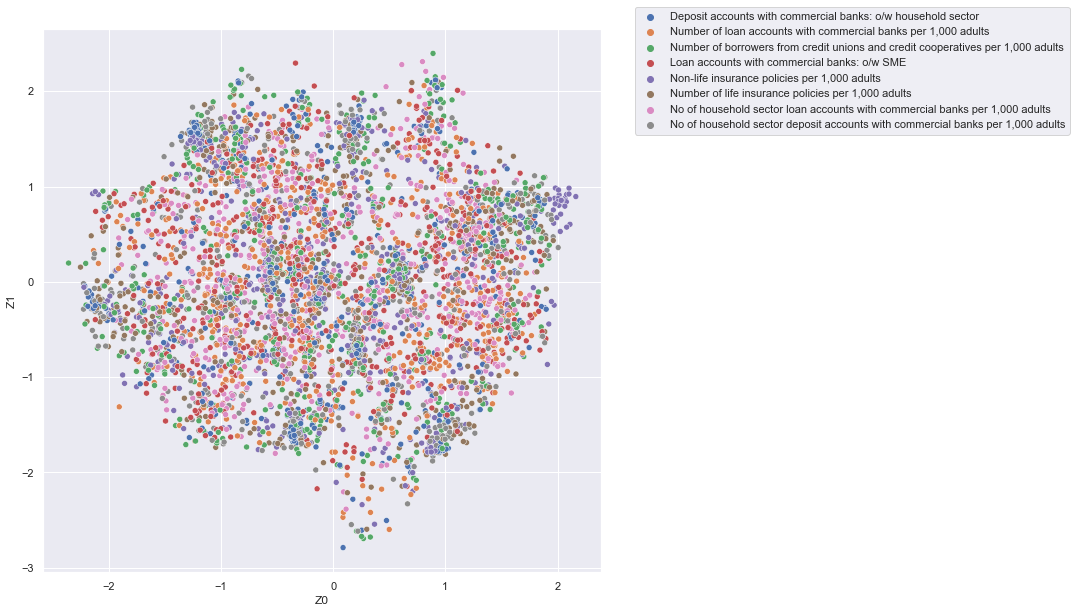

In [19]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Z0',y='Z1',hue='series',data=mu_tr_df)
plt.legend(bbox_to_anchor=(1.05, 1.05))

### Generating Samples from Trained Network

### P-value Estimation Procedure
1. Given: a bundle B ← (Y0, Yd, T0) \
    a. Y0 is the target’s timevseries,
    b. Yd are the k donors’ time series 
    c. T0 is time of intervention
2. TE0 = treatment estimated by constructing synthetic control using Yd 
3. M ← (C, R, D) = trained VAE neural network \
    a. π = C(Yd)
    b. Z ~ R(Pi)
    c. Y’d  = D(Z)
4. Sample n Z from R(pi), and consequently n samples of Y’d 
5. Estimate TE’ with Y'd0 as target (treatment estimated by constructing synthetic control using rest of Y’d) for each of the n samples
6. Estimate the P-value = P(TE0<TE’) ≃ count number of TE’ more than TE0

In [22]:
def gen_donor_samples(donor_normalized,vae_model,N,T,num_samples = 50):
    pi = vae_model.encode(donor_normalized)
    mu, logvar = pi
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    Z = vae_model.reparameterize(pi, eps) 
    S = train_arvae.generate_example_sample(vae_model, 0, 1, T, num_samples, N, latent_values=Z)
    return S

def credence_test(bundles, series, vae_model, N, time_intervention, num_samples = 50, method='lasso'):
    samples = []
    
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    donor_mean = np.mean(Y_donor.values)
    donor_std = np.std(Y_donor.values)
    
    Ypre_target_ = (Ypre_target-donor_mean)/donor_std
    Ypre_donor_ = (Ypre_donor-donor_mean)/donor_std
    Y_target_ = (Y_target-donor_mean)/donor_std
    Y_donor_ = (Y_donor-donor_mean)/donor_std
    
    print(f"\nMean of raw data: {np.mean(Y_target_.values):.3f}")
    print(f"Std. dev of raw data: {np.std(Y_target_.values):.3f}")
    
    m_lasso = lm.LassoCV().fit(Ypre_donor_.fillna(method='ffill'),Ypre_target_)
    Y_target_lasso = m_lasso.predict(Y_donor_.fillna(method='ffill'))
    null_effect = []
    effect0 = pd.Series( (Y_target_.values.reshape(-1,) - Y_target_lasso.reshape(-1,)) ,index=Y_donor.index)
    
    obs_data = bundles[series][3].values[:,:N]
    T = obs_data.shape[0]
    intervention = pd.DataFrame( np.zeros((T,1)), index=Y_target.index, columns=['intervention'] )
    intervention.loc[intervention['intervention']>time_intervention] = 1
    
    mean = np.mean(obs_data)
    stdev = np.std(obs_data)
    obs_data_norm = torch.tensor((obs_data.reshape(1,-1)-mean)/stdev).float()*torch.ones(num_samples,N*T)
    S = gen_donor_samples(obs_data_norm,vae_model,N,T,num_samples = num_samples)
    for i in range(num_samples):
        Si = pd.DataFrame(S[:,i,:],index=list(Y_donor.index),columns=['Y_gen_%d'%(k) for k in range(N)])
        Sipre = Si.loc[Si.index<=time_intervention]
        placebo = np.random.randint(0,N)
        if method=='lasso':
            m_lasso = lm.LassoCV().fit(Sipre.drop(columns=['Y_gen_%d'%(placebo)]),Sipre['Y_gen_%d'%(placebo)])
            S_target_lasso = m_lasso.predict(Si.drop(columns=['Y_gen_%d'%(placebo)]))
        else:
            m_lasso = lm.LassoCV().fit(Sipre,Ypre_target)
            S_target_lasso = m_lasso.predict(Si)
        
        null_effect_i = (Si['Y_gen_%d'%(placebo)].values.reshape(-1,) - S_target_lasso.reshape(-1,))
        null_effect += [null_effect_i]
    
    null_effect = pd.DataFrame(np.array(null_effect).T, index = Y_donor.index)
    return effect0, null_effect, intervention
    
    
    

# P Values

In [43]:
credence_p_val = {}


Mean of raw data: 3.900
Std. dev of raw data: 2.274

Mean of raw data: -0.204
Std. dev of raw data: 0.242

Mean of raw data: 0.110
Std. dev of raw data: 0.166

Mean of raw data: -0.491
Std. dev of raw data: 0.021

Mean of raw data: -0.516
Std. dev of raw data: 0.126

Mean of raw data: 11.281
Std. dev of raw data: 9.619

Mean of raw data: -0.723
Std. dev of raw data: 0.292

Mean of raw data: 1.439
Std. dev of raw data: 0.207


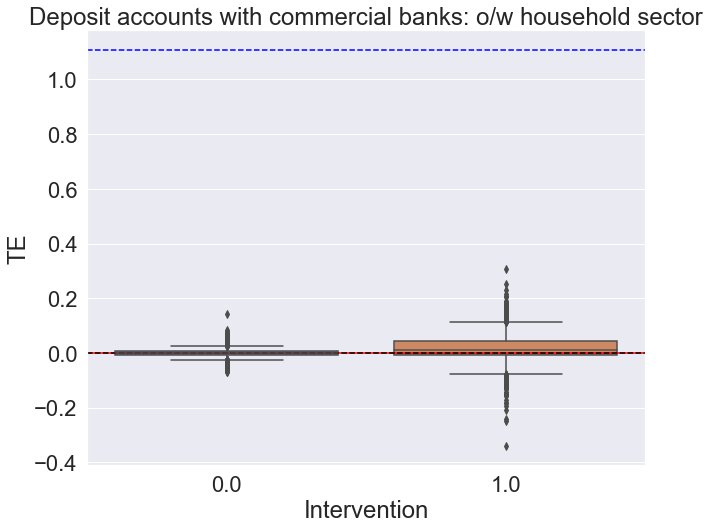

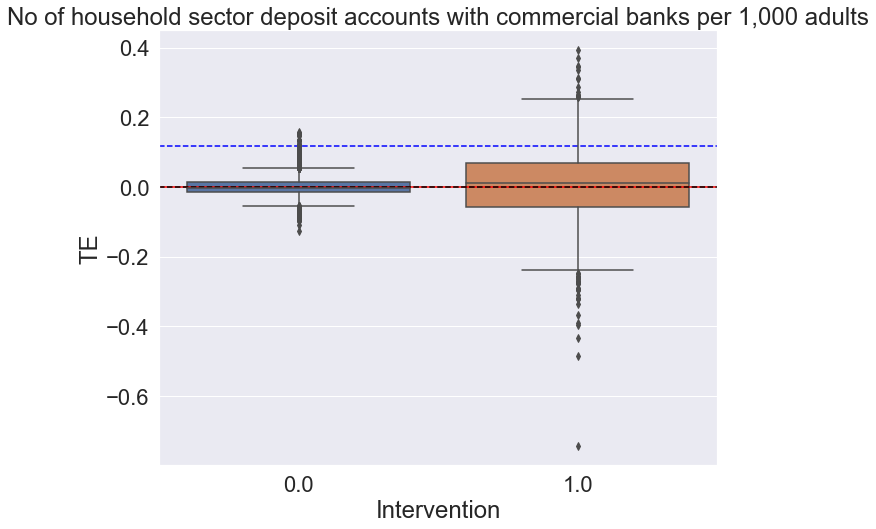

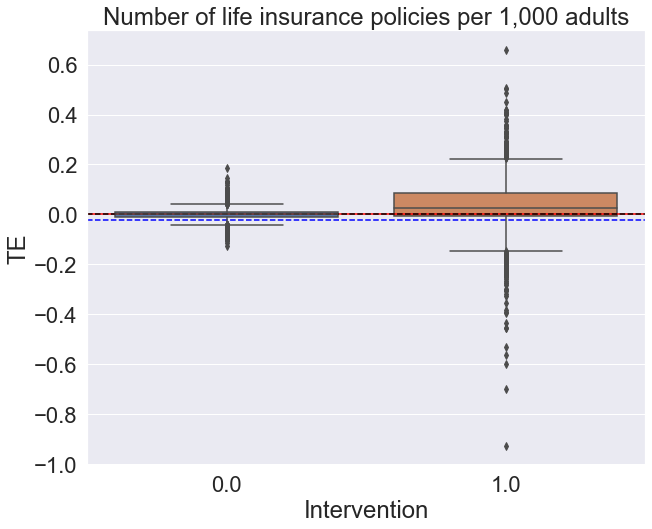

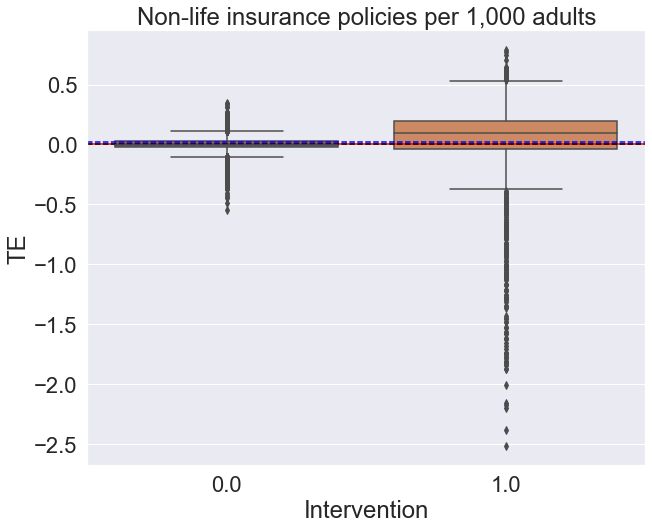

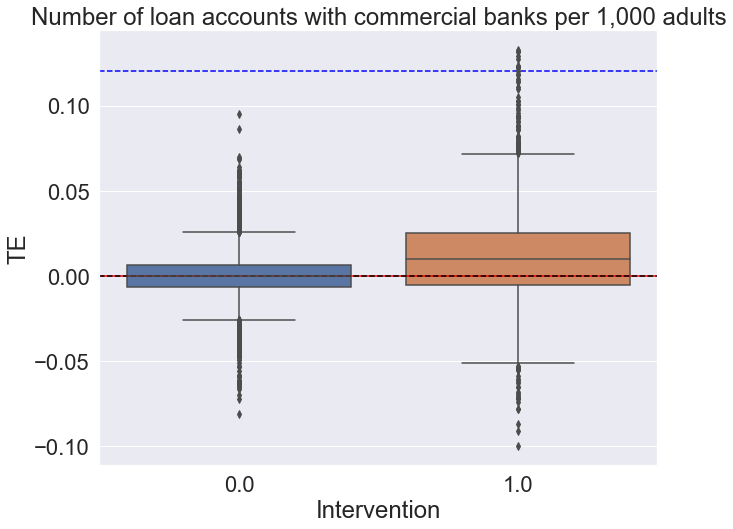

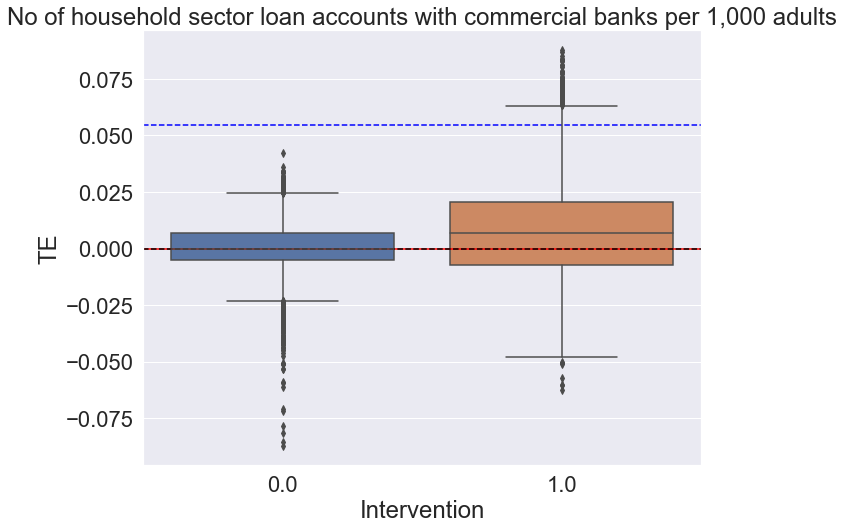

In [54]:
for series in bundles_names:# = 'No of household sector deposit accounts with commercial banks per 1,000 adults'
    time_intervention = 2015
    num_samples = 500
    try:
        effect0, null_effect, intervention = credence_test(bundles, series, 
                                                      vae_model, N, 
                                                      time_intervention=time_intervention, 
                                                      num_samples=num_samples)

        effect0.loc[effect0.index<=time_intervention].mean(), effect0.loc[effect0.index>time_intervention].mean()
        null_effect_post.mean()
        
        sns.set(font_scale=2)
        fig,ax = plt.subplots(figsize=(10,8))
        plt.axhline(0,c='red')
        plt.axhline(effect0.loc[effect0.index<=time_intervention].mean(),c='black',ls='--')
        plt.axhline(effect0.loc[effect0.index>time_intervention].mean(),c='blue',ls='--')
        null_effect_pre = null_effect.loc[null_effect.index<=time_intervention].stack().droplevel(level=1)
        null_effect_post = null_effect.loc[null_effect.index>time_intervention].stack().droplevel(level=1)
        df_effect = pd.DataFrame()
        df_effect['TE'] = list(null_effect_pre)+list(null_effect_post)
        df_effect['Intervention'] = list(np.zeros((12*num_samples,))) + list(np.ones((4*num_samples,)))
        sns.boxplot(x='Intervention',y='TE',data=df_effect)
        plt.title(series)
        fig.savefig('credence_%s.png'%(series))
        #effect0.plot(kind='line',ax=ax,legend=False,color='black',linewidth=3)
        #effect.plot(kind='line',ax=ax,legend=False,alpha=0.3)
        #sns.lineplot(data=effect.stack().droplevel(level=1),ci='sd',legend=False)
        credence_z_val_ = (effect0.loc[effect0.index>time_intervention].mean() - null_effect_post.mean())/(null_effect_post.std())
        credence_p_val_ = scipy.stats.norm.sf(abs(credence_z_val_))*2 
        credence_p_val[series] = credence_p_val_
    except:
        continue

In [55]:
credence_p_val

{'No of household sector deposit accounts with commercial banks per 1,000 adults': 0.2840613477678845,
 'Deposit accounts with commercial banks: o/w household sector': 4.0010005734851047e-122,
 'Number of life insurance policies per 1,000 adults': 0.5805087692494992,
 'Non-life insurance policies per 1,000 adults': 0.9973036190398515,
 'Number of loan accounts with commercial banks per 1,000 adults': 0.00012084992706626076,
 'No of household sector loan accounts with commercial banks per 1,000 adults': 0.062453265016518905}

# Credence Confidence Intervals

In [75]:
def gen_donor_samples(donor_normalized,vae_model,N,T,num_samples = 50):
    pi = vae_model.encode(donor_normalized)
    mu, logvar = pi
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    Z = vae_model.reparameterize(pi, eps) 
    S = train_arvae.generate_example_sample(vae_model, 0, 1, T, num_samples, N, latent_values=Z)
    return S

def credence_ci(bundles, series, vae_model, N, time_intervention, num_samples = 50, method='lasso'):
    samples = []
    
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    donor_mean = np.mean(Y_donor.values)
    donor_std = np.std(Y_donor.values)
    
    Ypre_target_ = (Ypre_target-donor_mean)/donor_std
    Ypre_donor_ = (Ypre_donor-donor_mean)/donor_std
    Y_target_ = (Y_target-donor_mean)/donor_std
    Y_donor_ = (Y_donor-donor_mean)/donor_std
    
    print(f"\nMean of raw data: {np.mean(Y_target_.values):.3f}")
    print(f"Std. dev of raw data: {np.std(Y_target_.values):.3f}")
    
    m_lasso = lm.LassoCV().fit(Ypre_donor.fillna(method='ffill'),Ypre_target)
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    effect = []
    effect0 = pd.Series( (Y_target.values.reshape(-1,) - Y_target_lasso.reshape(-1,)) ,index=Y_donor.index)
    
    obs_data = bundles[series][3].values[:,:N]
    T = obs_data.shape[0]
    intervention = pd.DataFrame( np.zeros((T,1)), index=Y_target.index, columns=['intervention'] )
    intervention.loc[intervention['intervention']>time_intervention] = 1
    
    mean = np.mean(obs_data)
    stdev = np.std(obs_data)
    obs_data_norm = torch.tensor((obs_data.reshape(1,-1)-mean)/stdev).float()*torch.ones(num_samples,N*T)
    S = gen_donor_samples(obs_data_norm,vae_model,N,T,num_samples = num_samples)
    for i in range(num_samples):
        Si = pd.DataFrame(S[:,i,:],index=list(Y_donor.index),columns=['Y_gen_%d'%(k) for k in range(N)])
        Sipre = Si.loc[Si.index<=time_intervention]
        if method=='lasso':
            m_lasso = lm.LassoCV().fit(Sipre,Ypre_target_)
            S_target_lasso = m_lasso.predict(Si)
        else:
            m_lasso = lm.LassoCV().fit(Sipre,Ypre_target)
            S_target_lasso = m_lasso.predict(Si)
        
        effect_i = ( Y_target_.values.reshape(-1,) - S_target_lasso.reshape(-1,) )
        effect += [effect_i]
    
    effect = (np.array(effect).T) * donor_std
    effect = pd.DataFrame(effect, index = Y_donor.index)
    return effect0, effect, intervention


Mean of raw data: 3.900
Std. dev of raw data: 2.274

Mean of raw data: -0.204
Std. dev of raw data: 0.242

Mean of raw data: 0.110
Std. dev of raw data: 0.166

Mean of raw data: -0.491
Std. dev of raw data: 0.021

Mean of raw data: -0.516
Std. dev of raw data: 0.126

Mean of raw data: 11.281
Std. dev of raw data: 9.619

Mean of raw data: -0.723
Std. dev of raw data: 0.292

Mean of raw data: 1.439
Std. dev of raw data: 0.207


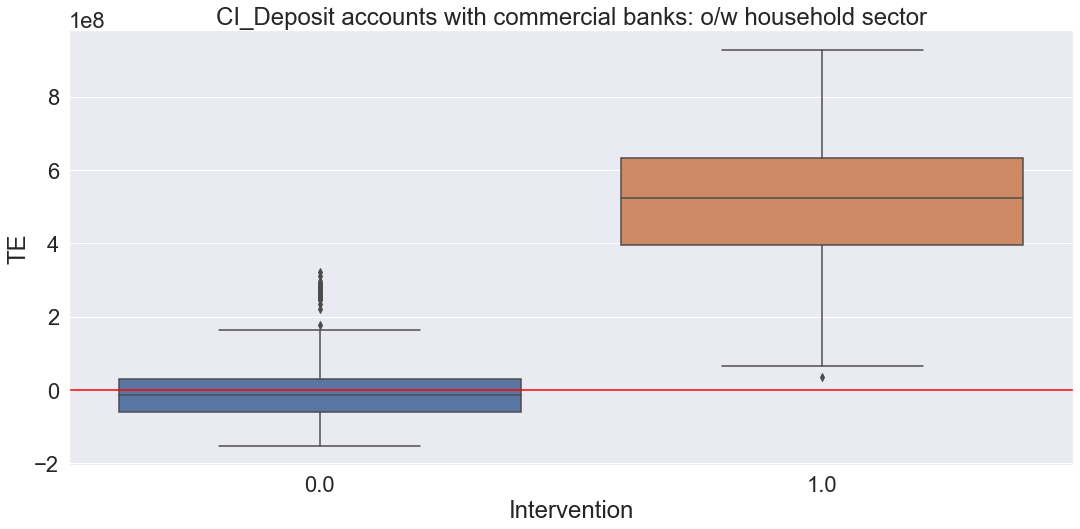

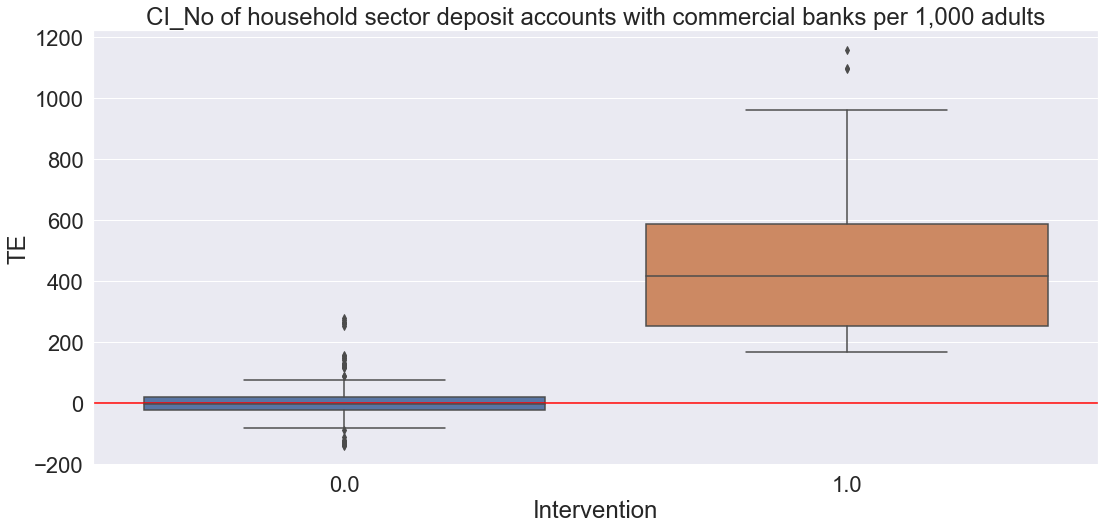

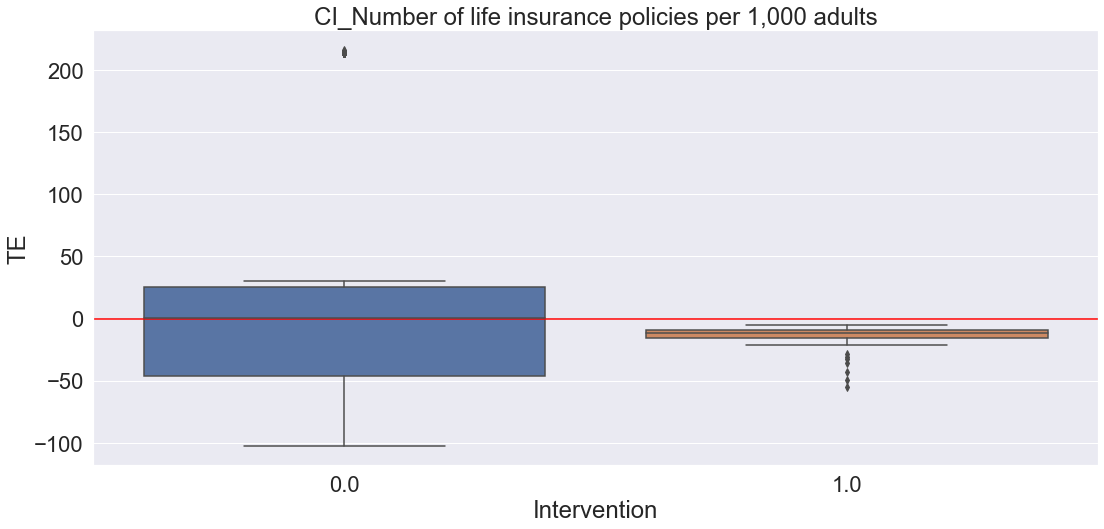

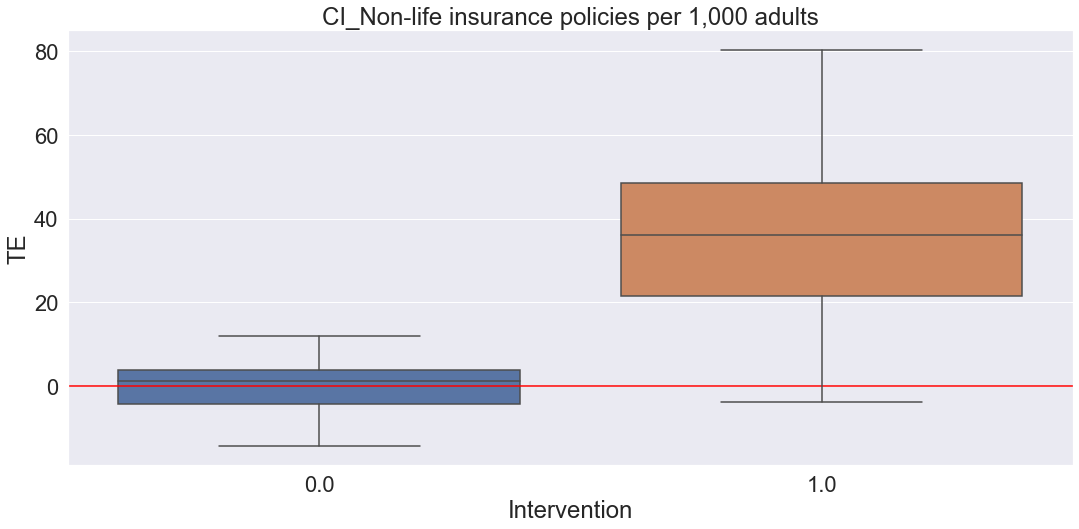

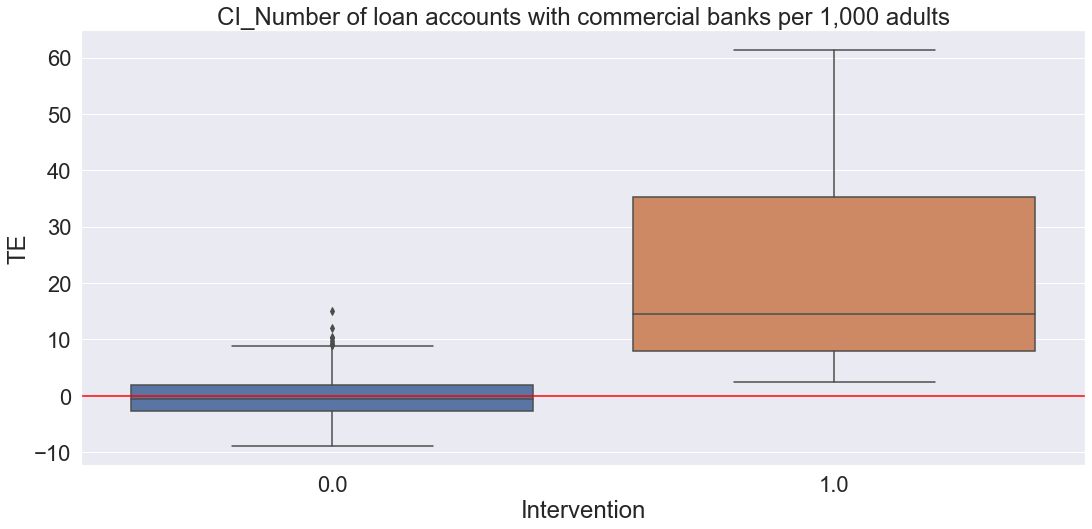

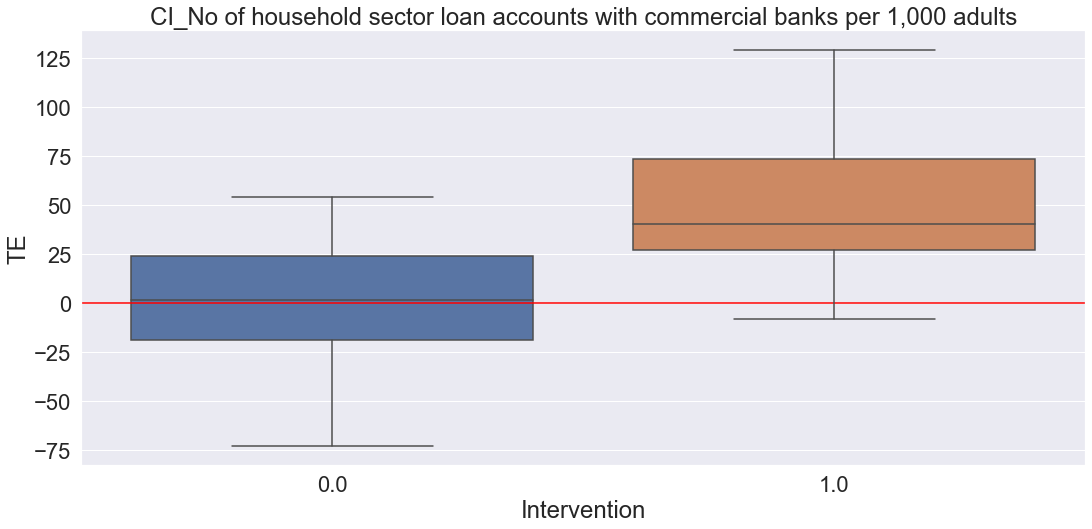

In [76]:
ci = {}
for series in bundles_names:
    time_intervention = 2015
    num_samples = 50
    try:
        effect0, effect, intervention = credence_ci(bundles, series, 
                                                      vae_model, N, 
                                                      time_intervention=time_intervention, 
                                                      num_samples=num_samples)
        fig,ax = plt.subplots(figsize=(18,8))
        plt.axhline(0,c='red')
        effect_pre = effect.loc[effect.index<=time_intervention].stack().droplevel(level=1)
        effect_post = effect.loc[effect.index>time_intervention].stack().droplevel(level=1)
        df_effect = pd.DataFrame()
        df_effect['TE'] = list(effect_pre)+list(effect_post)
        df_effect['Intervention'] = list(np.zeros((12*num_samples,))) + list(np.ones((4*num_samples,)))
        sns.boxplot(x='Intervention',y='TE',data=df_effect)
        plt.title('CI_%s'%(series))
        plt.savefig('ci_%s.png'%(series))
        ci[series] = [effect0.loc[effect0.index>time_intervention].mean(), effect_post.mean(), effect_post.mean() + 1.96*effect_post.std(), effect_post.mean() - 1.96*effect_post.std()]
    except:
        continue

In [77]:
ci

{'No of household sector deposit accounts with commercial banks per 1,000 adults': [228.02784201191082,
  443.95903510953576,
  864.3771154759029,
  23.54095474316864],
 'Number of life insurance policies per 1,000 adults': [-10.536782541666668,
  -12.539895112481172,
  1.0024670985196629,
  -26.082257323482008],
 'Non-life insurance policies per 1,000 adults': [36.07016082607545,
  34.821175522428476,
  76.50916312351737,
  -6.866812078660409],
 'Number of loan accounts with commercial banks per 1,000 adults': [33.573283750364766,
  24.42456666866856,
  63.312062454201126,
  -14.462929116864004],
 'No of household sector loan accounts with commercial banks per 1,000 adults': [14.959395866073443,
  47.38154751770252,
  103.92572840116415,
  -9.162633365759099]}